# Numerical Example

/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/oma.py:346: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if matrix_type is 'hankel':
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/oma.py:348: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif matrix_type is 'toeplitz':
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/oma.py:361: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if weighting is 'cva':  #[2] used, [1] vibration_data in ill-conditioning issues
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/oma.py:368: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if algorithm is 'standard':
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/oma.py:404: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if algorithm is 'standard': #this means NExT-ERA is chosen
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/koma/oma.py:406: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif algorithm is 'shift':
/Users/emilne

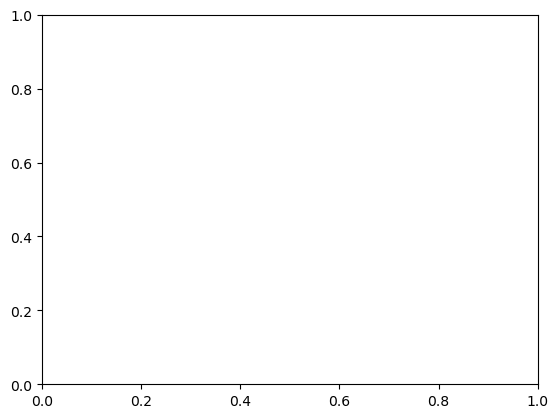

In [3]:
import koma.oma, koma.plot
import numpy as np
import matplotlib.pyplot as plt
import koma.clustering

from scipy.signal import detrend, welch, resample

from knutils.modal import statespace as to_A
from knutils.structural import shearframe
from beef.newmark import newmark_lin
import plot_koma

In [4]:
path = "vibration_data/data_stochastic_3_floor_"

number_of_realizations = 100

### Data generation

In [5]:
# Code for data generation here

### Define SSI parameters

In [30]:
i = 50
s = 4

orders = np.arange(2, 60+2, 2)
stabcrit = {'freq':0.2, 'damping': 0.2, 'mac': 0.3}

### Cov-SSI call and pole clustering

/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_71768/2116825512.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fig = plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/np.pi/2, order_auto, true_w=true_f)
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_71768/2116825512.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fig = plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/np.pi/2, order_auto, true_w=true_f)
/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_71768/2116825512.py:27: VisibleDeprecationWarning

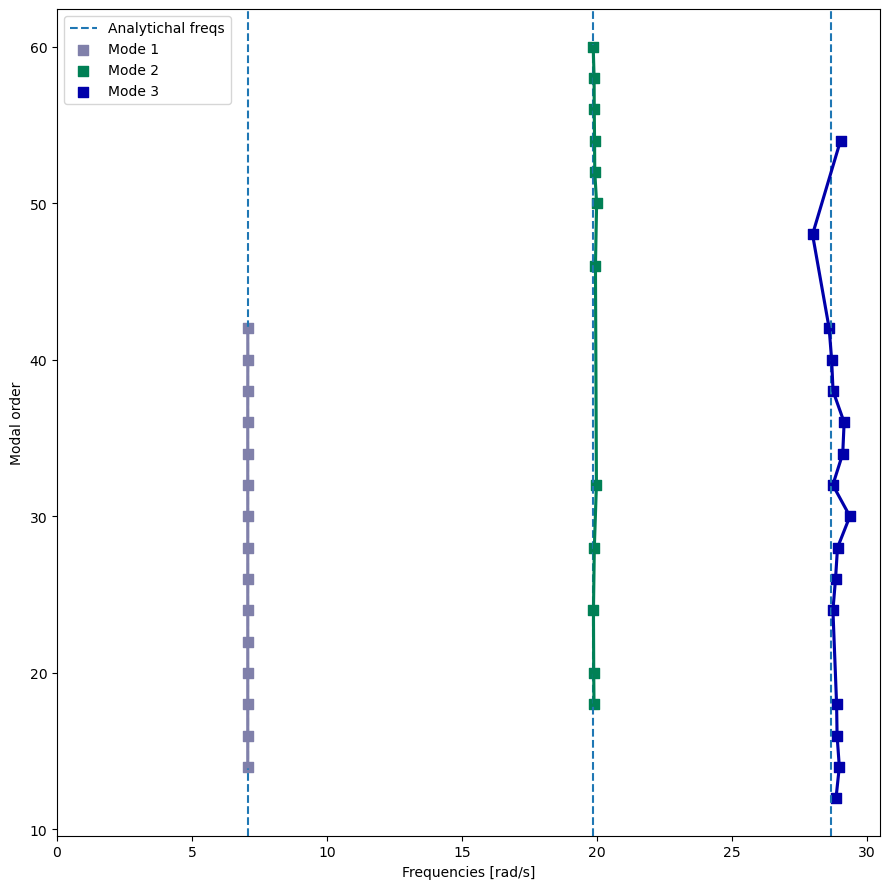

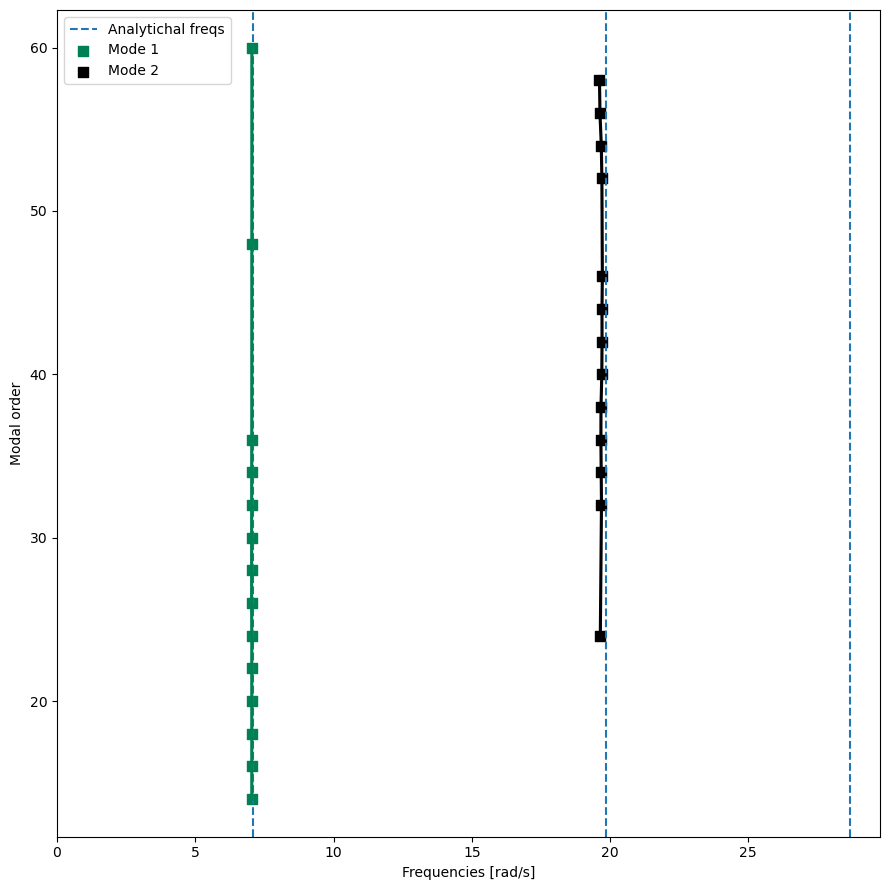

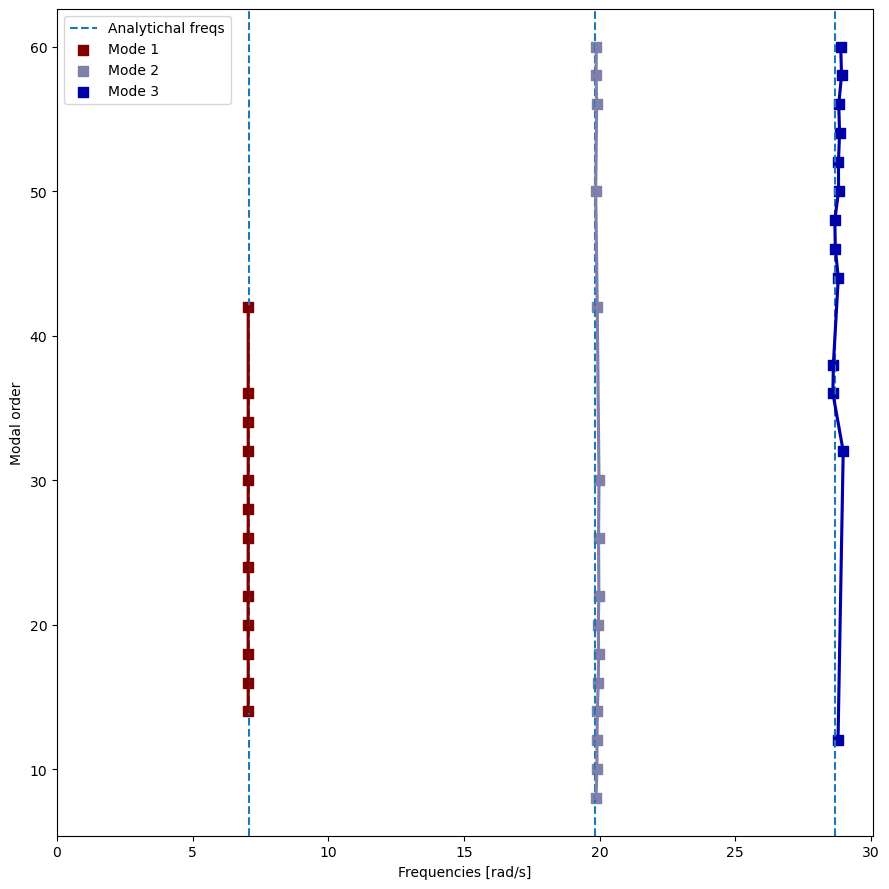

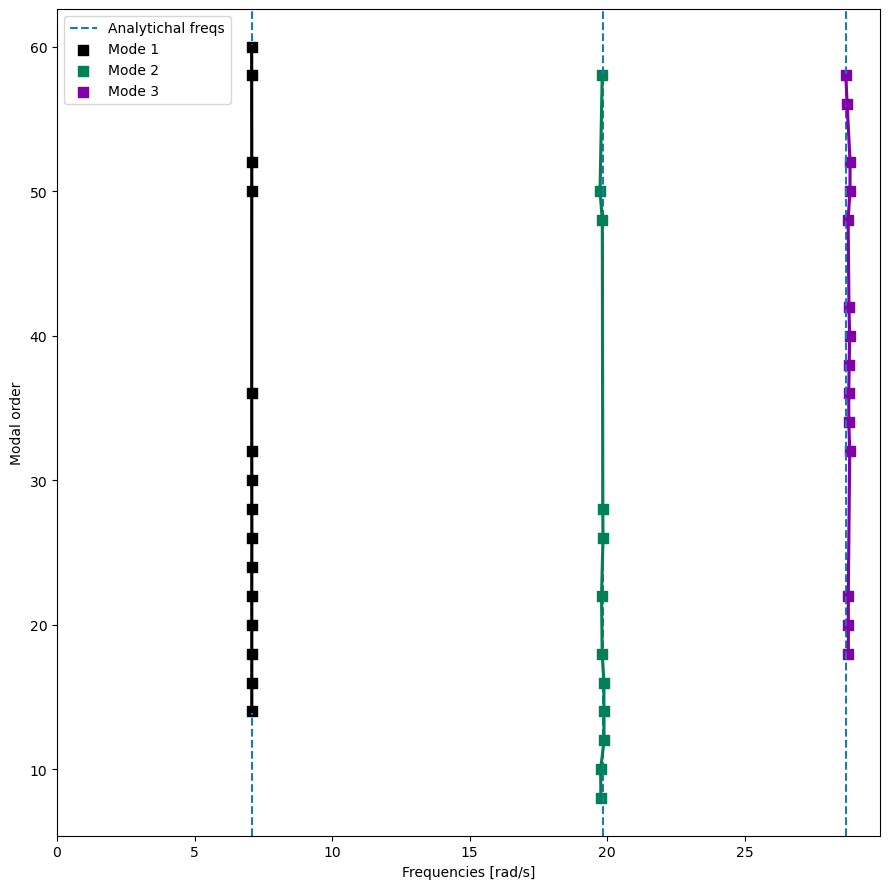

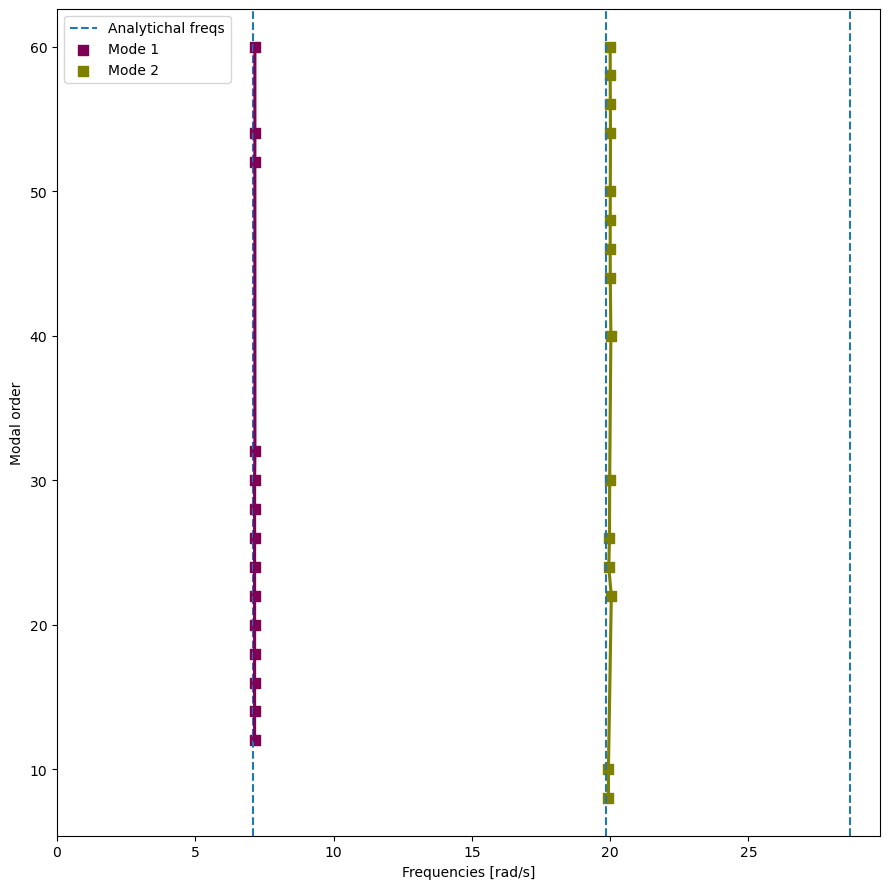

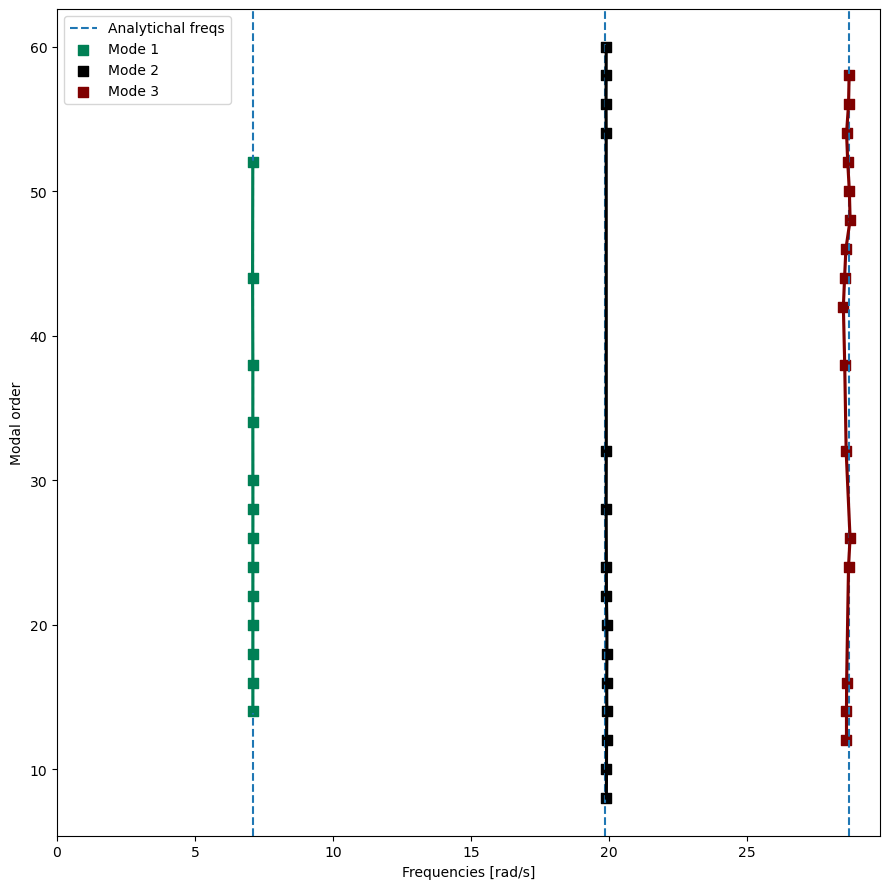

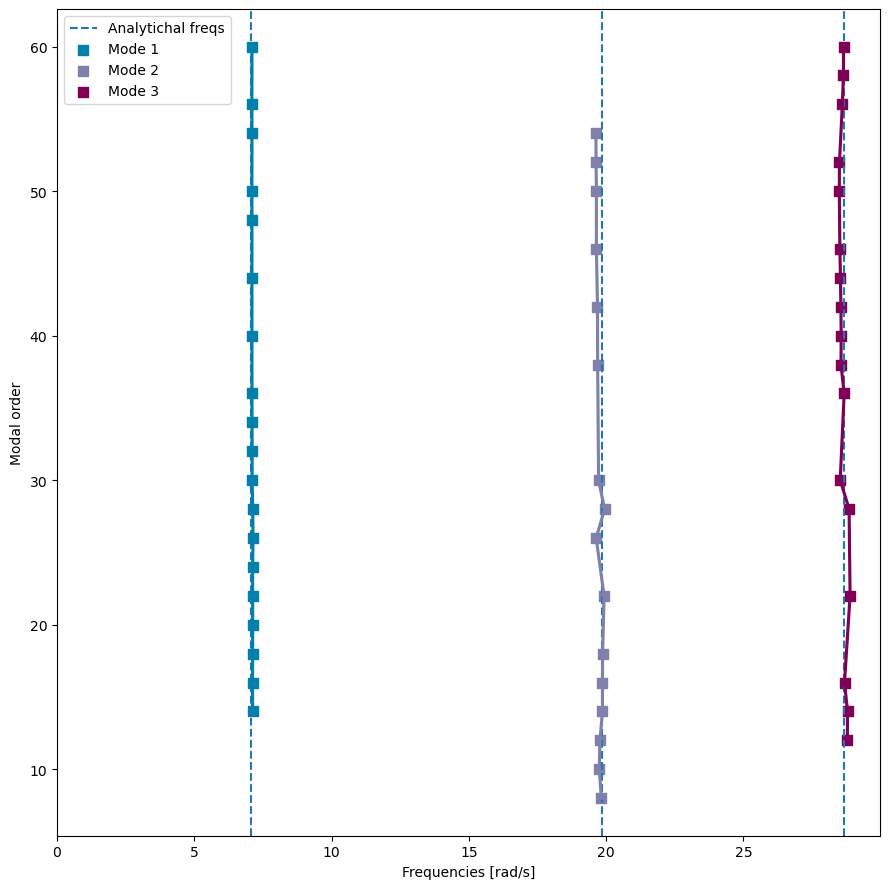

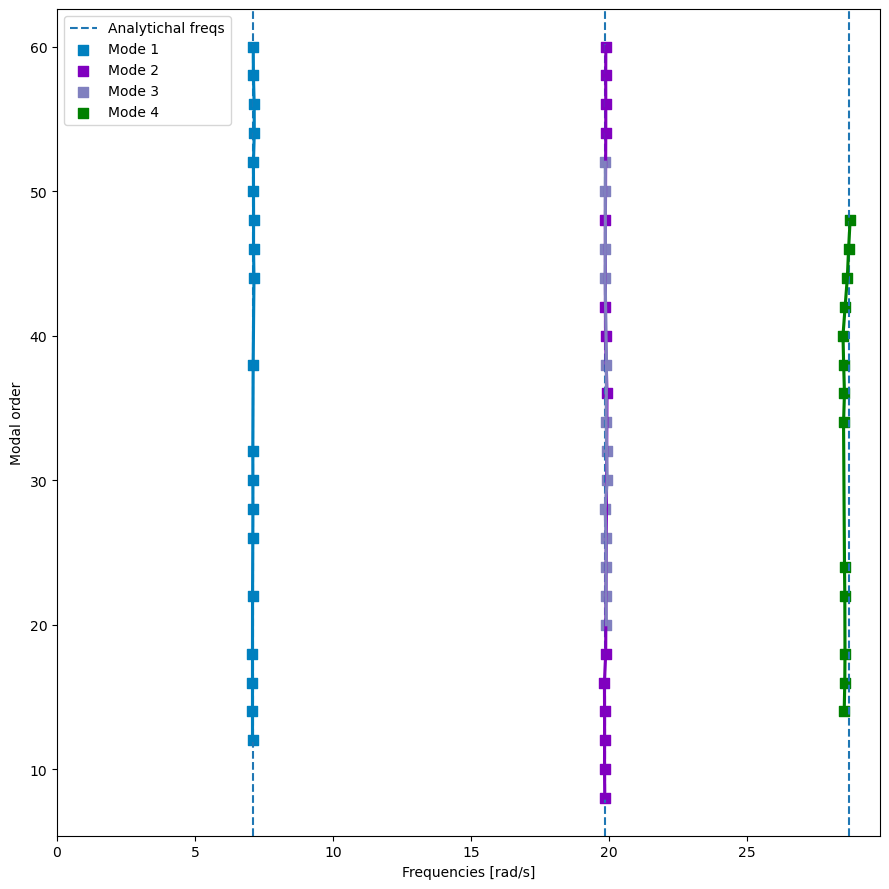

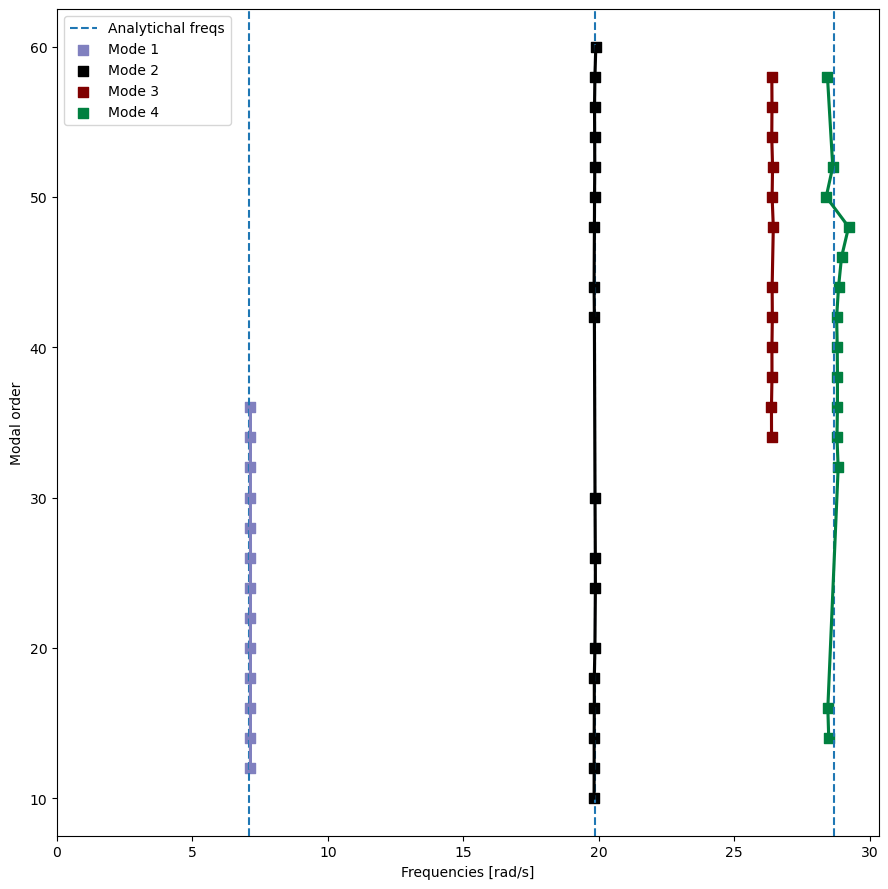

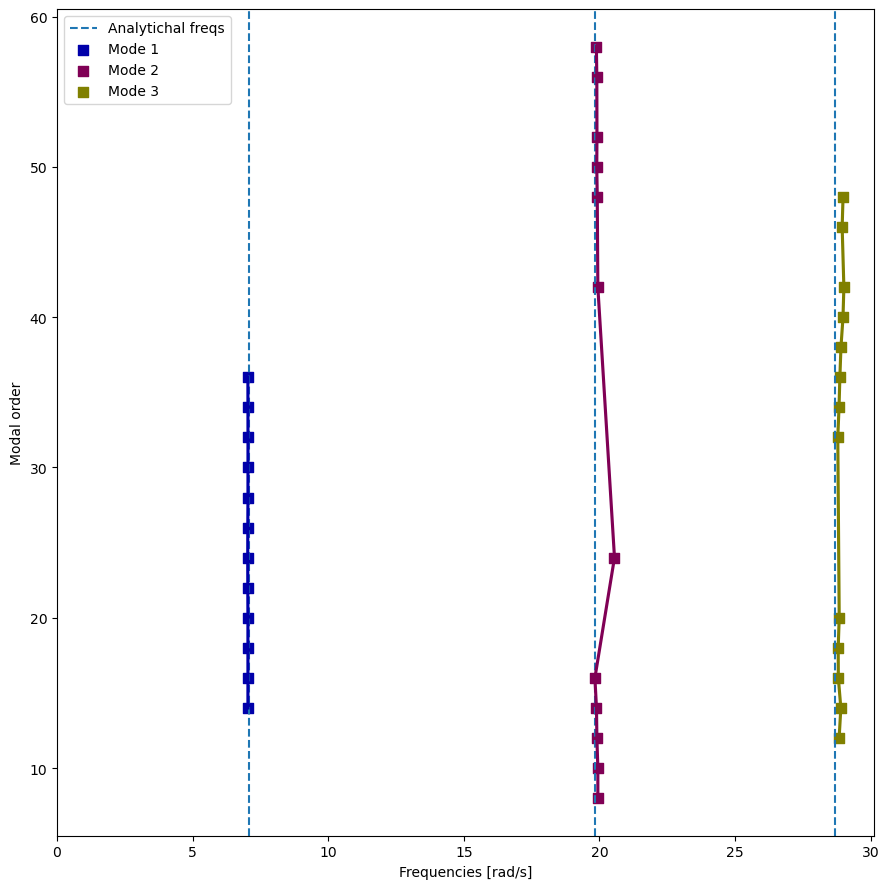

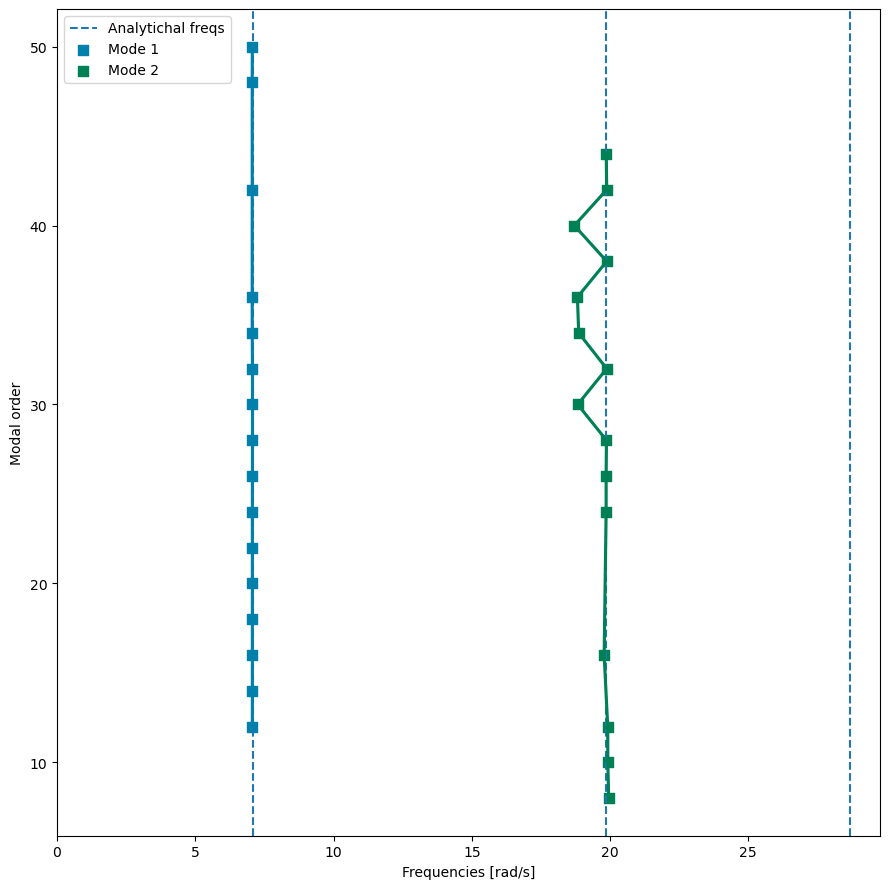

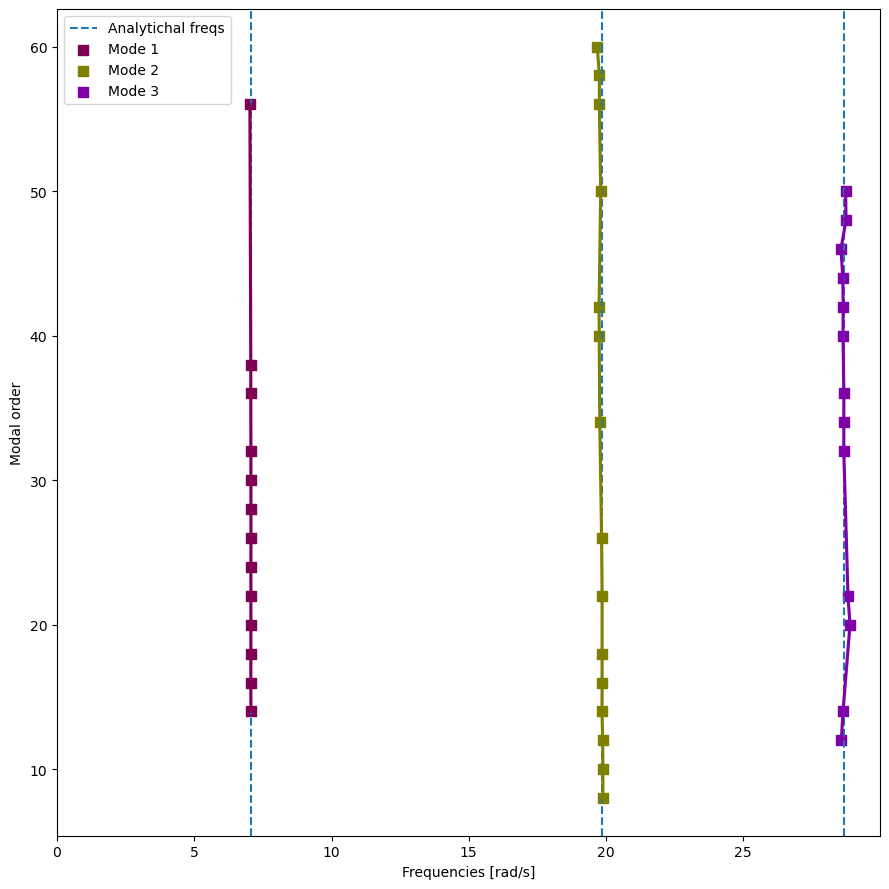

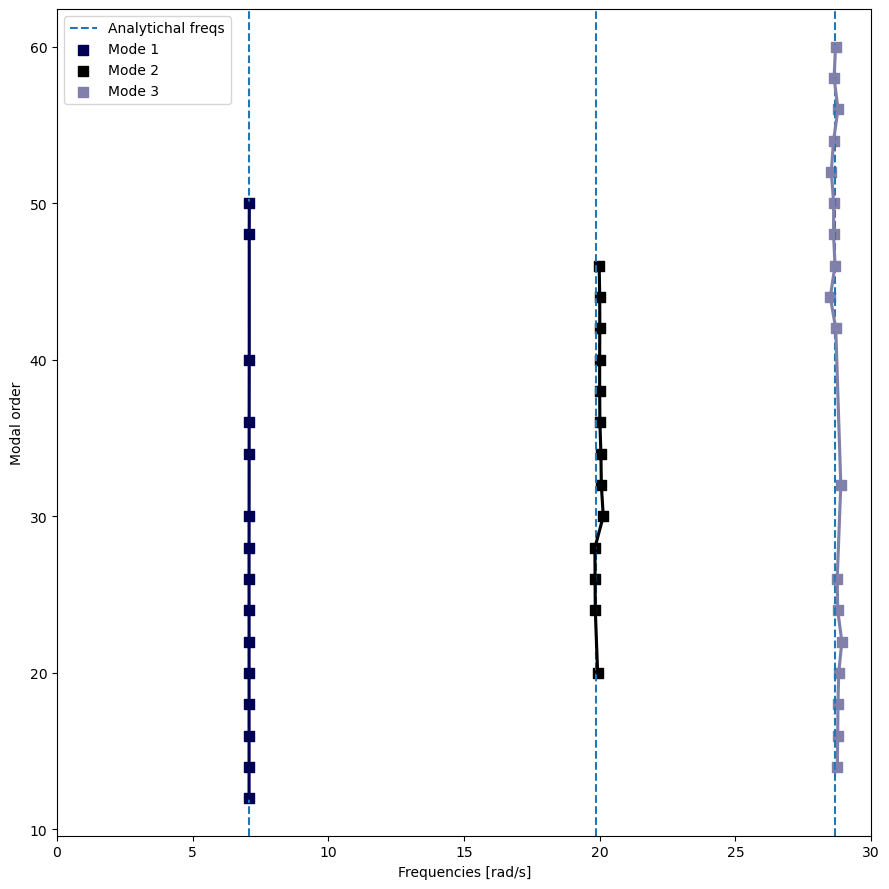

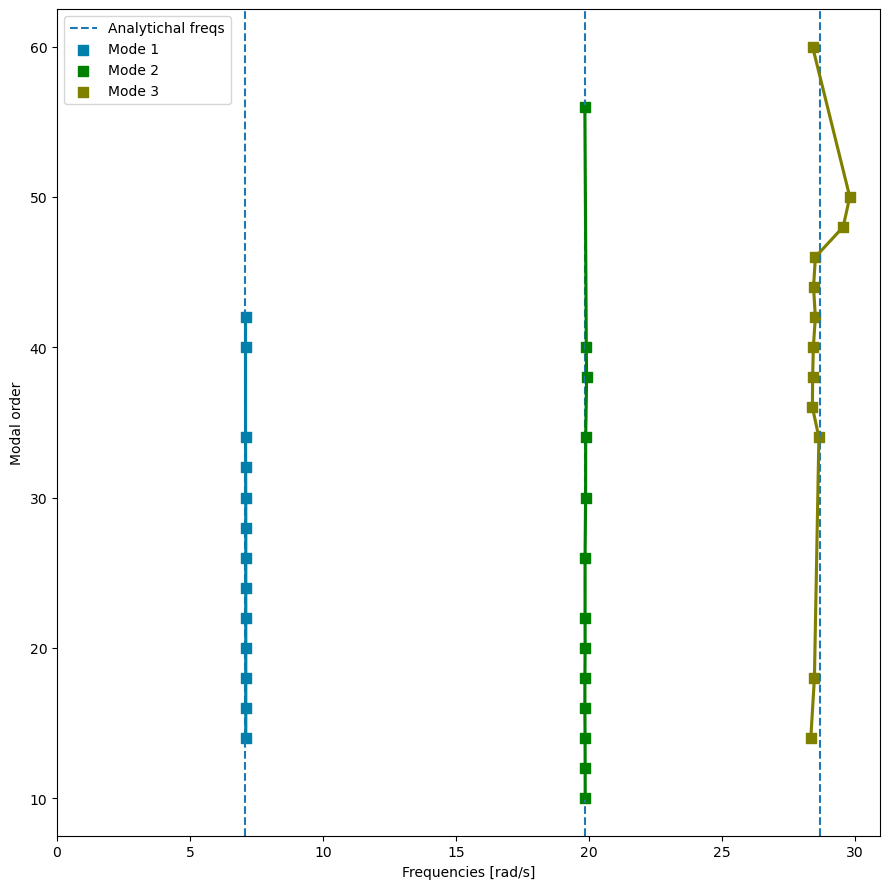

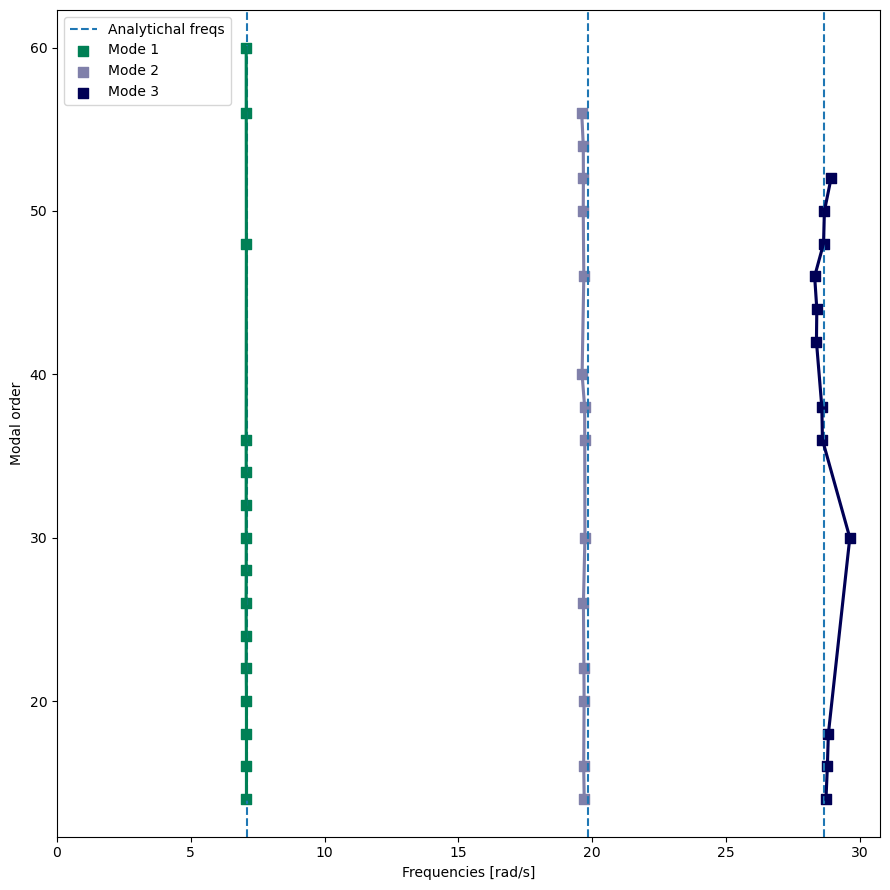

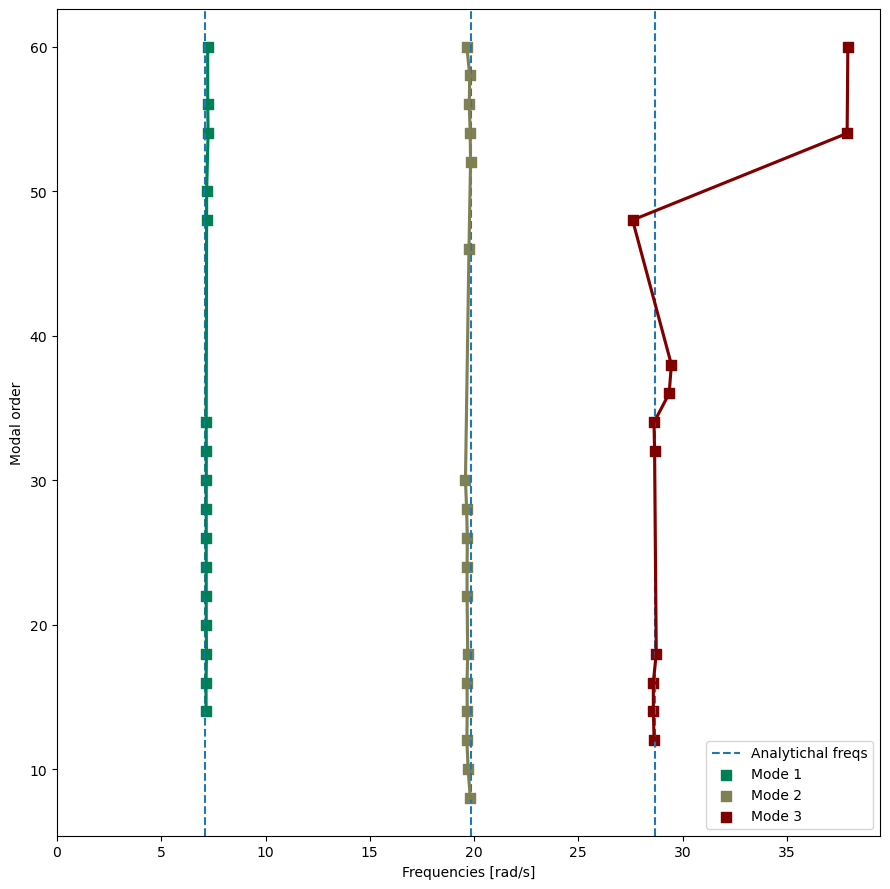

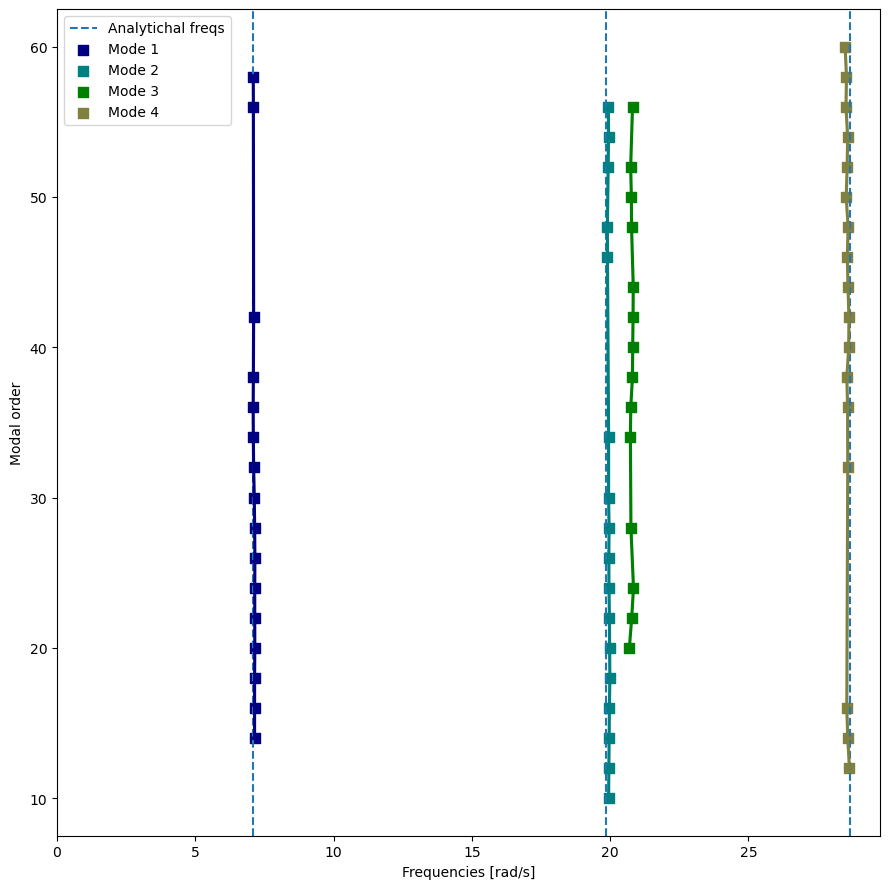

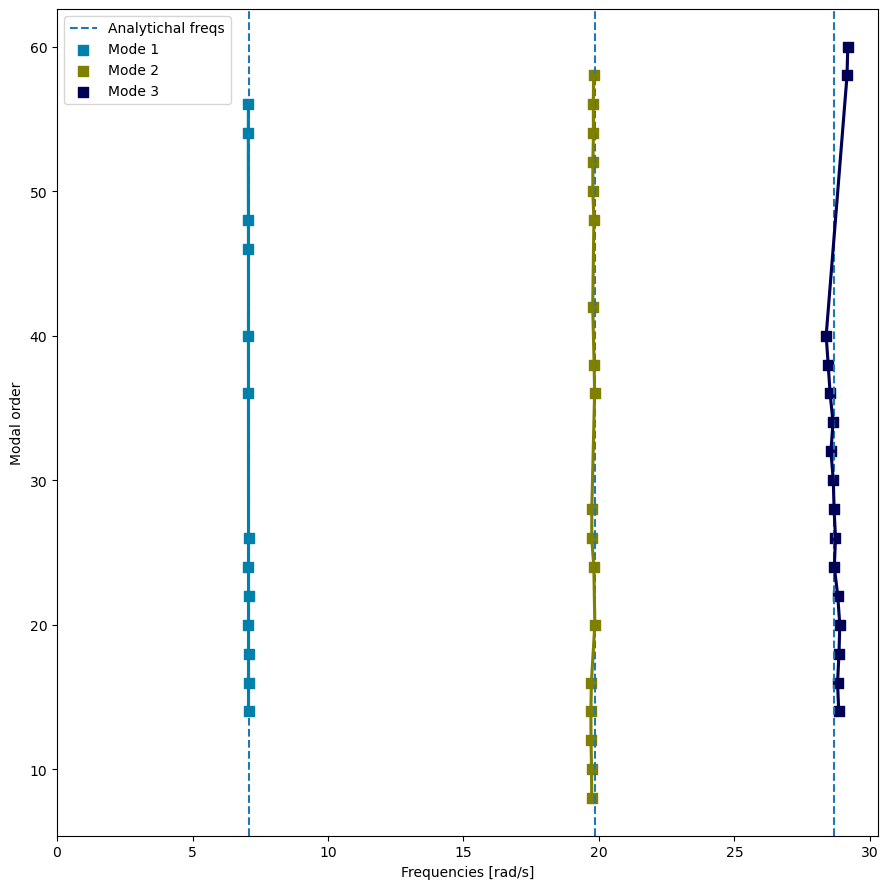

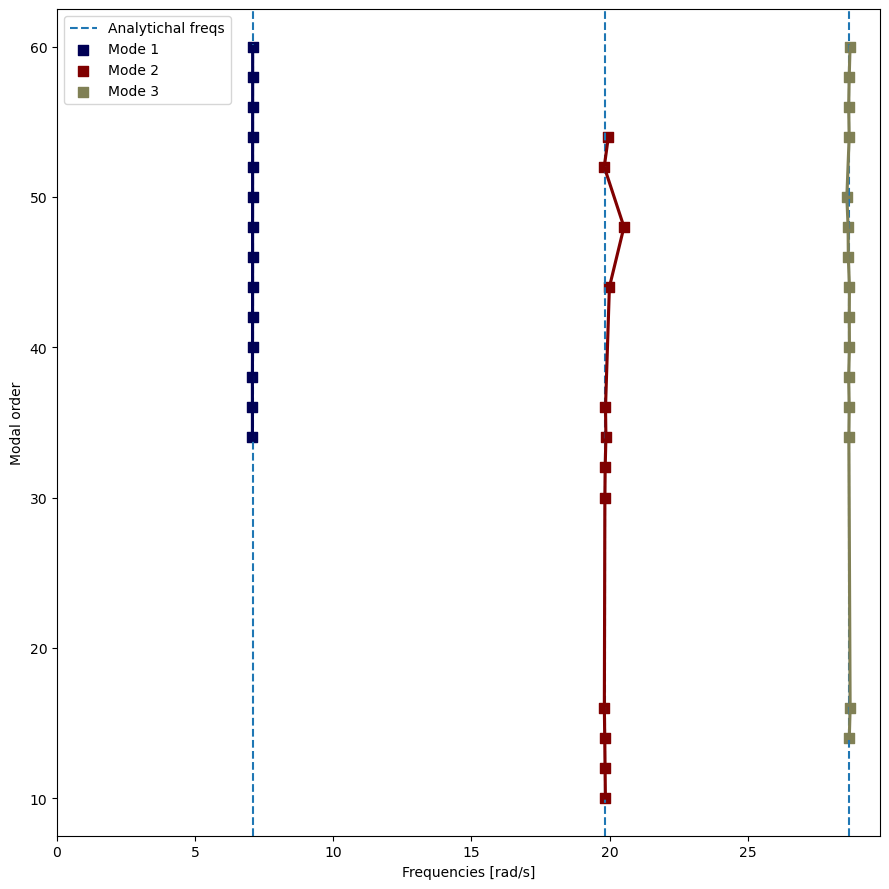

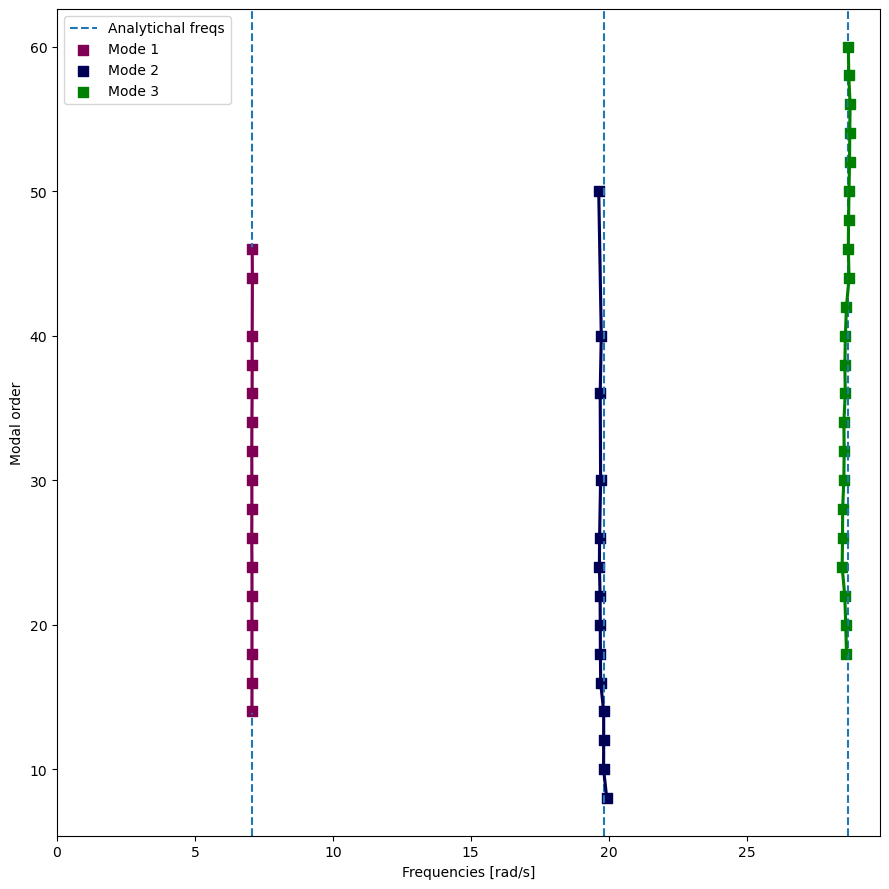

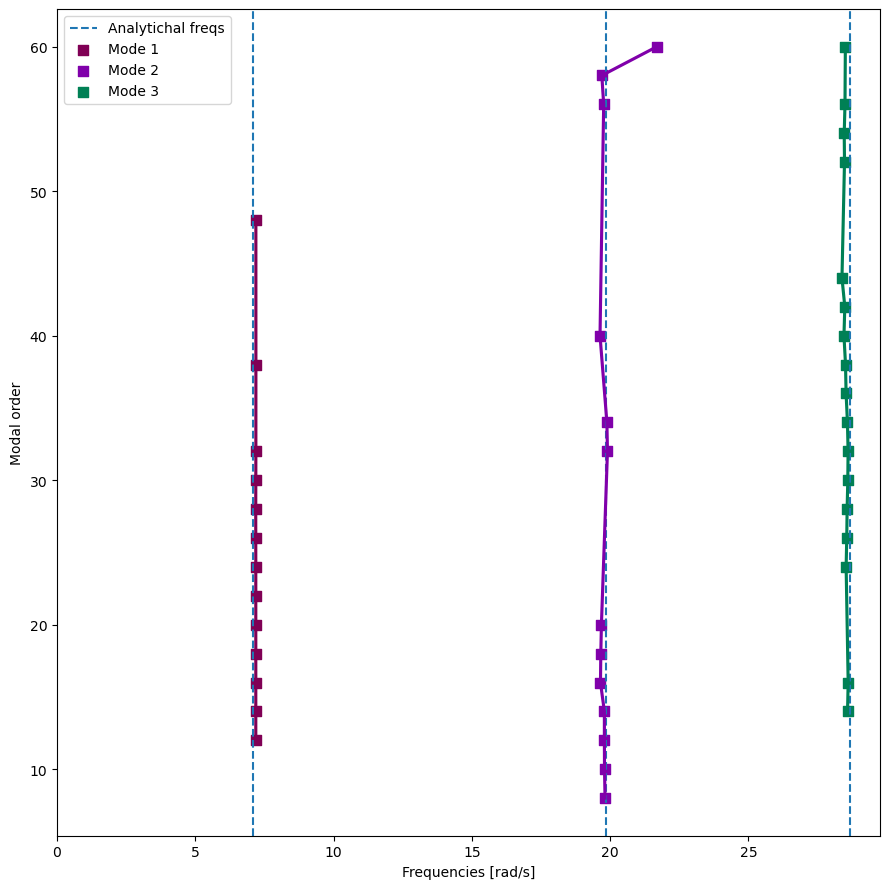

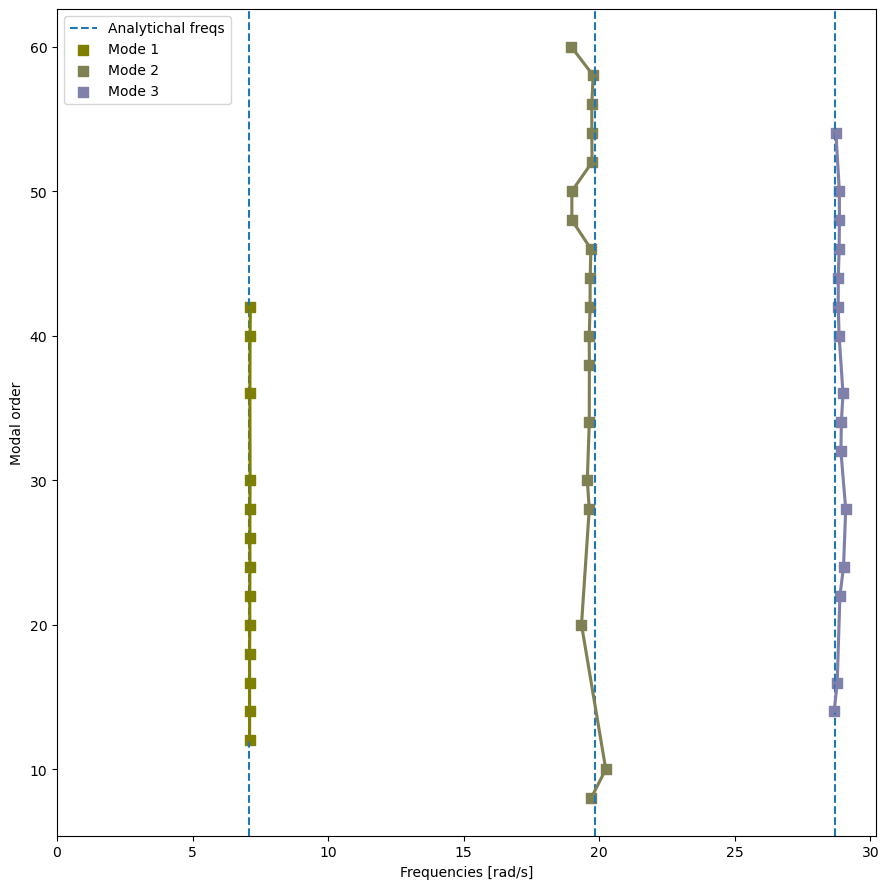

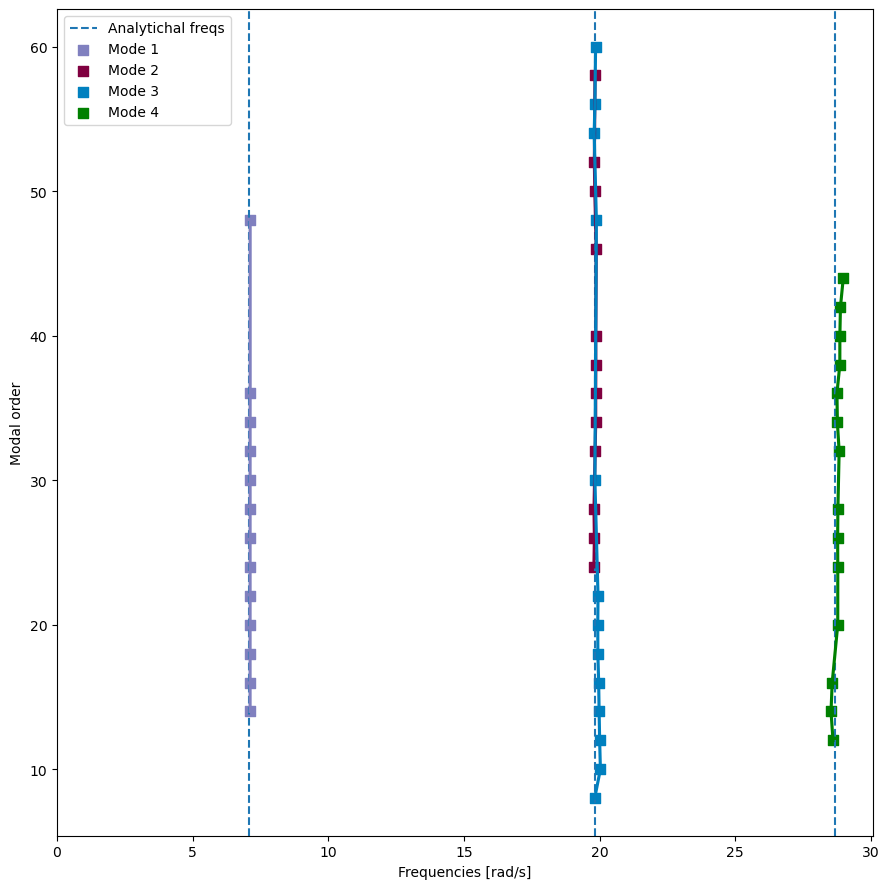

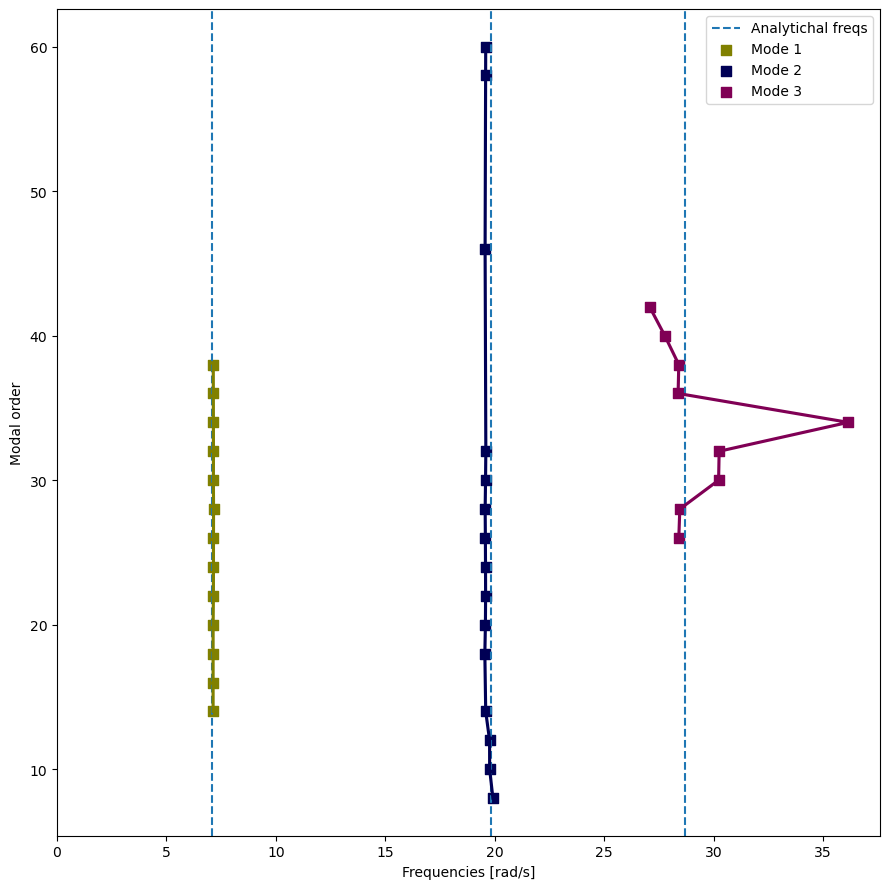

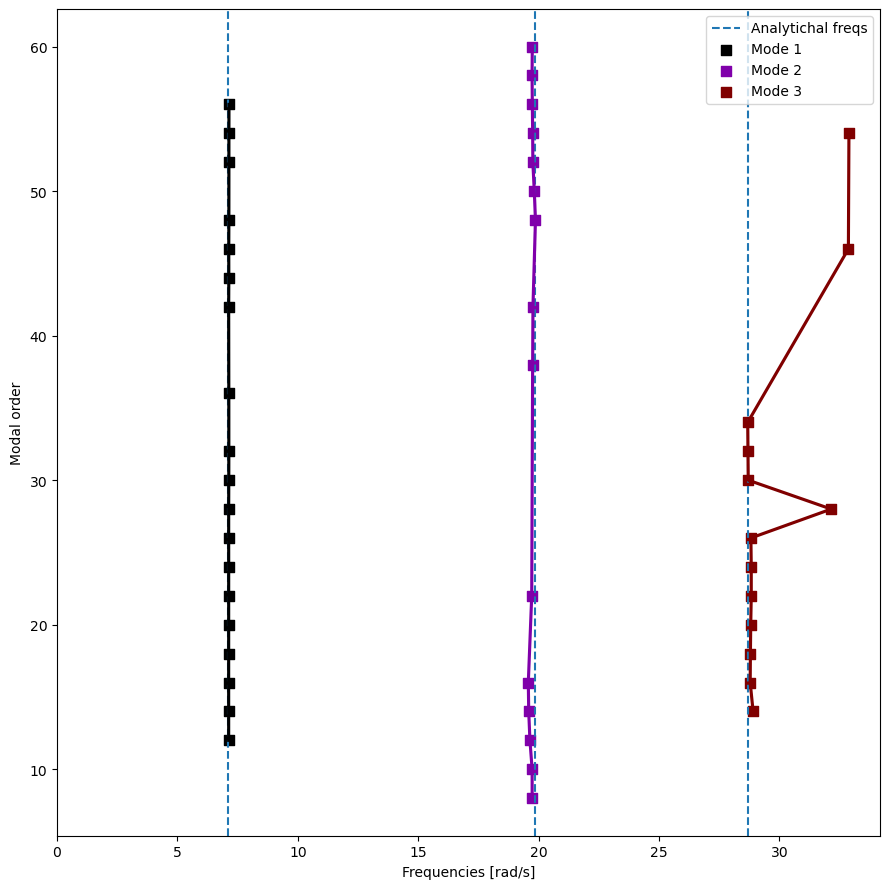

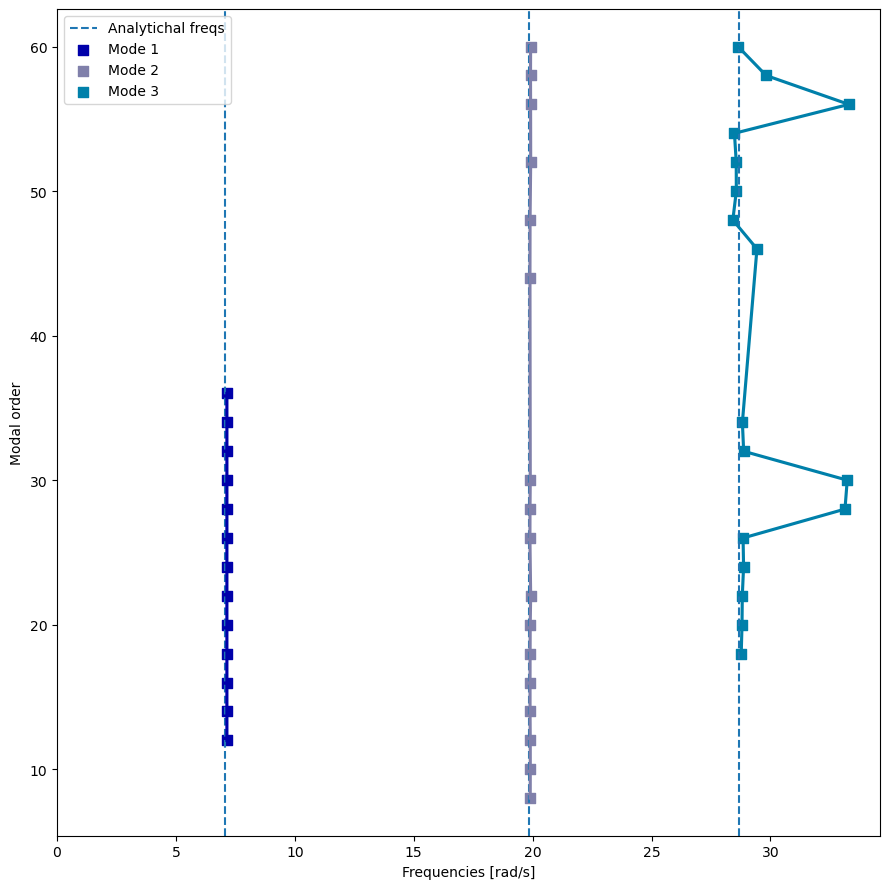

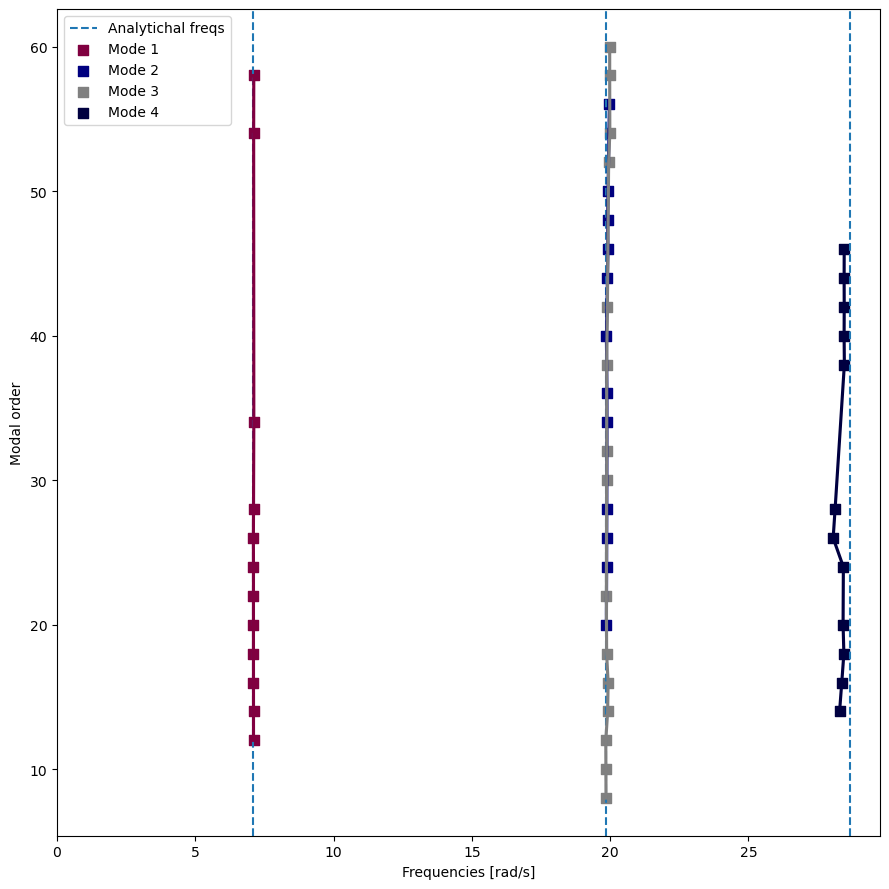

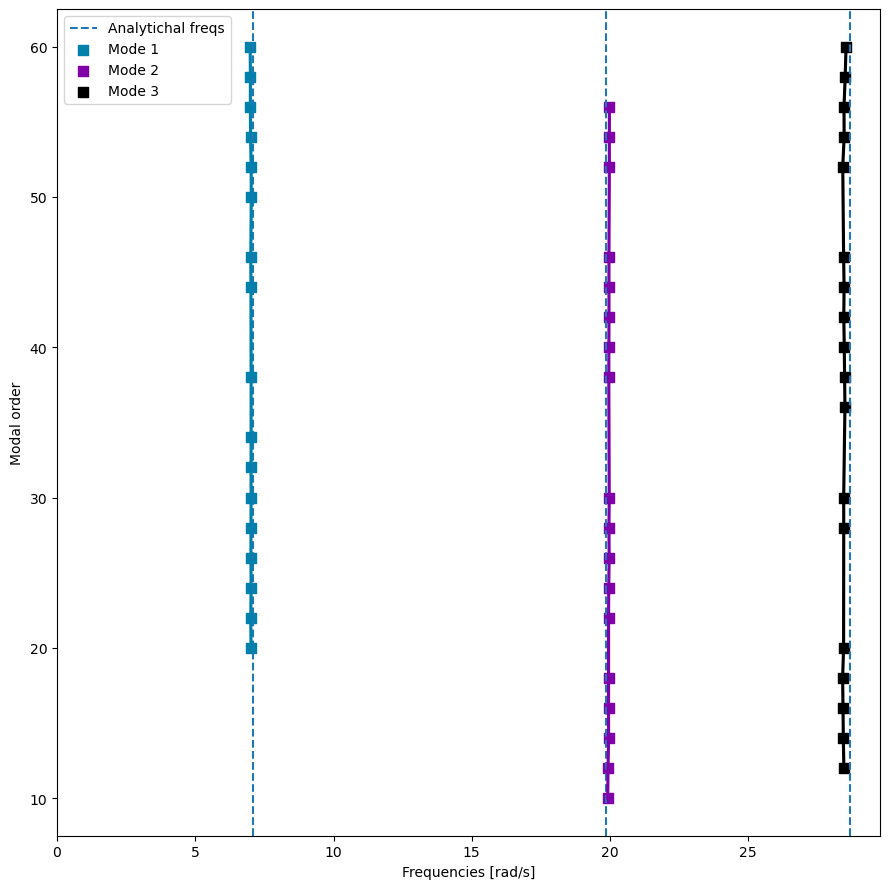

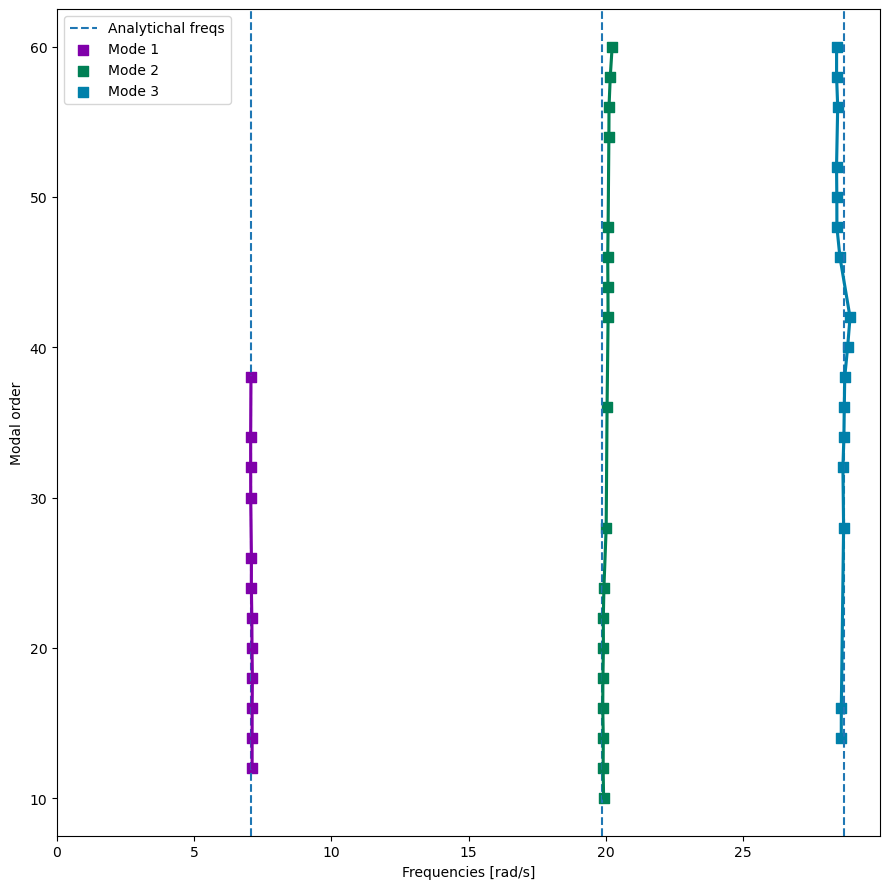

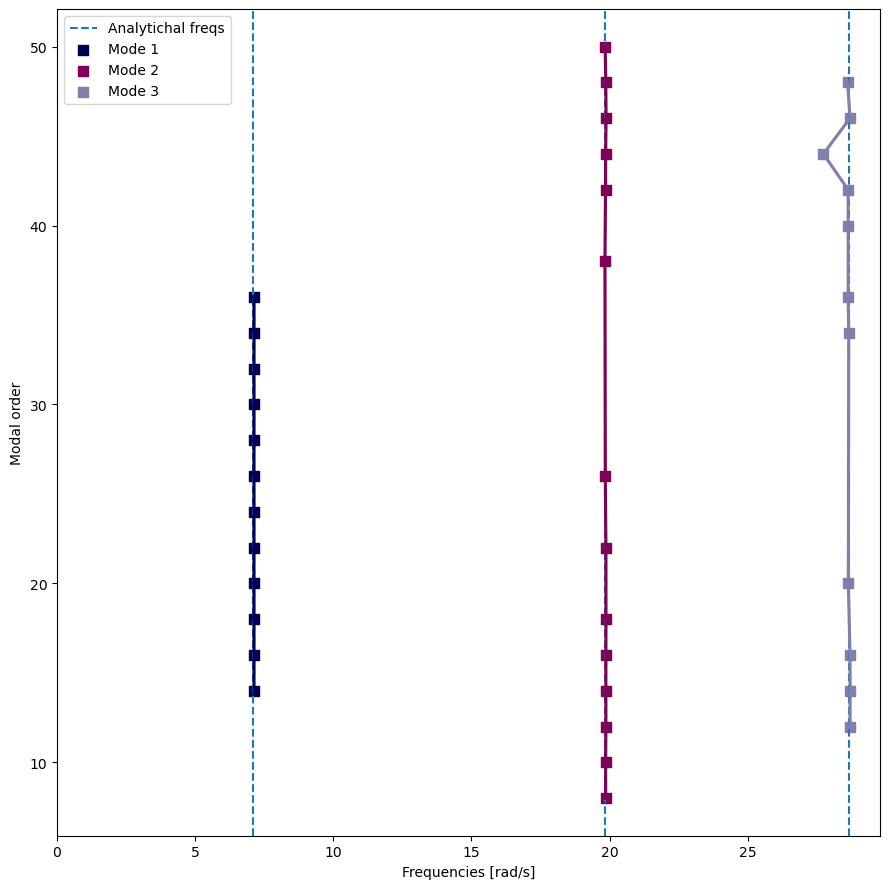

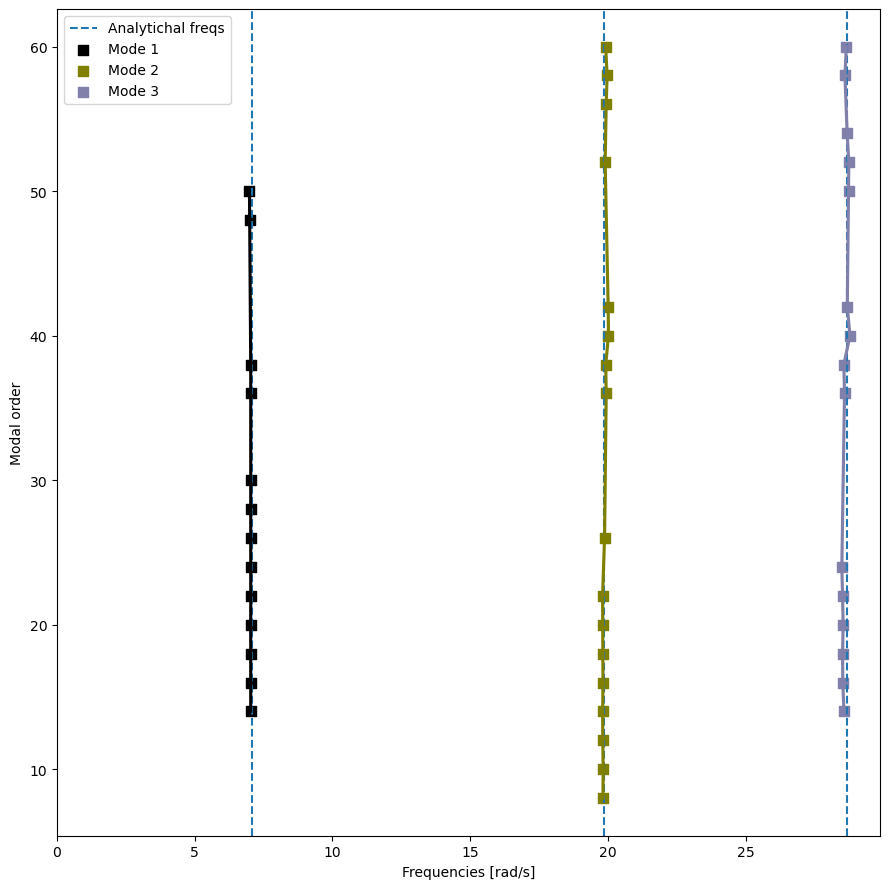

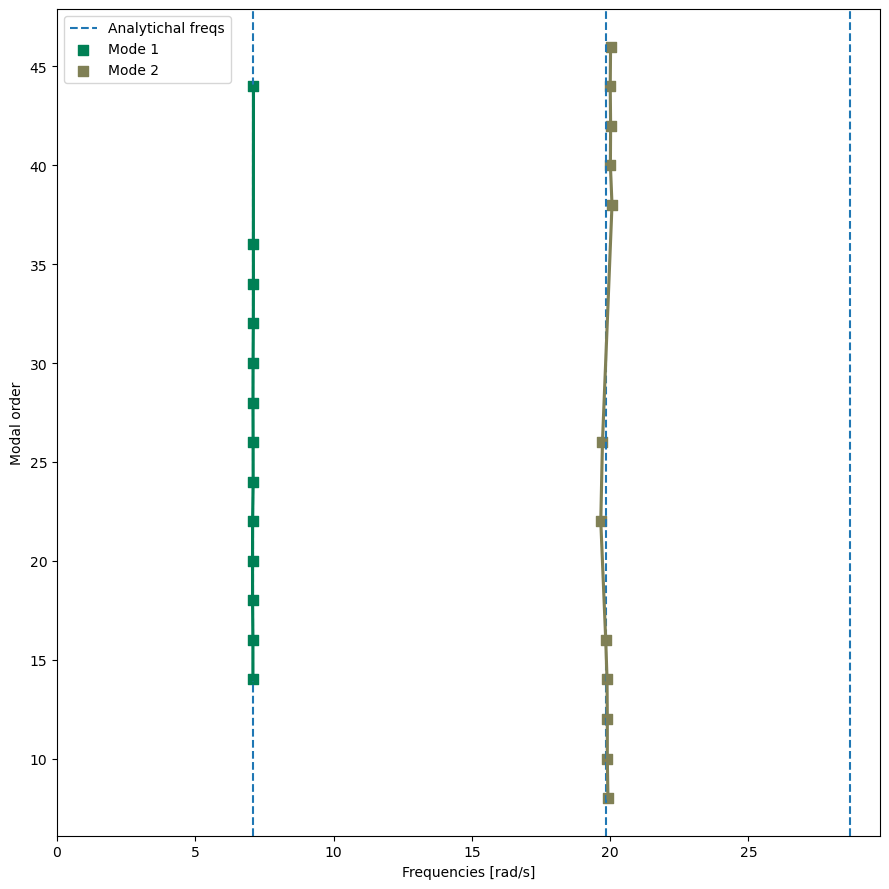

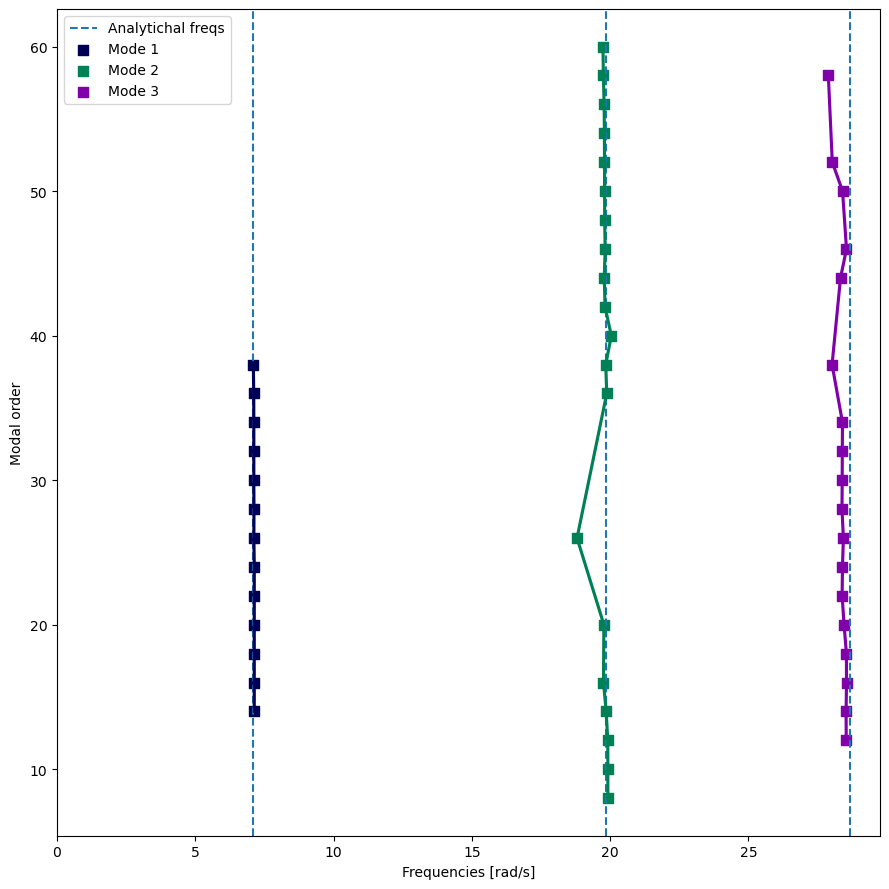

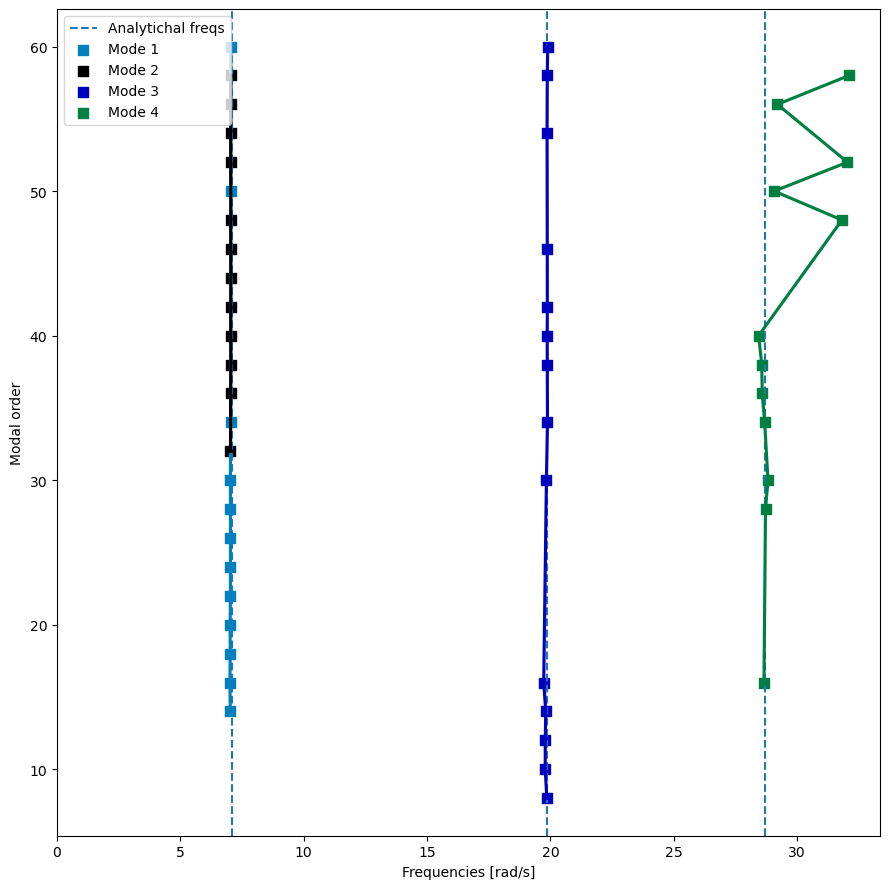

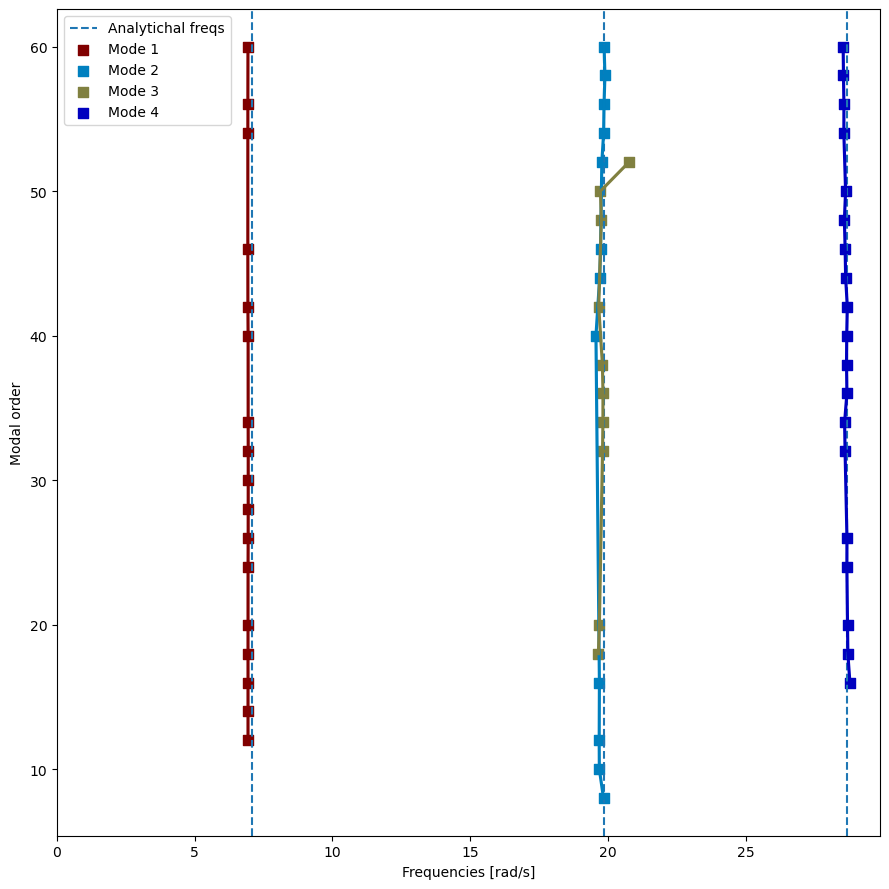

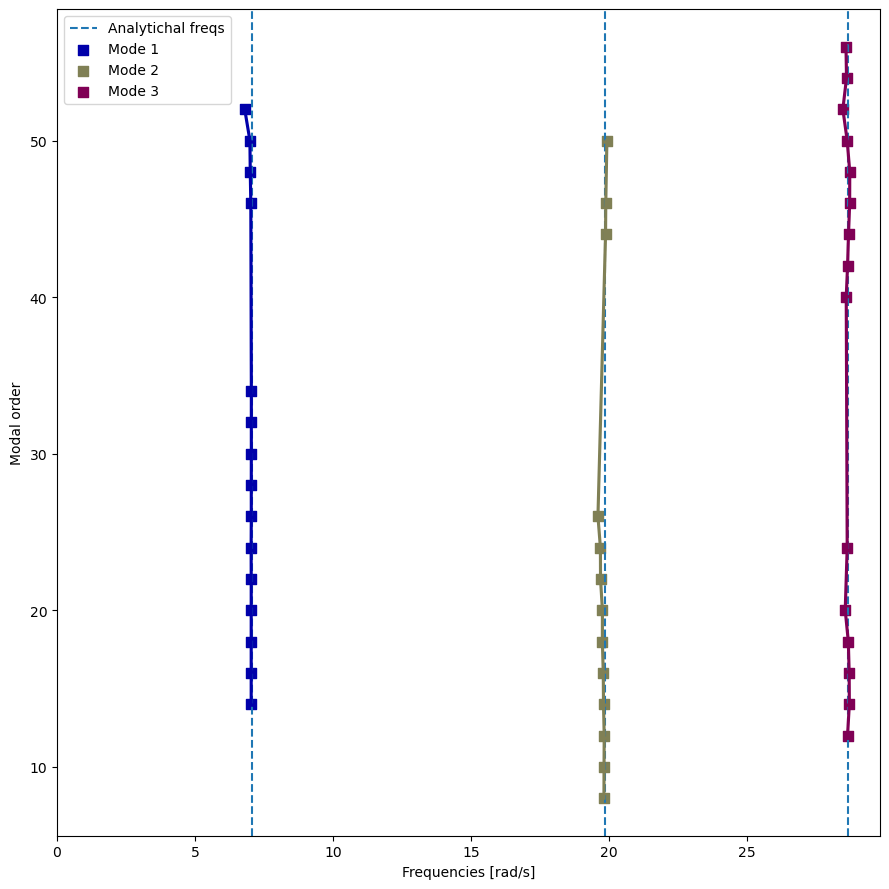

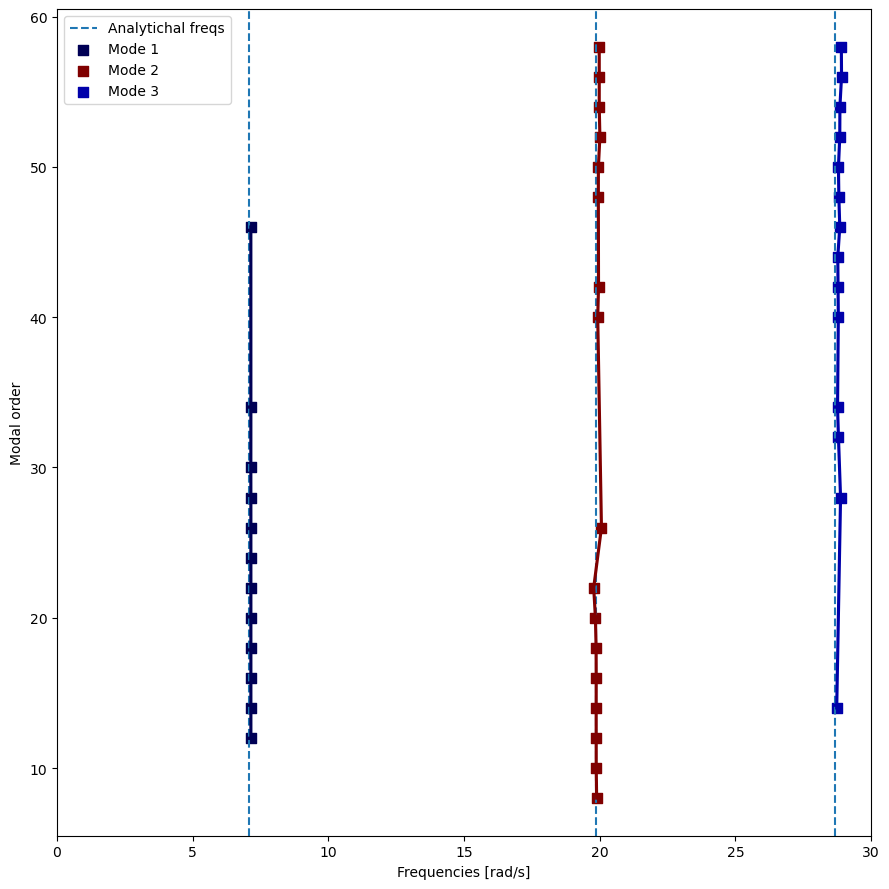

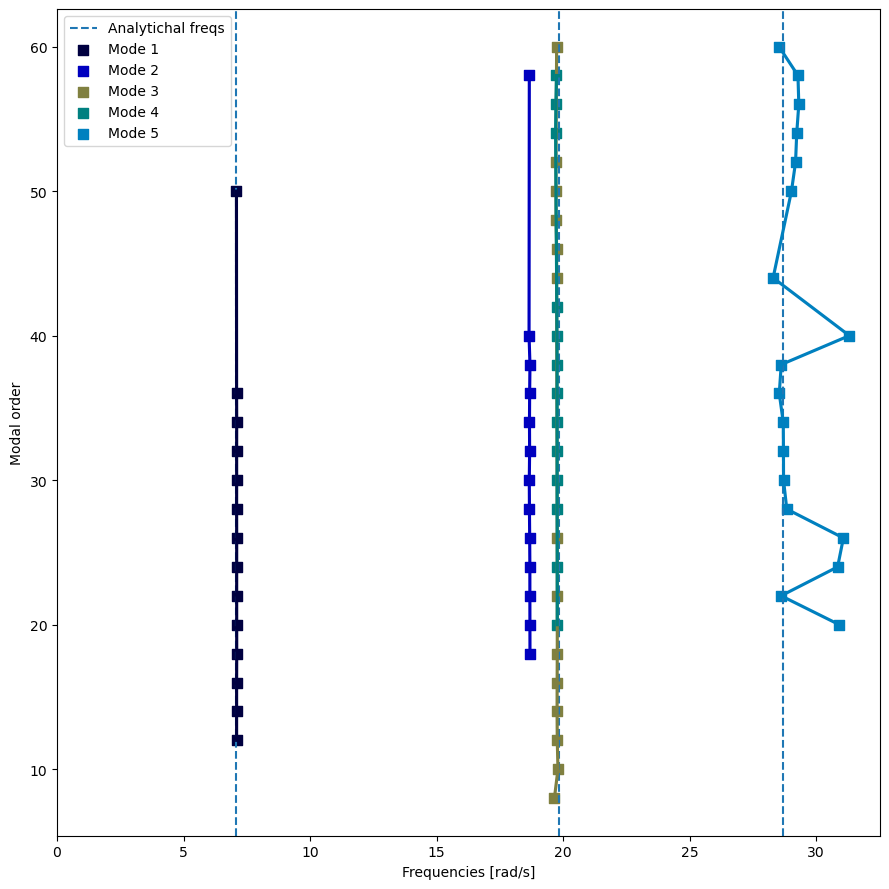

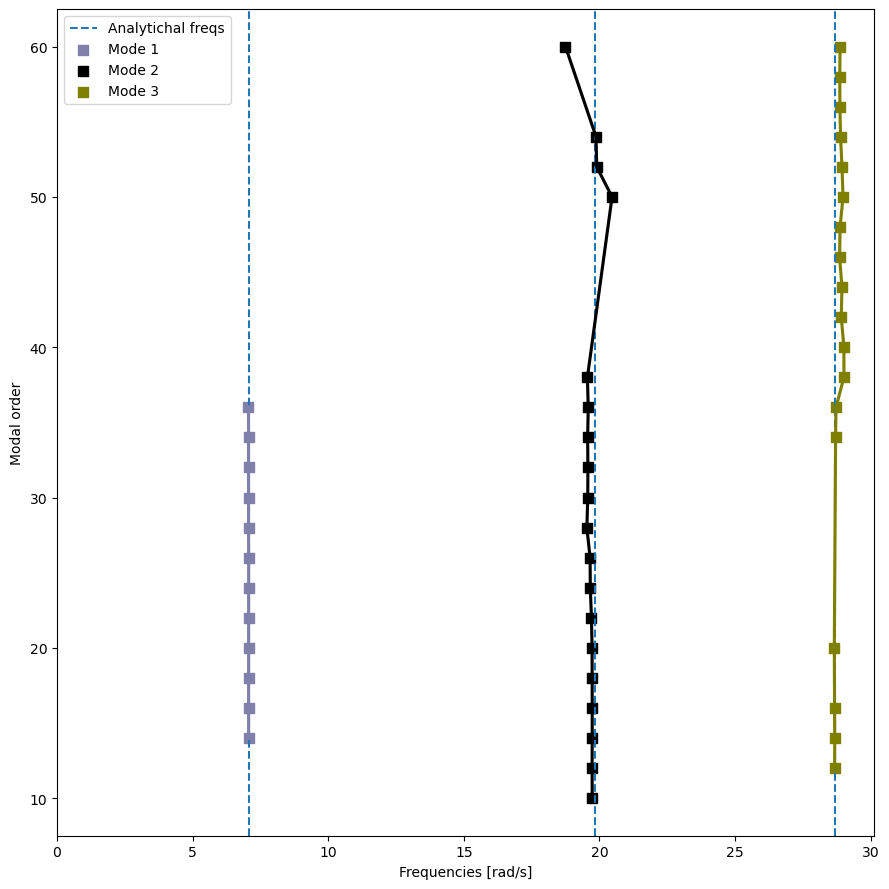

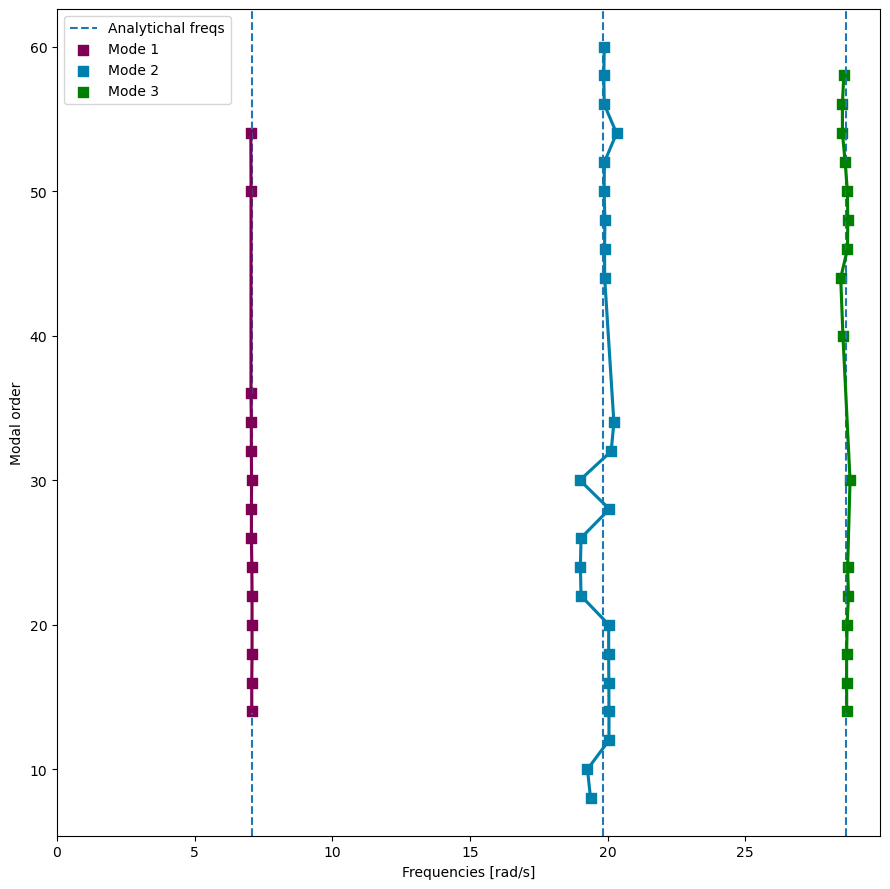

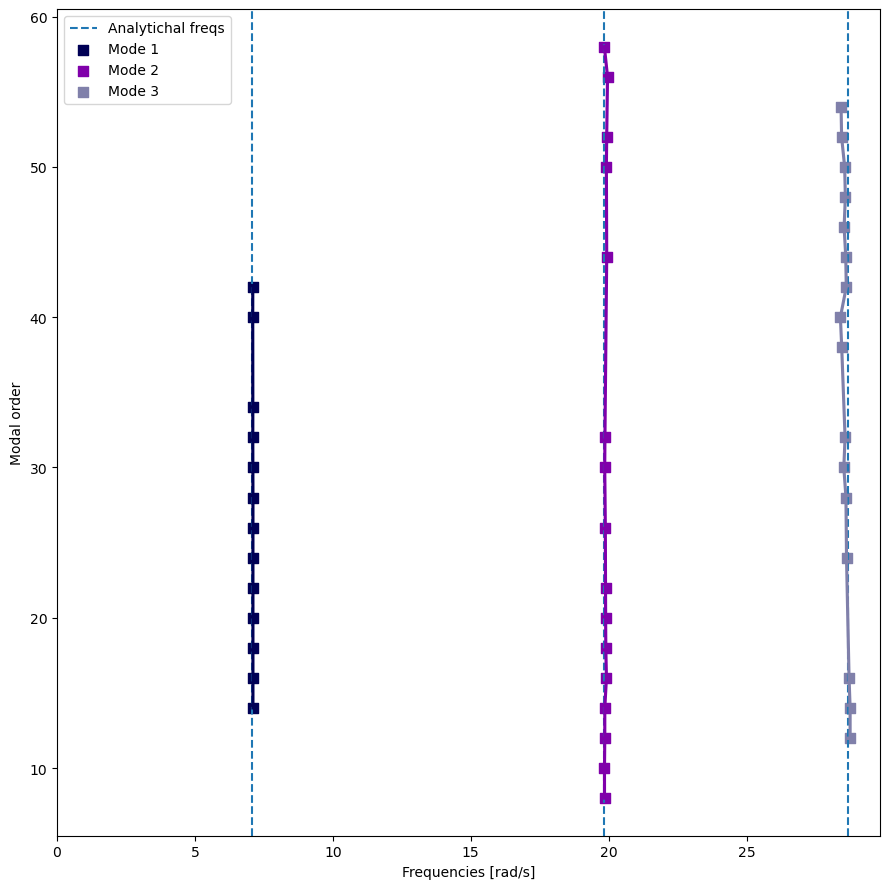

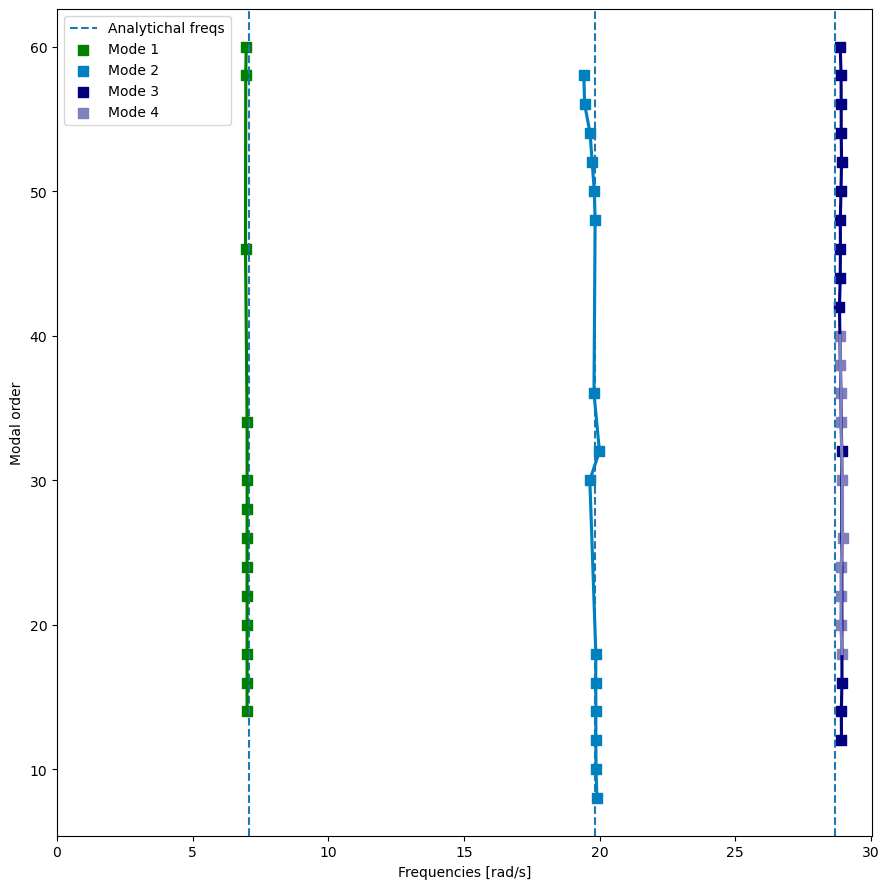

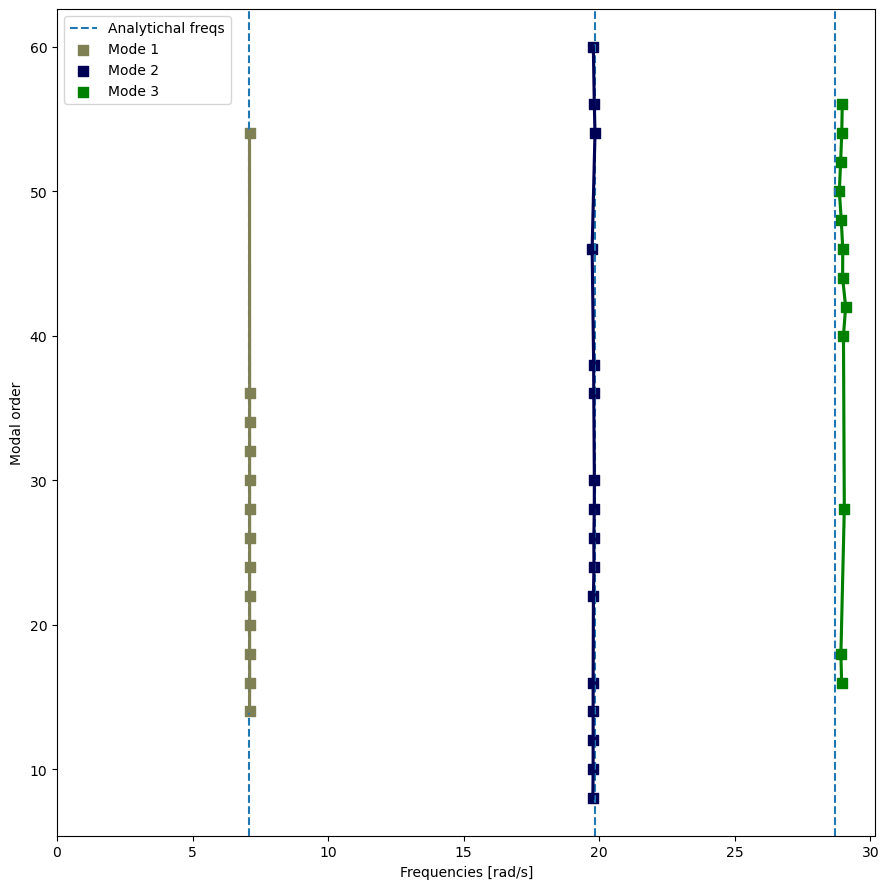

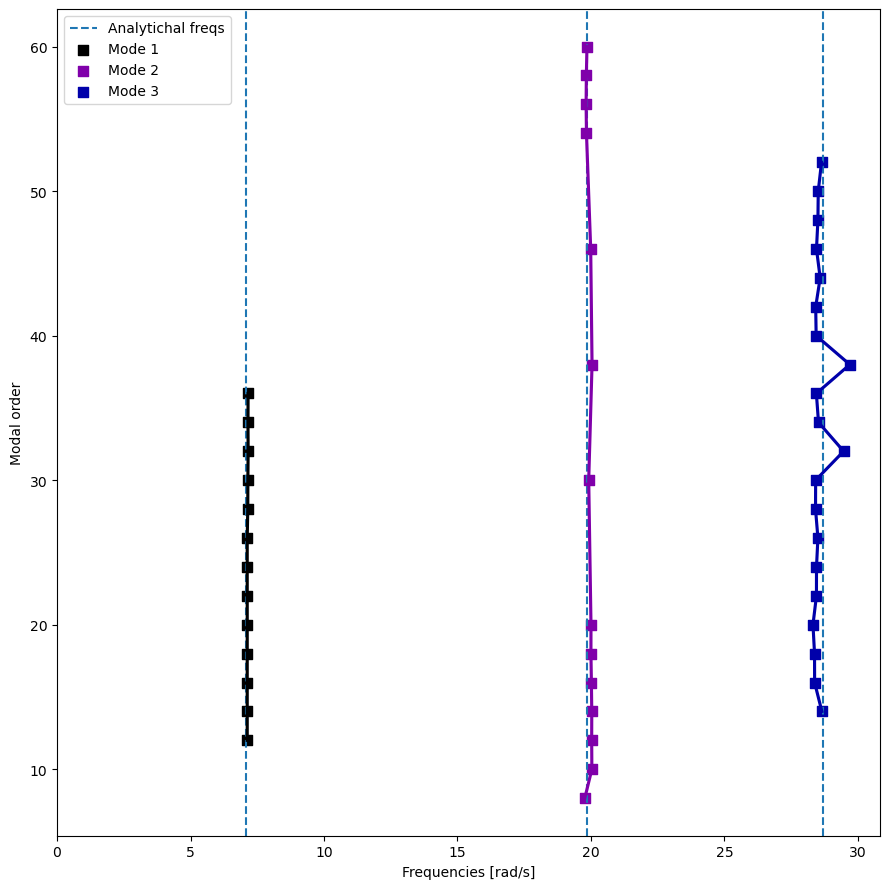

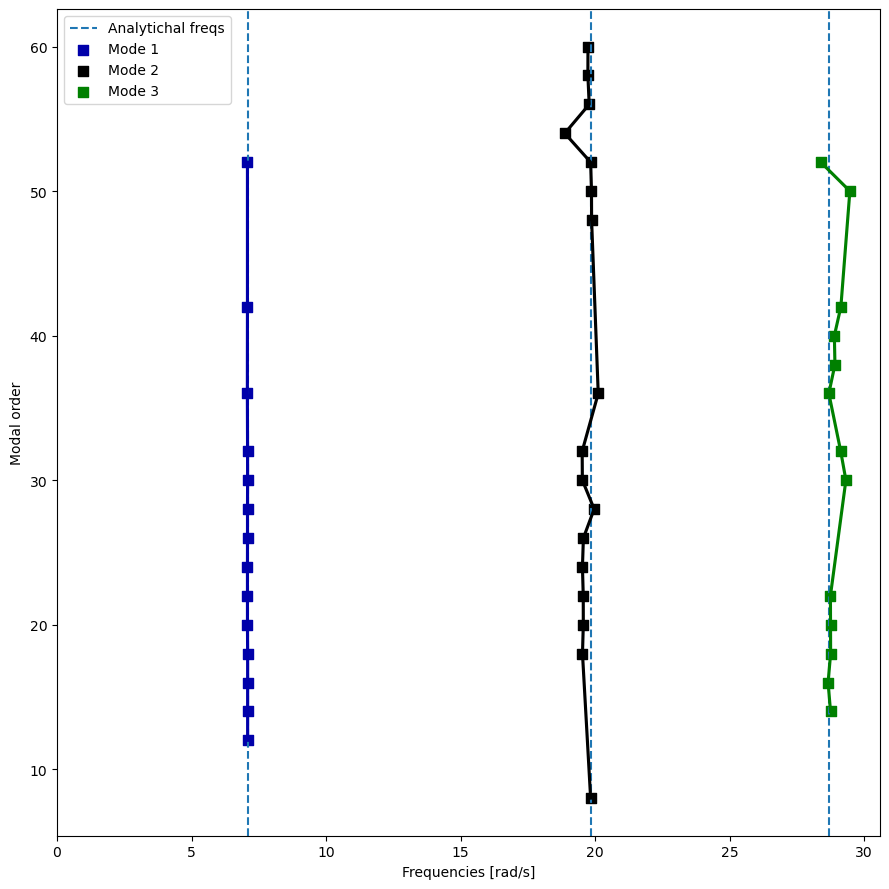

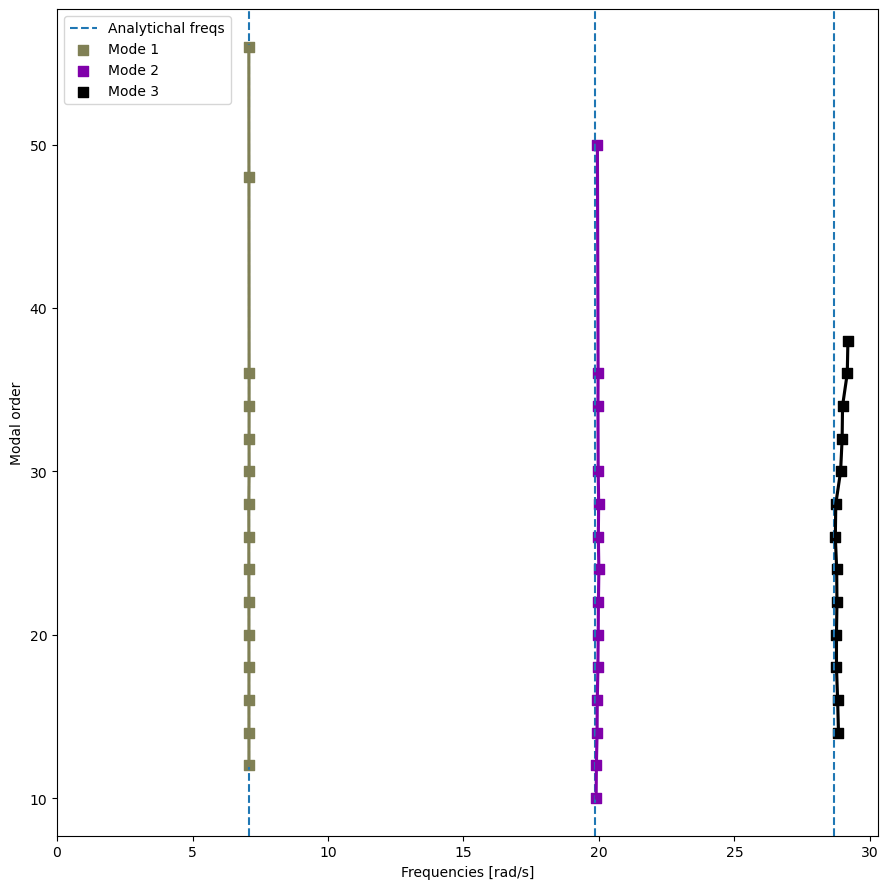

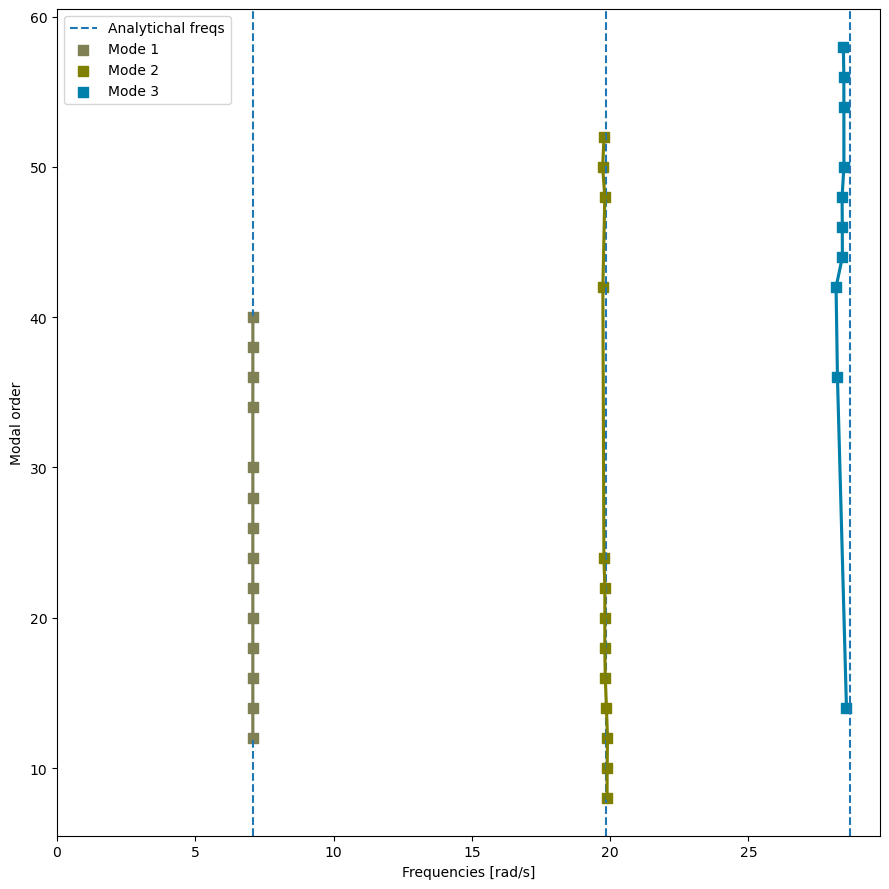

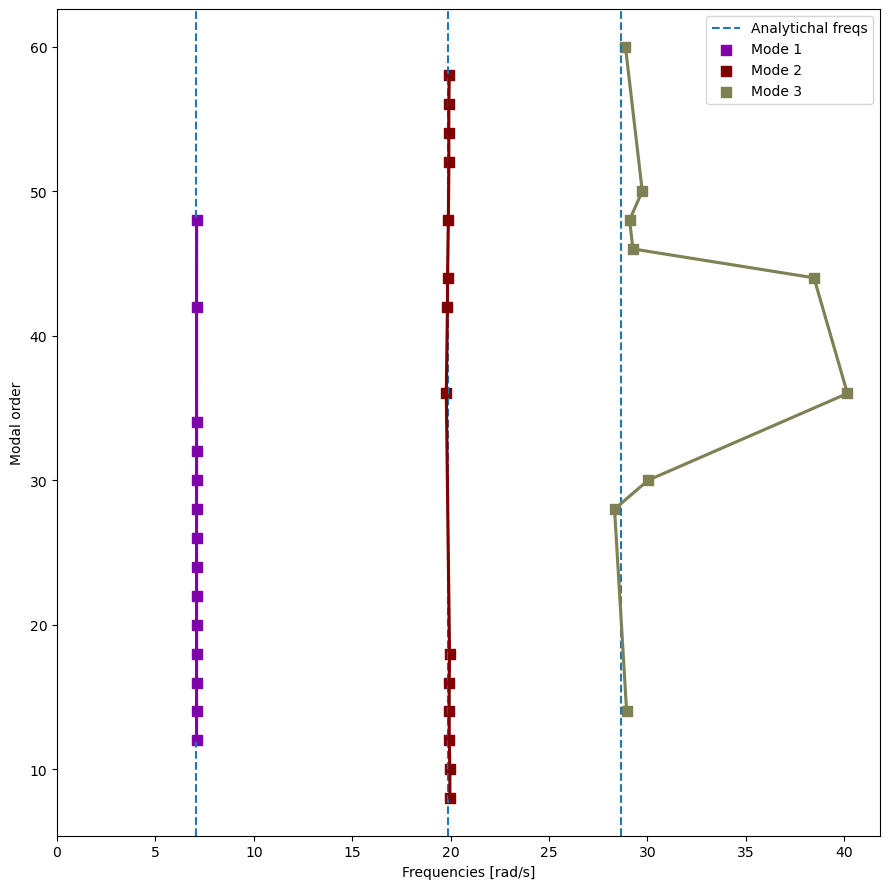

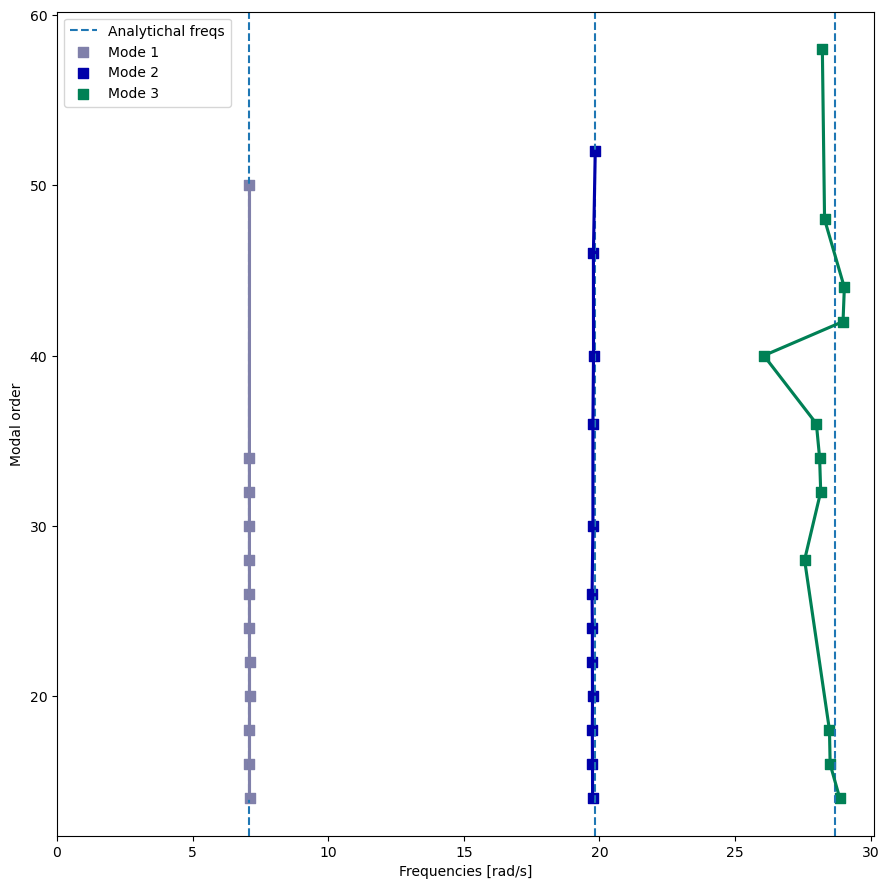

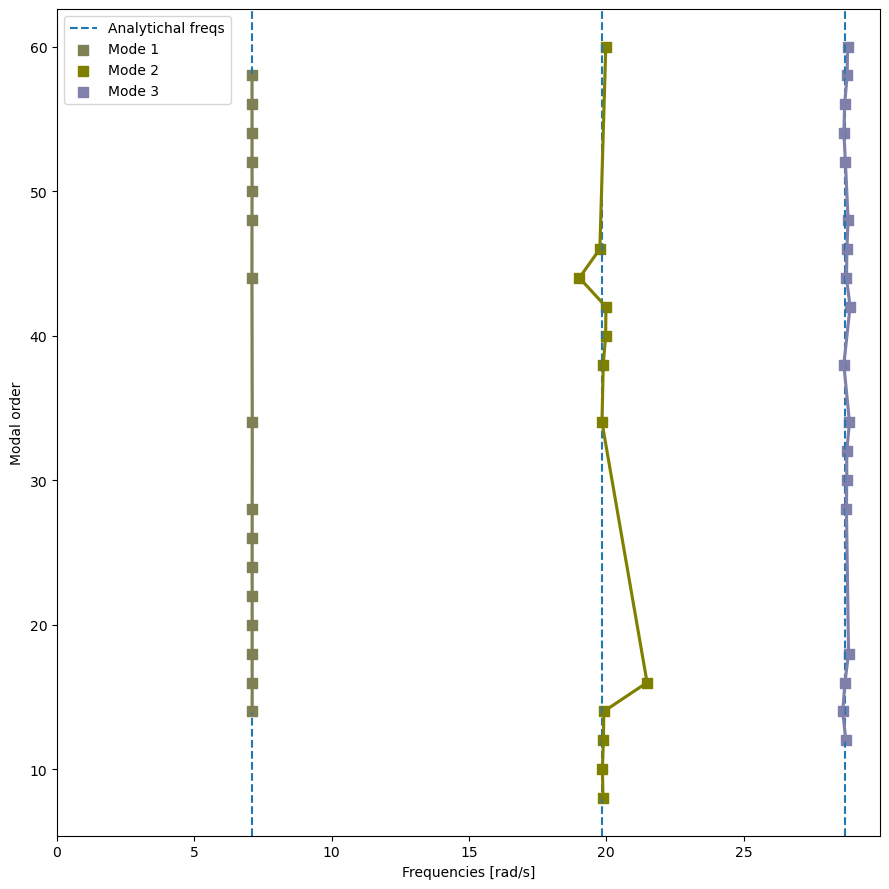

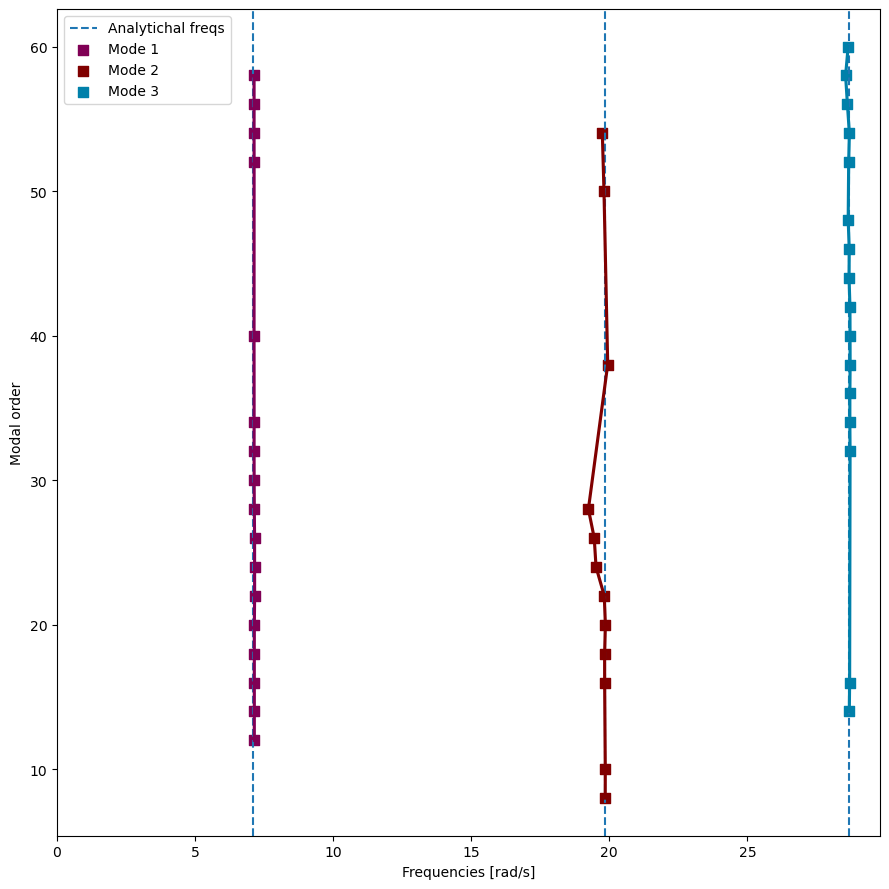

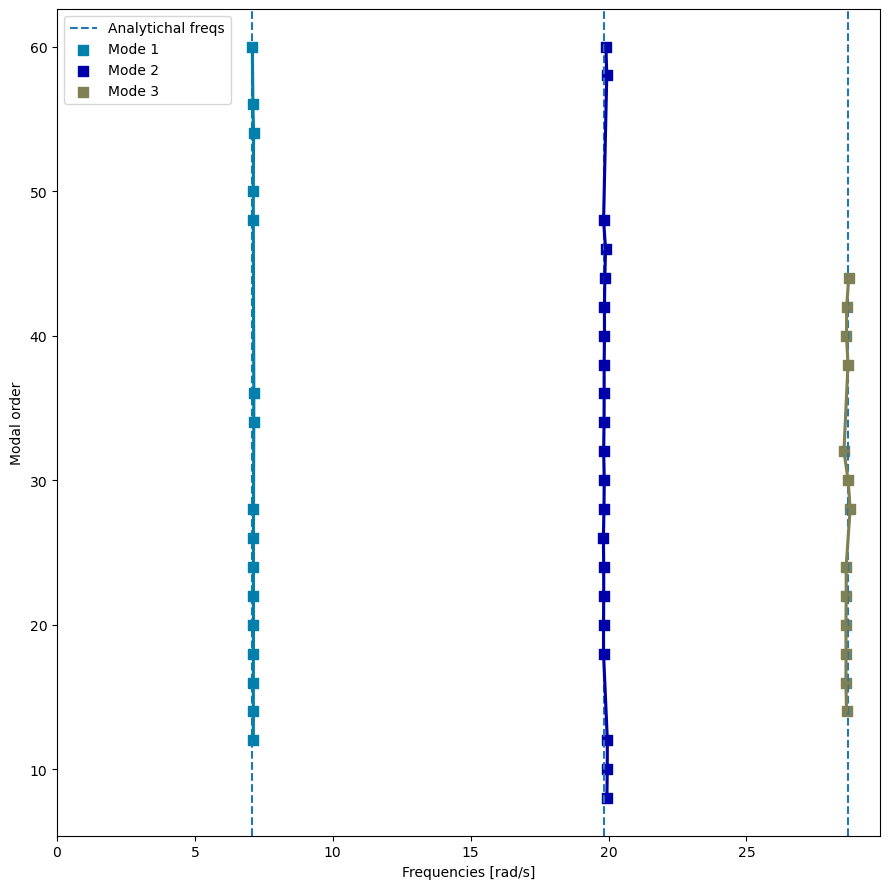

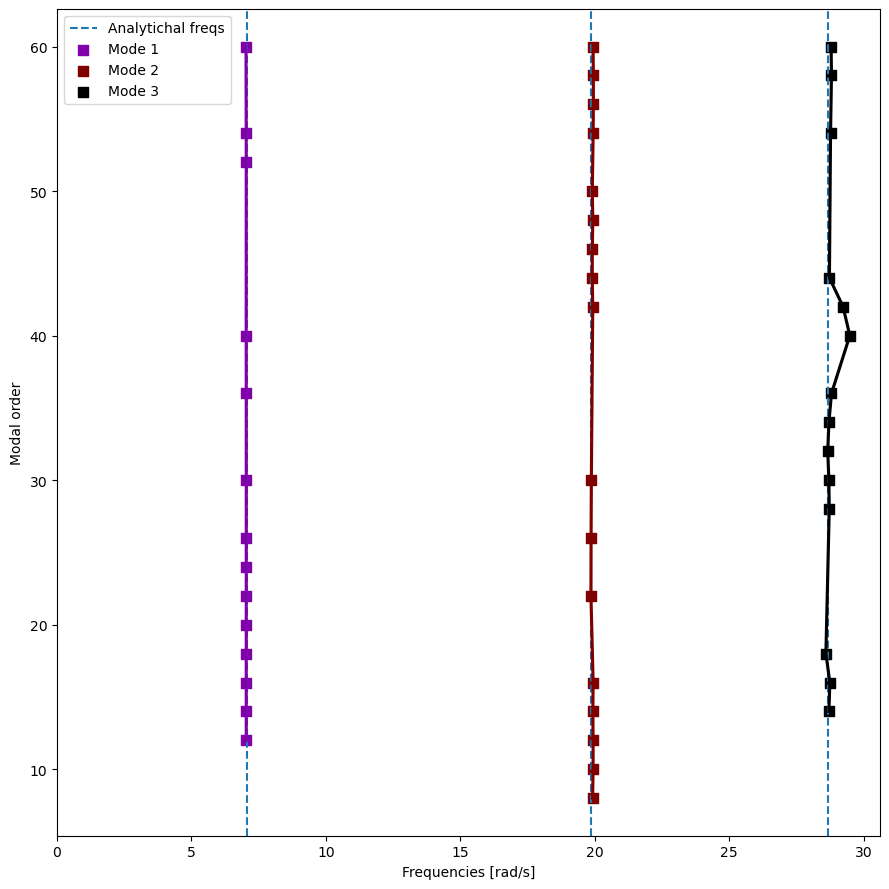

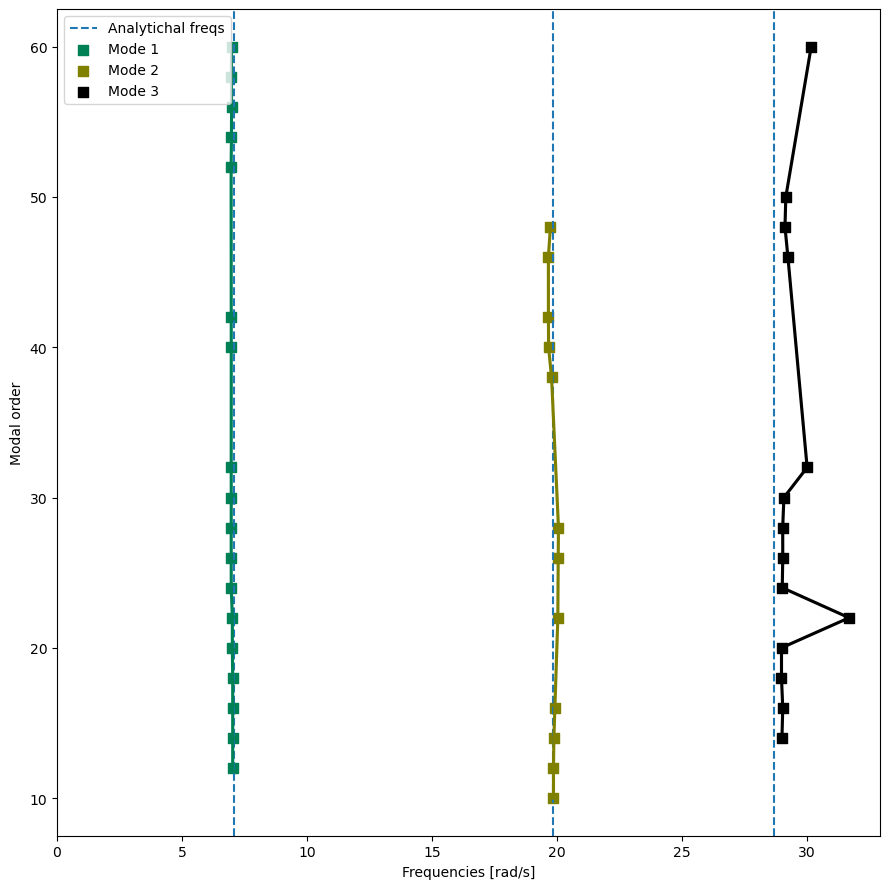

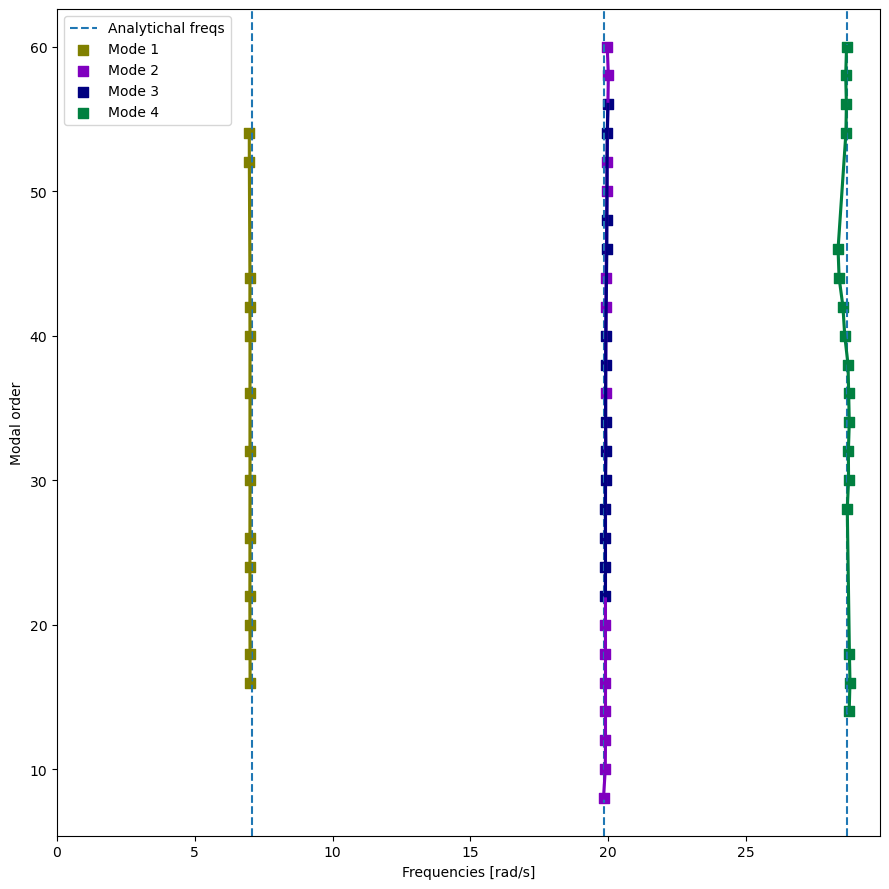

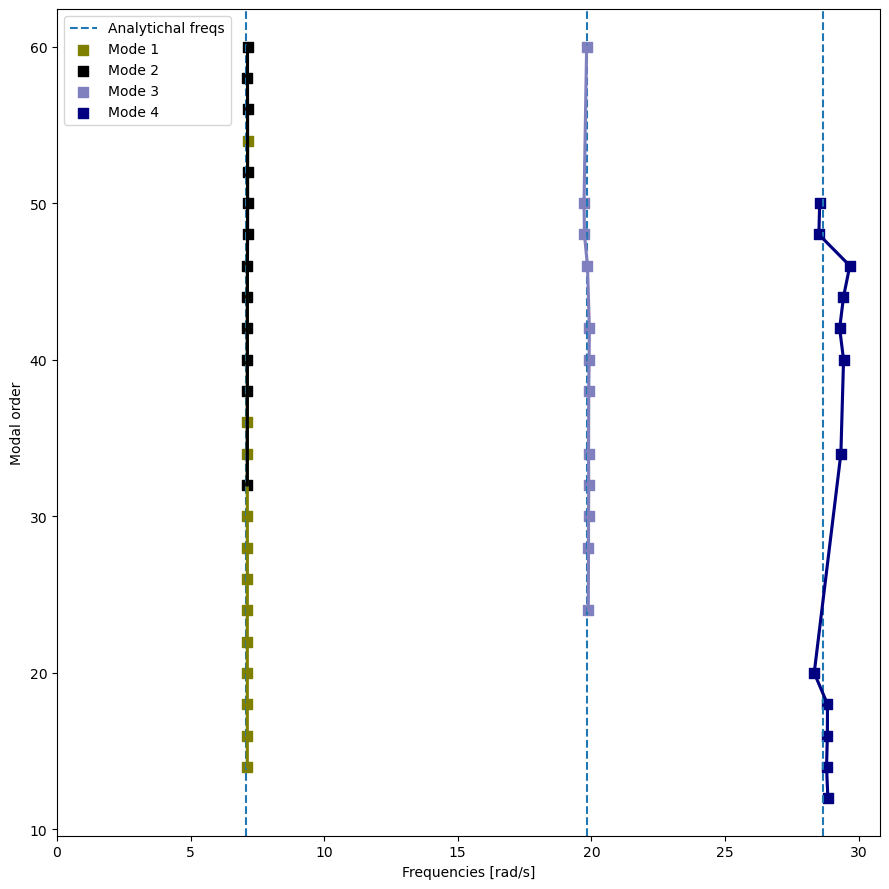

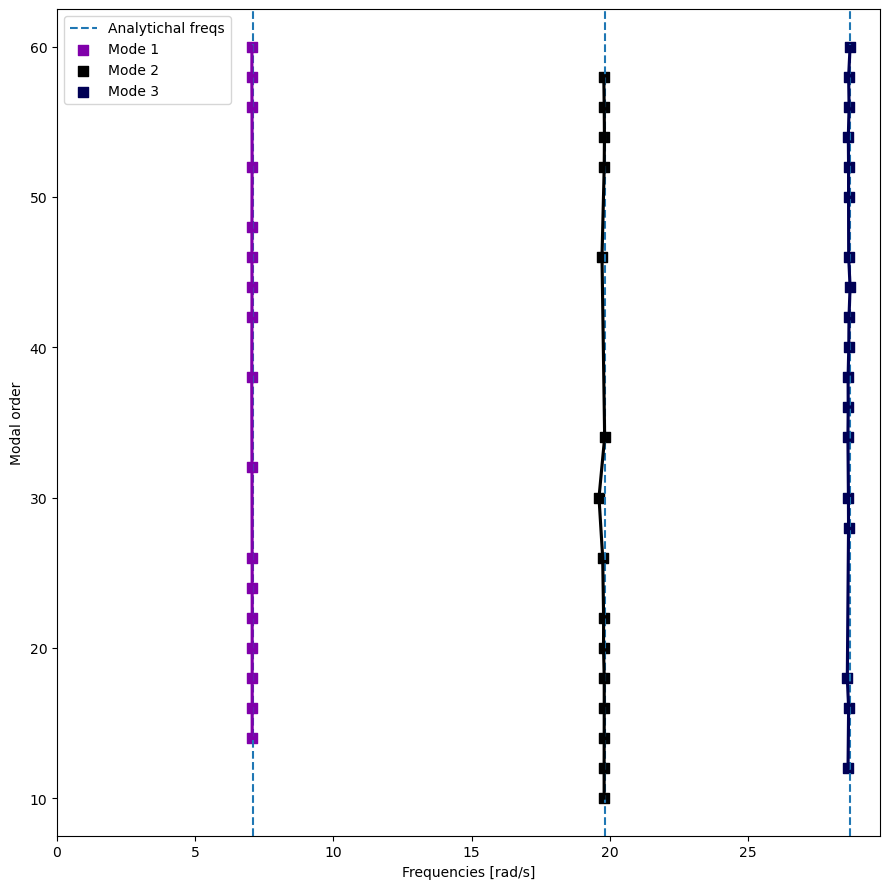

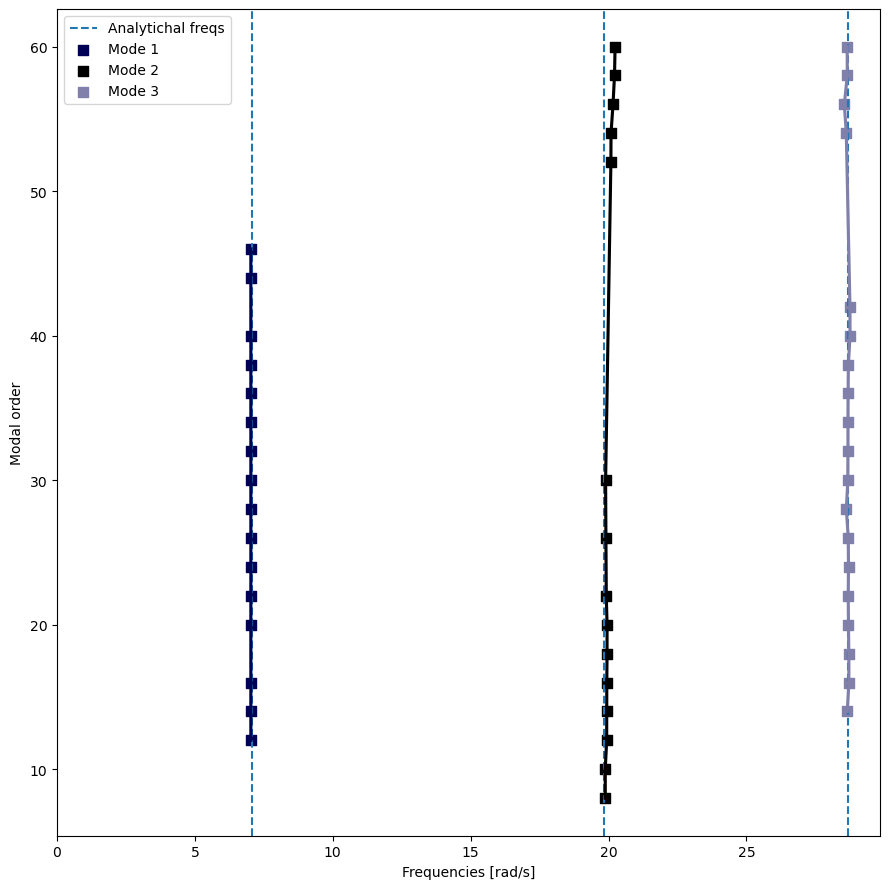

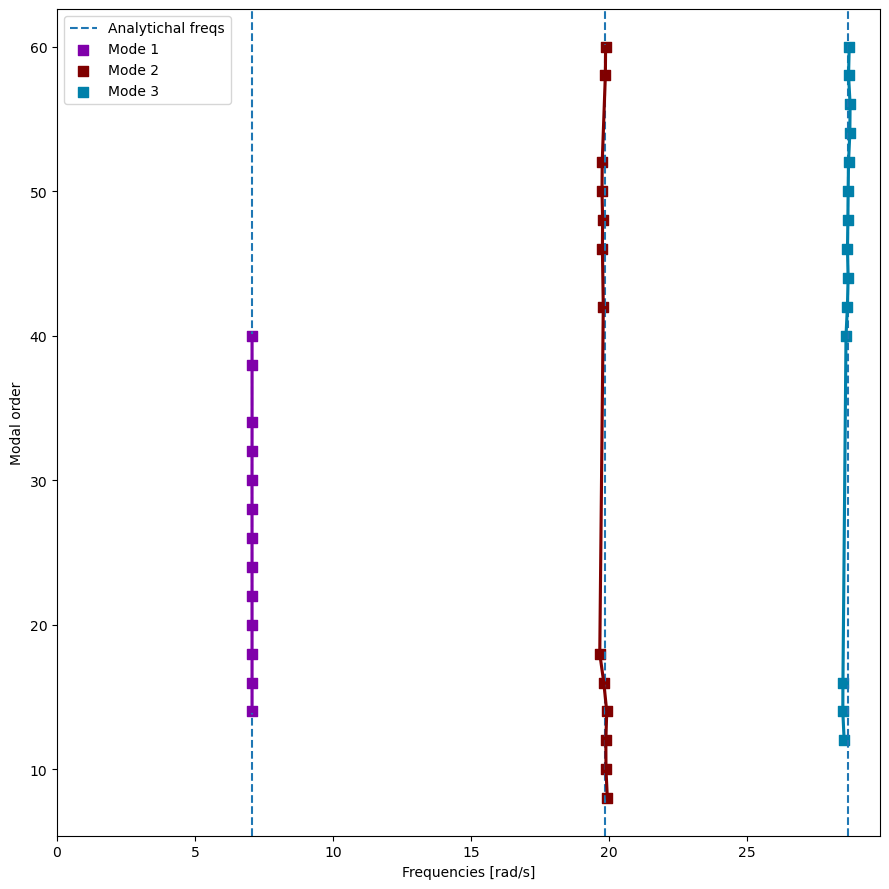

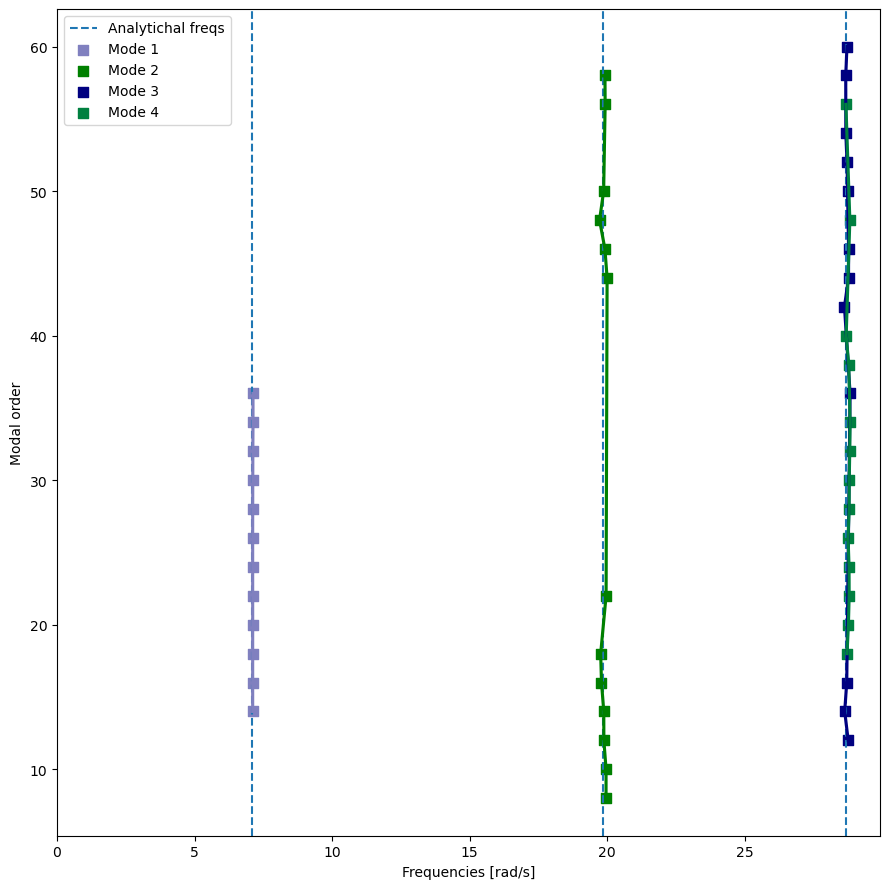

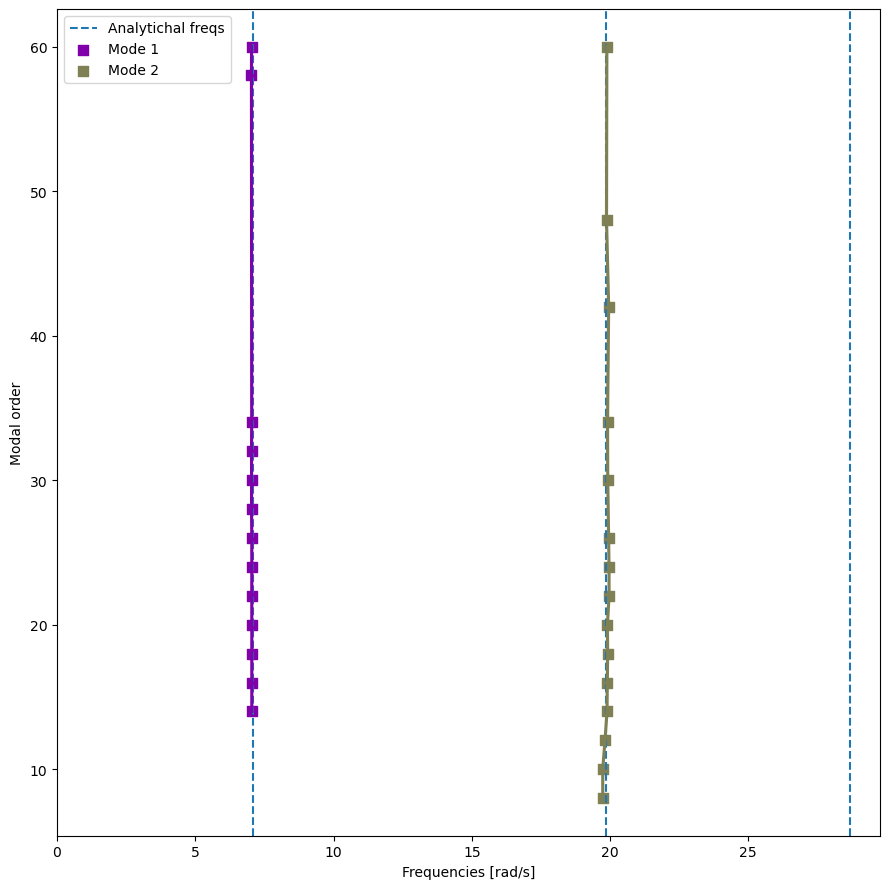

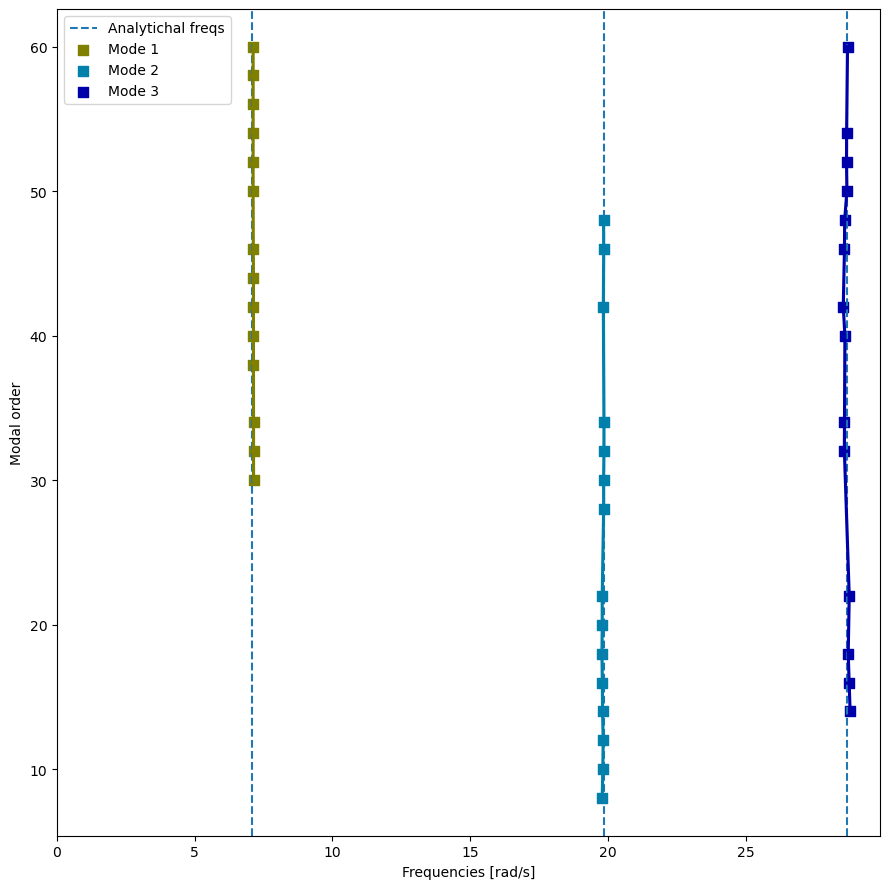

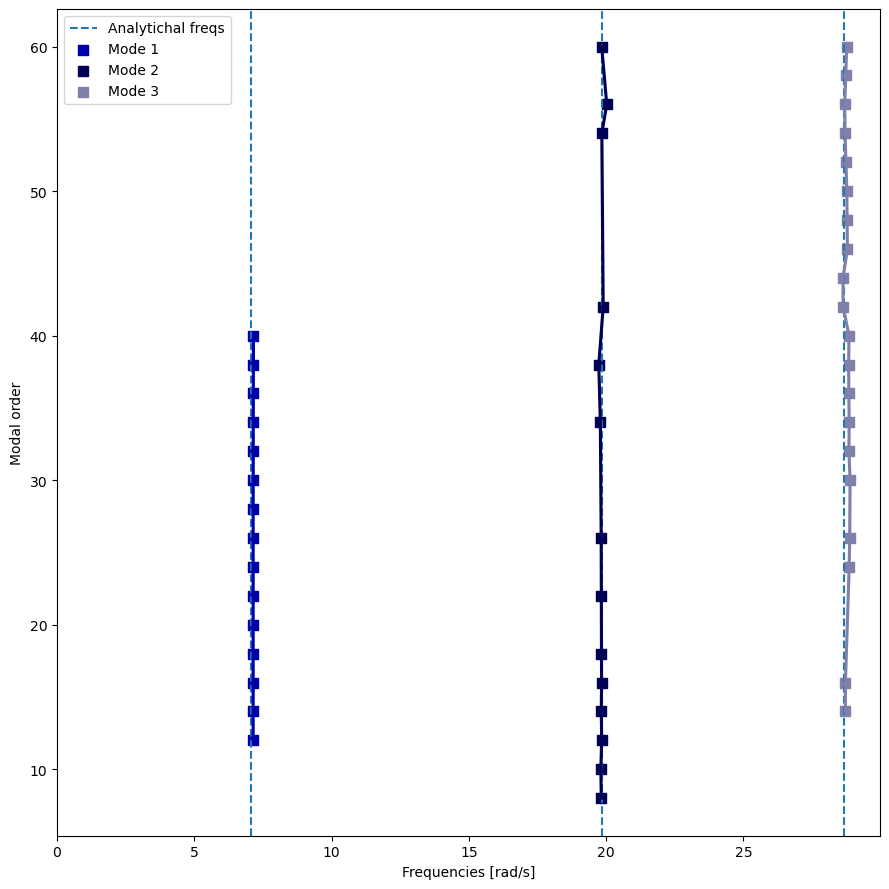

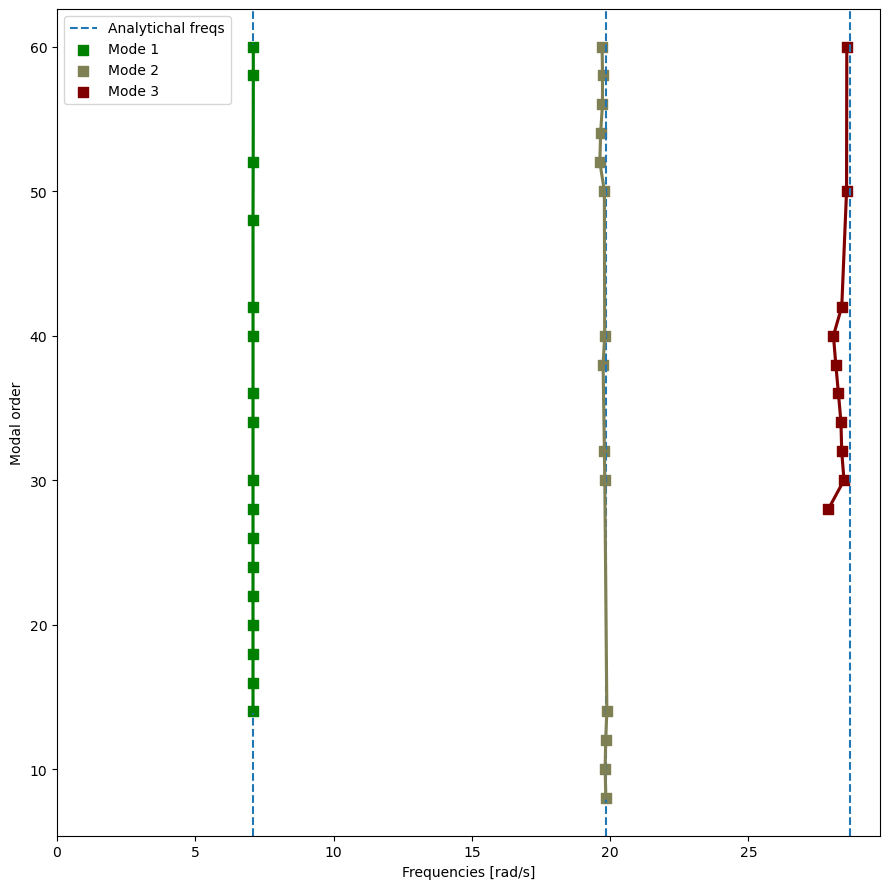

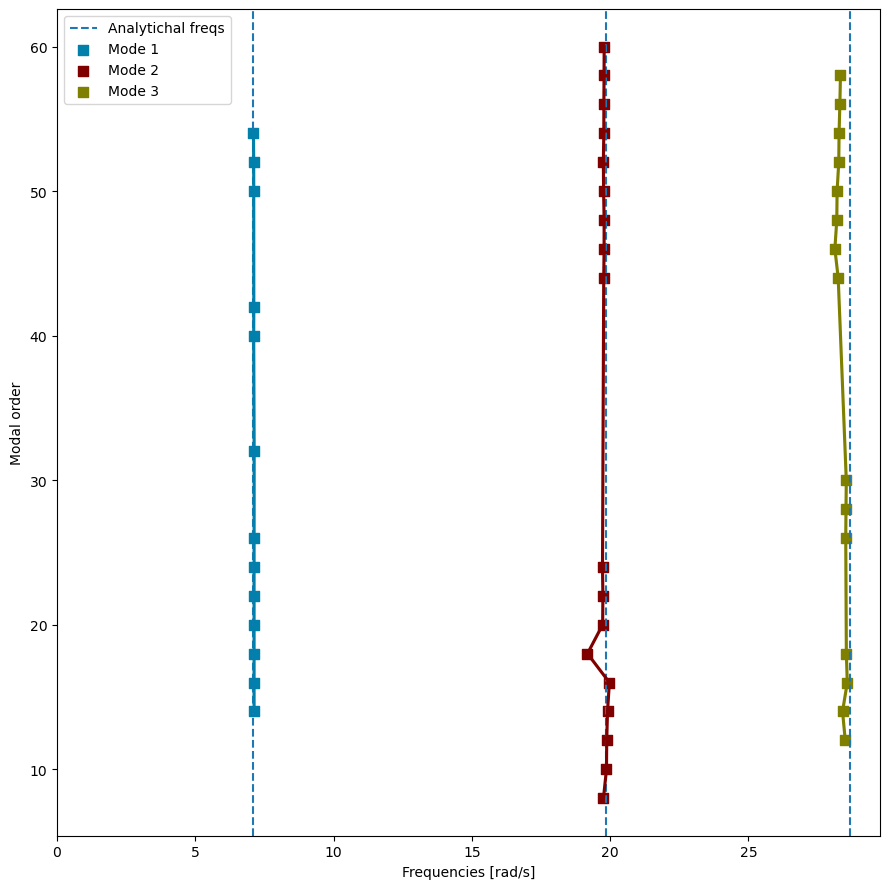

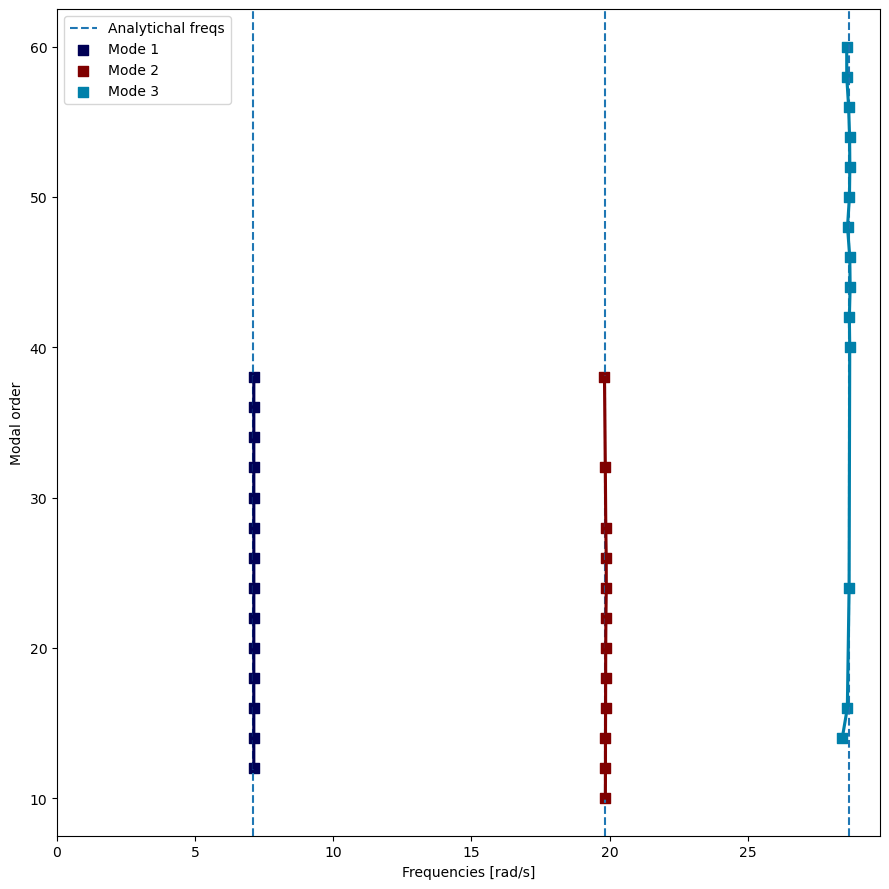

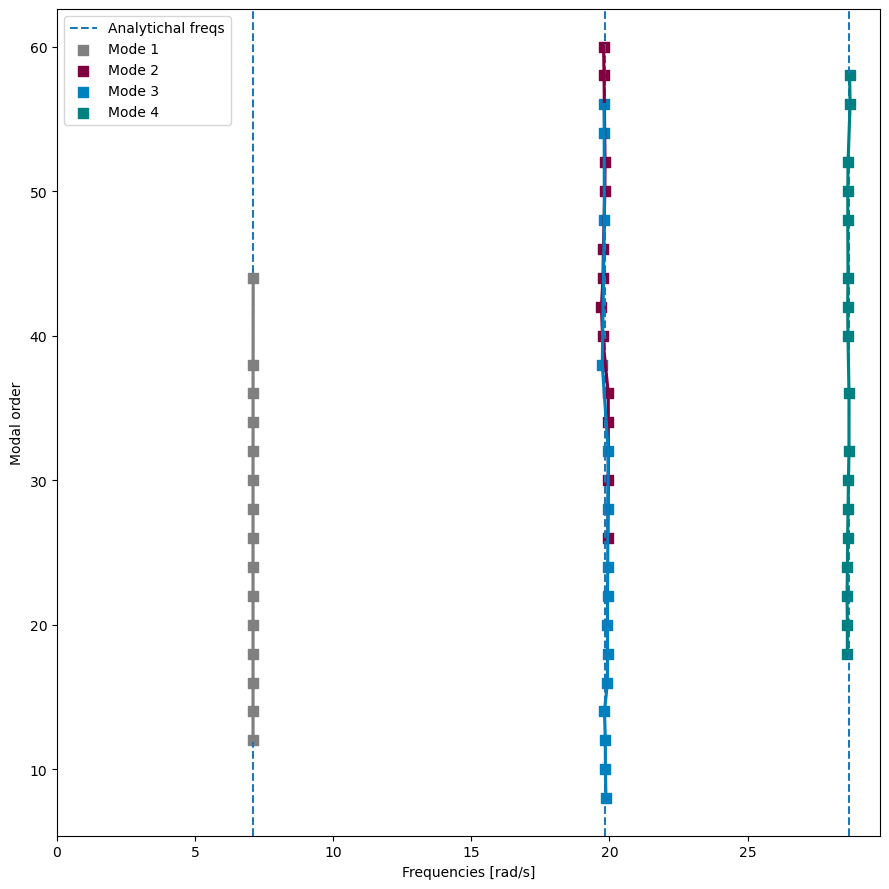

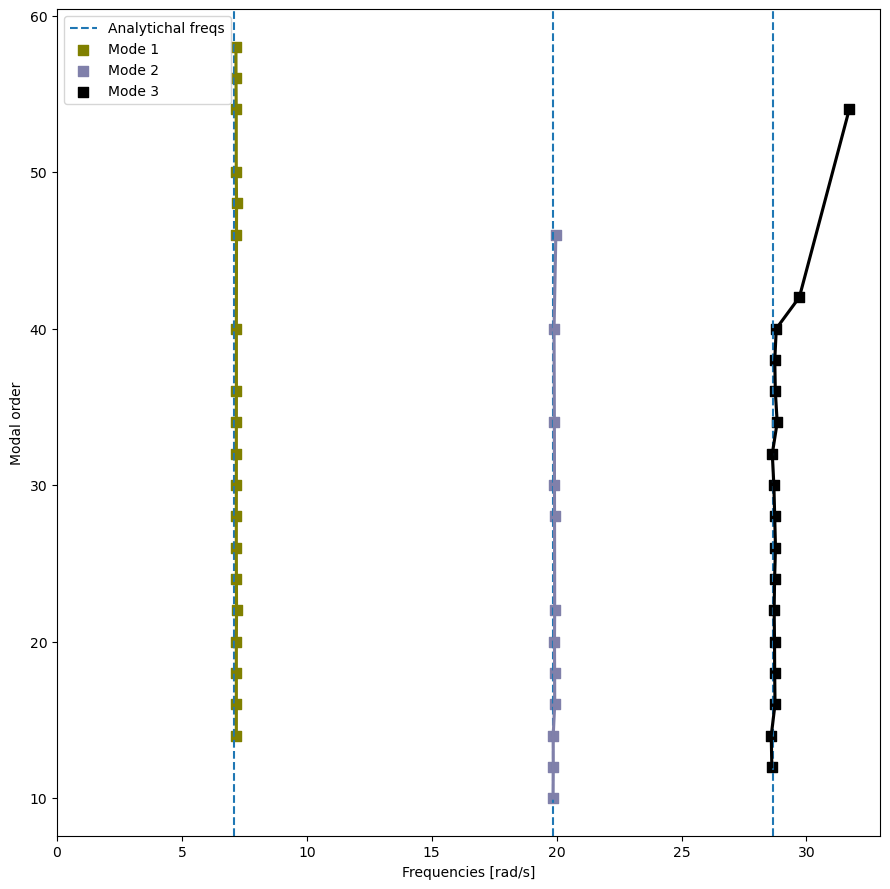

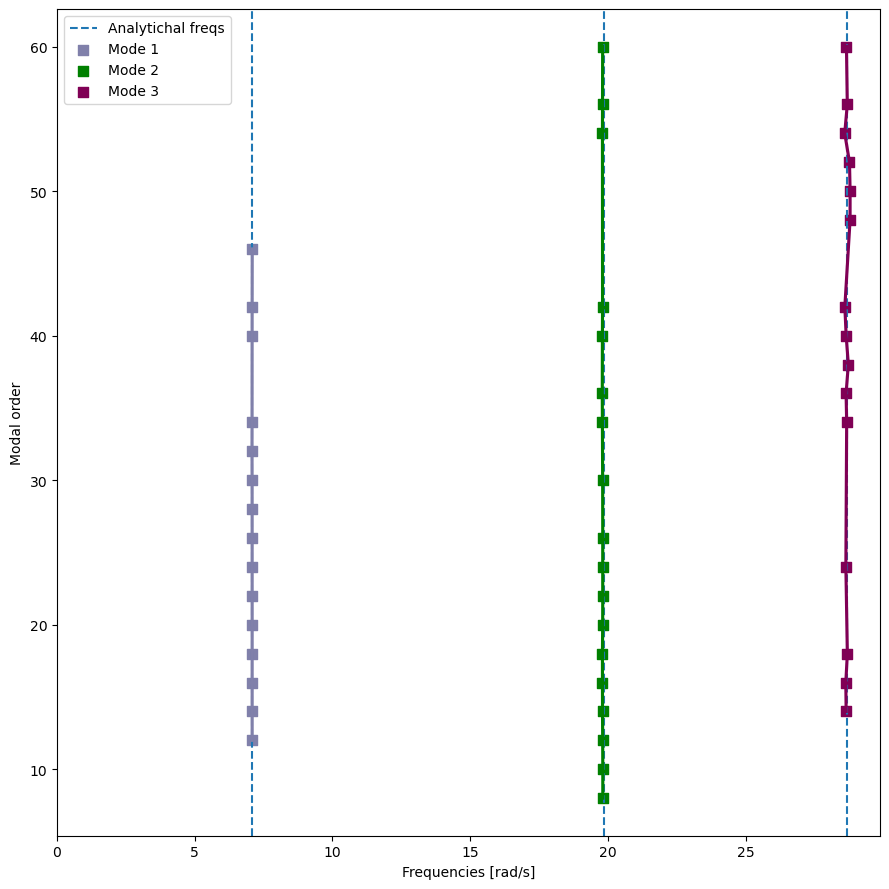

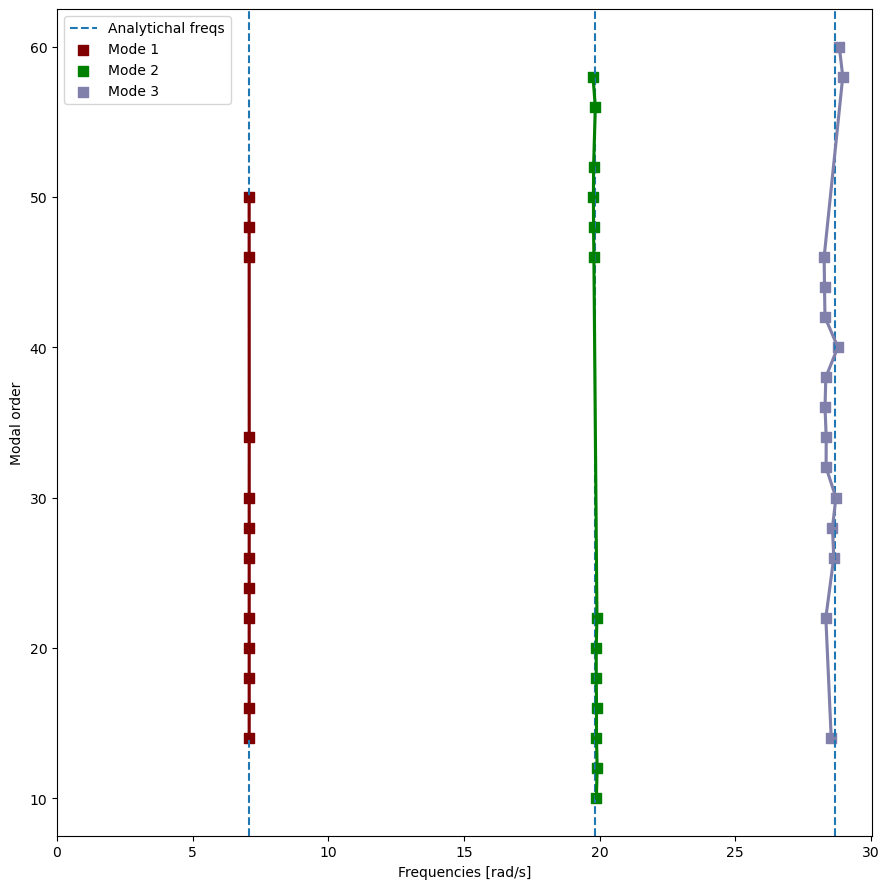

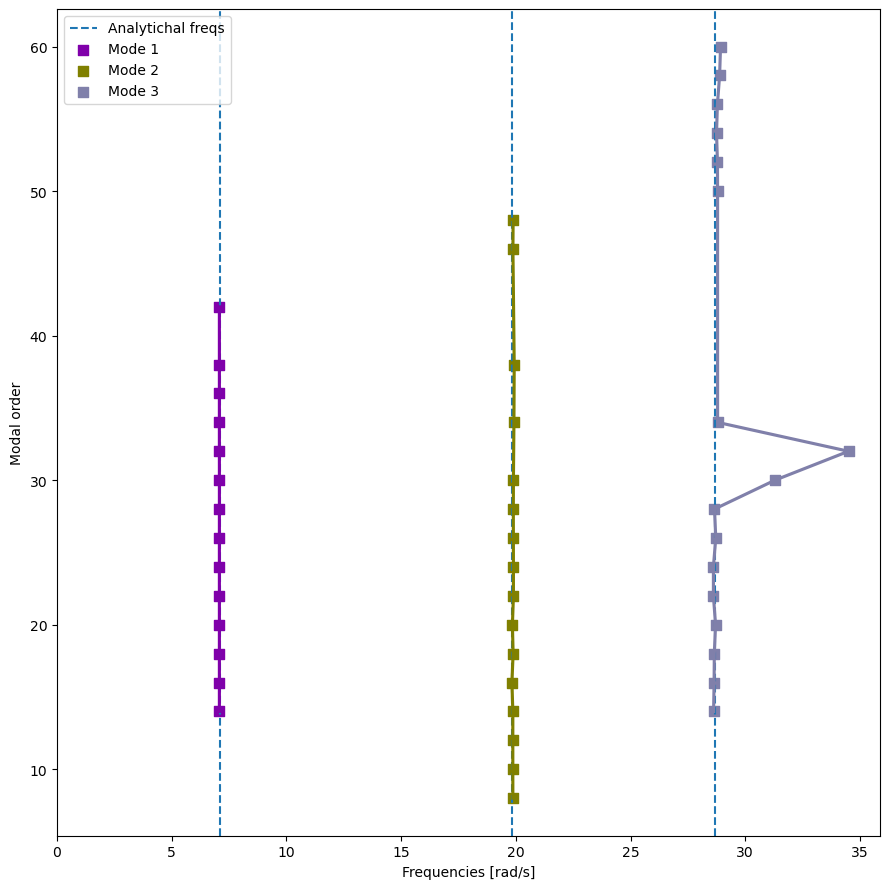

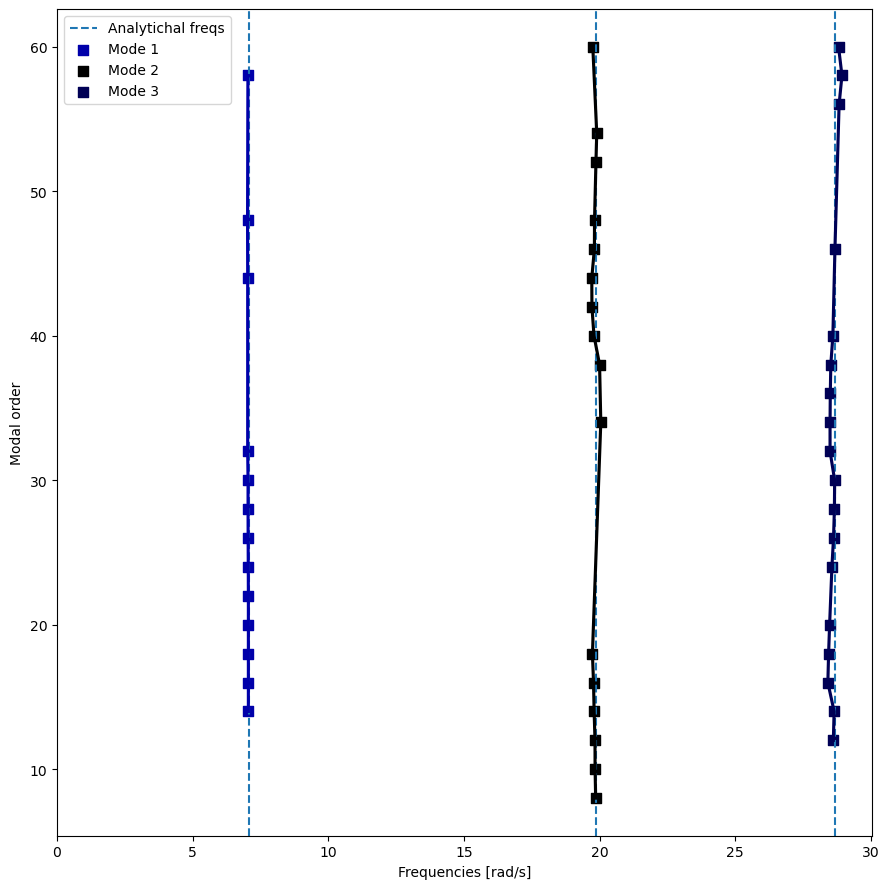

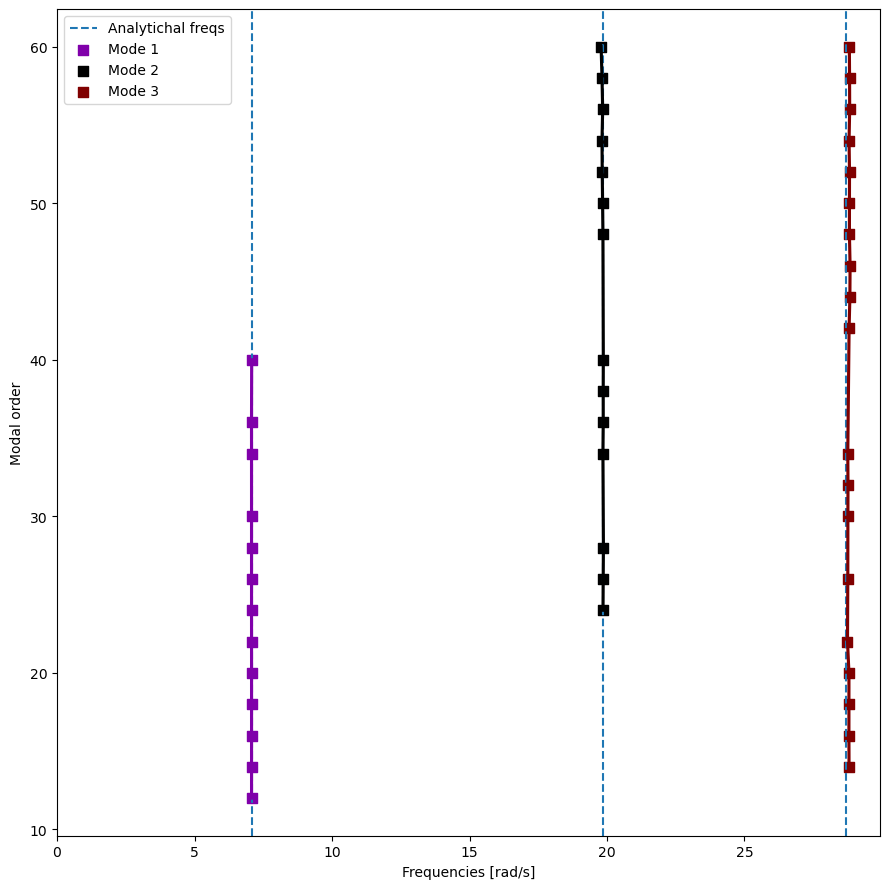

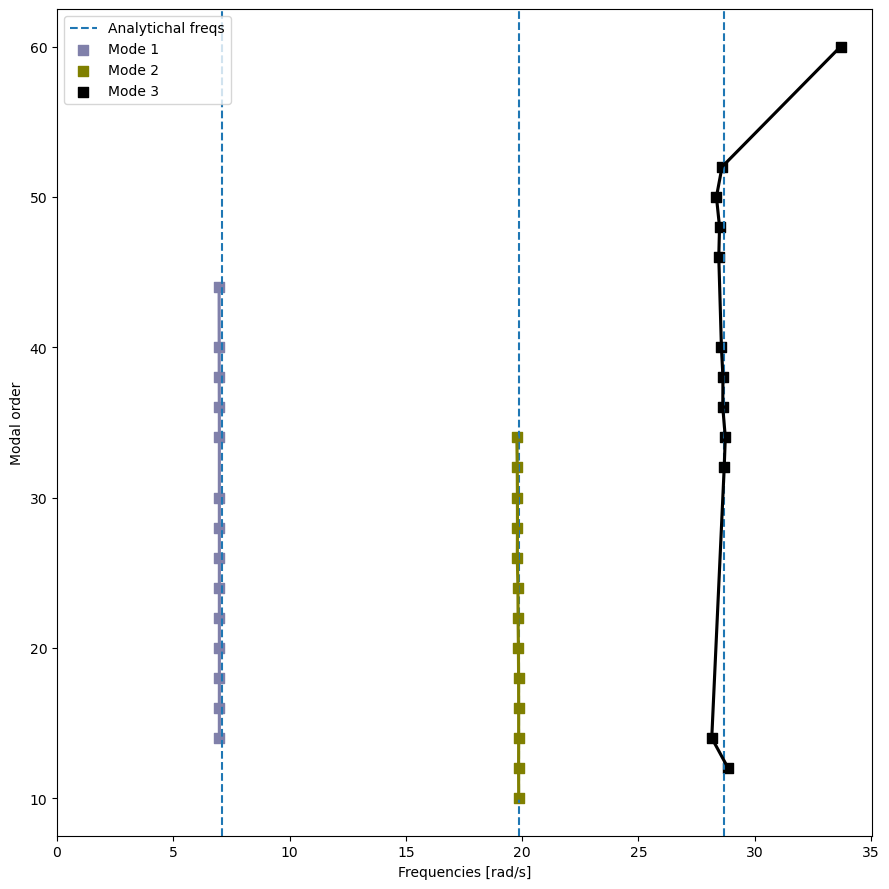

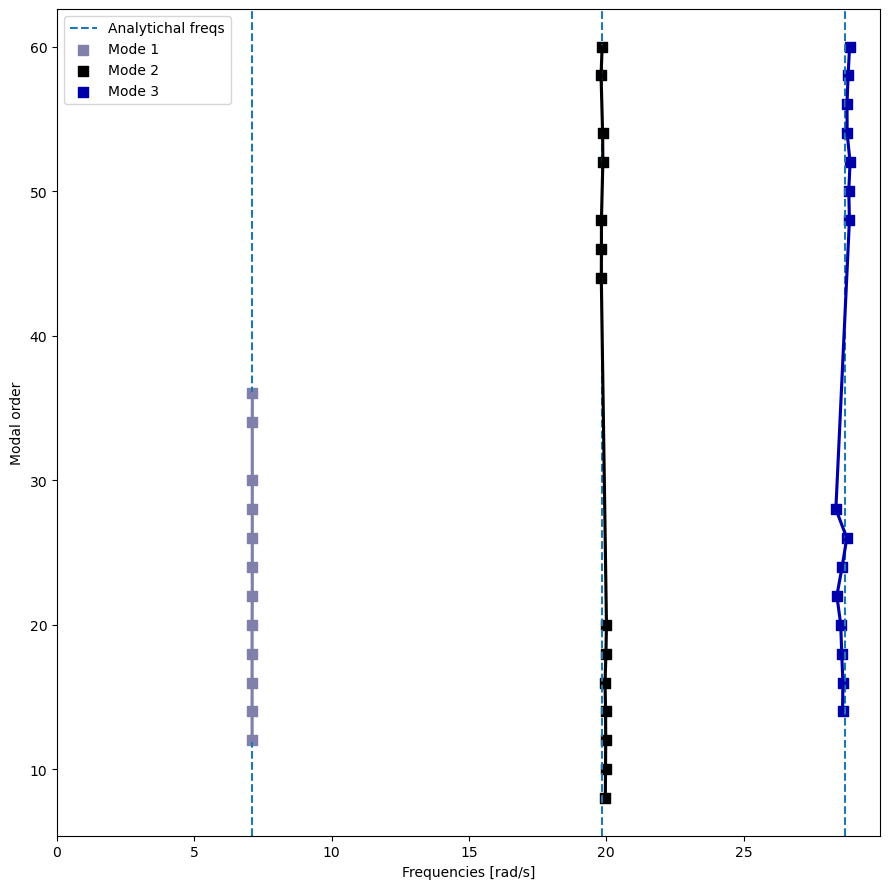

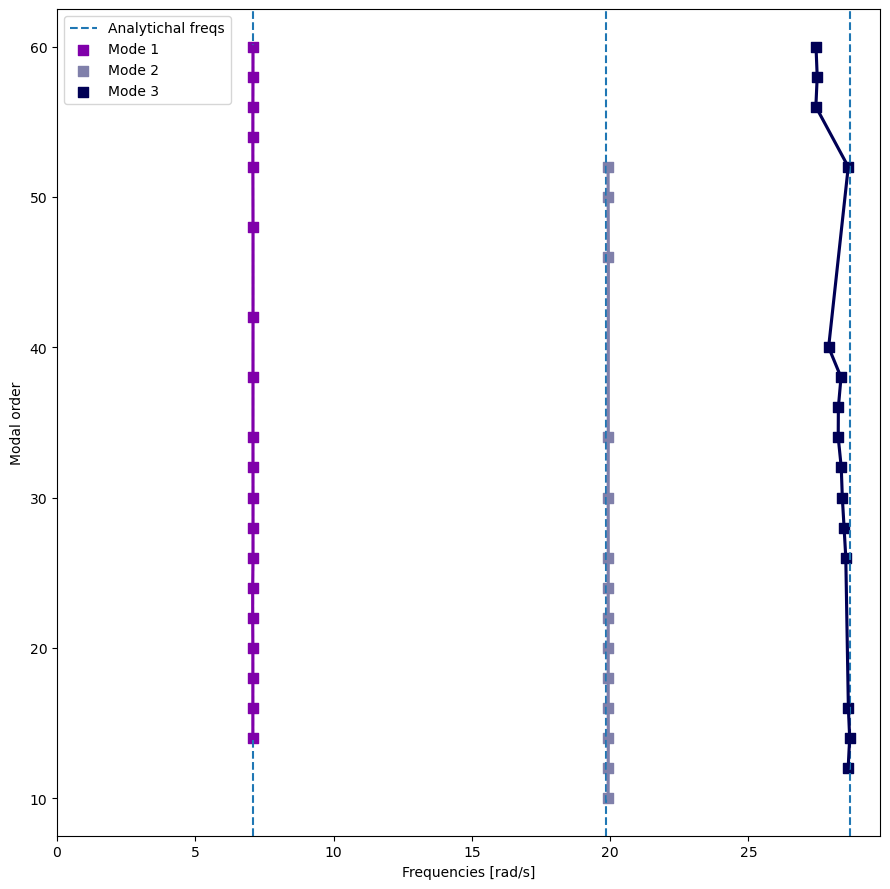

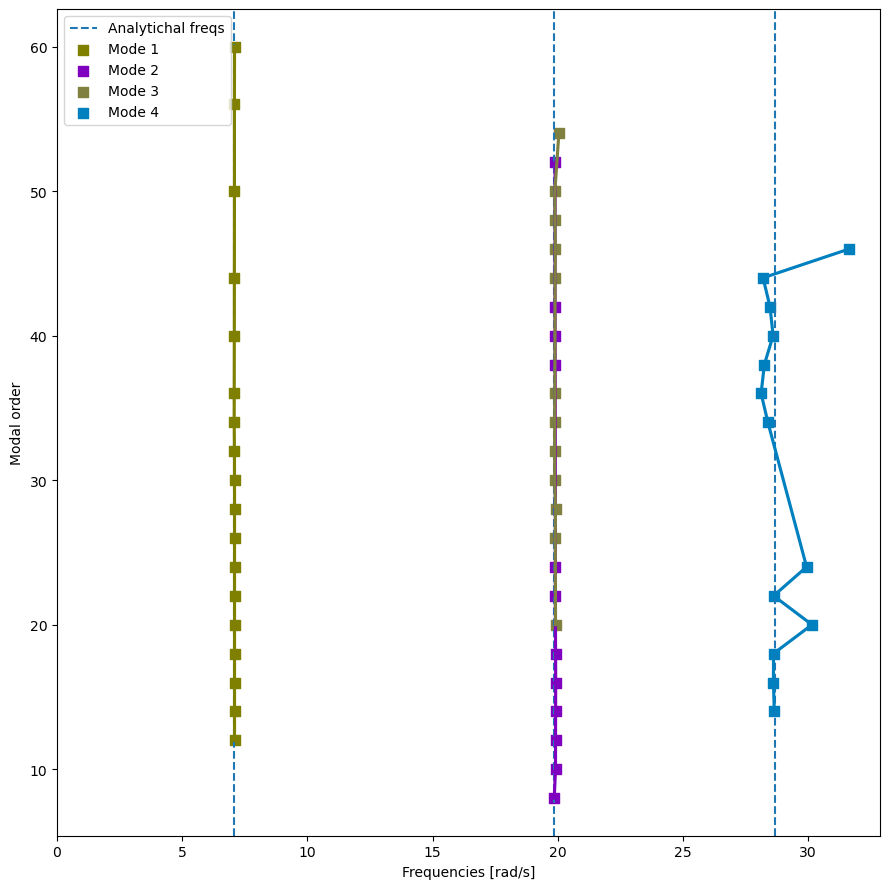

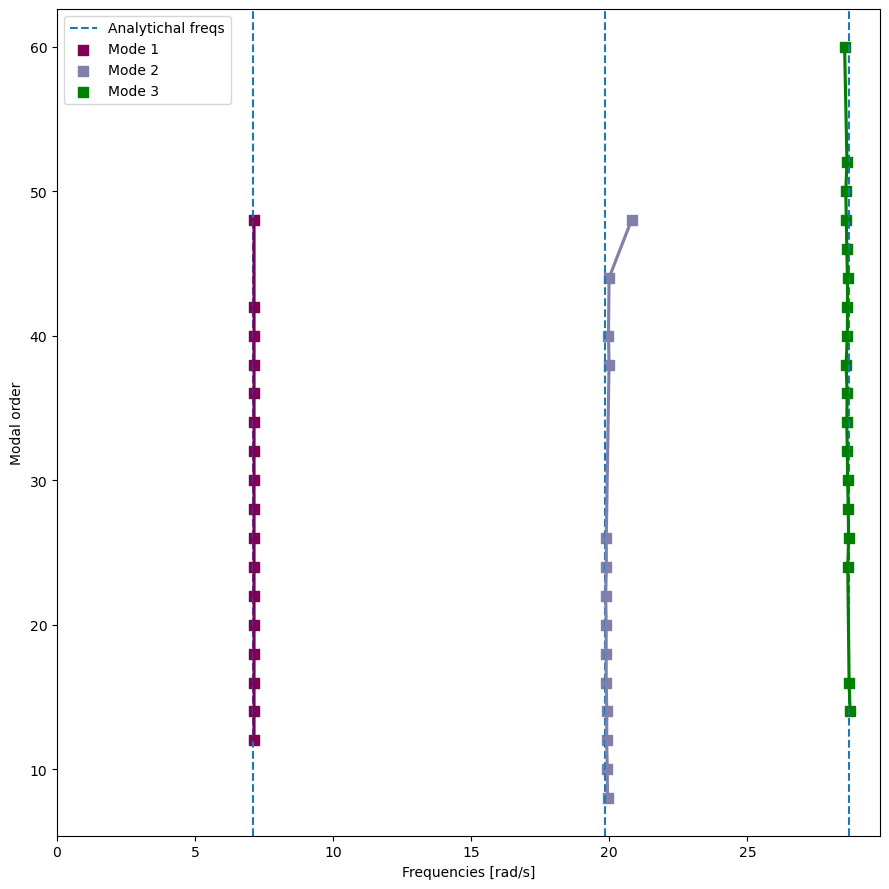

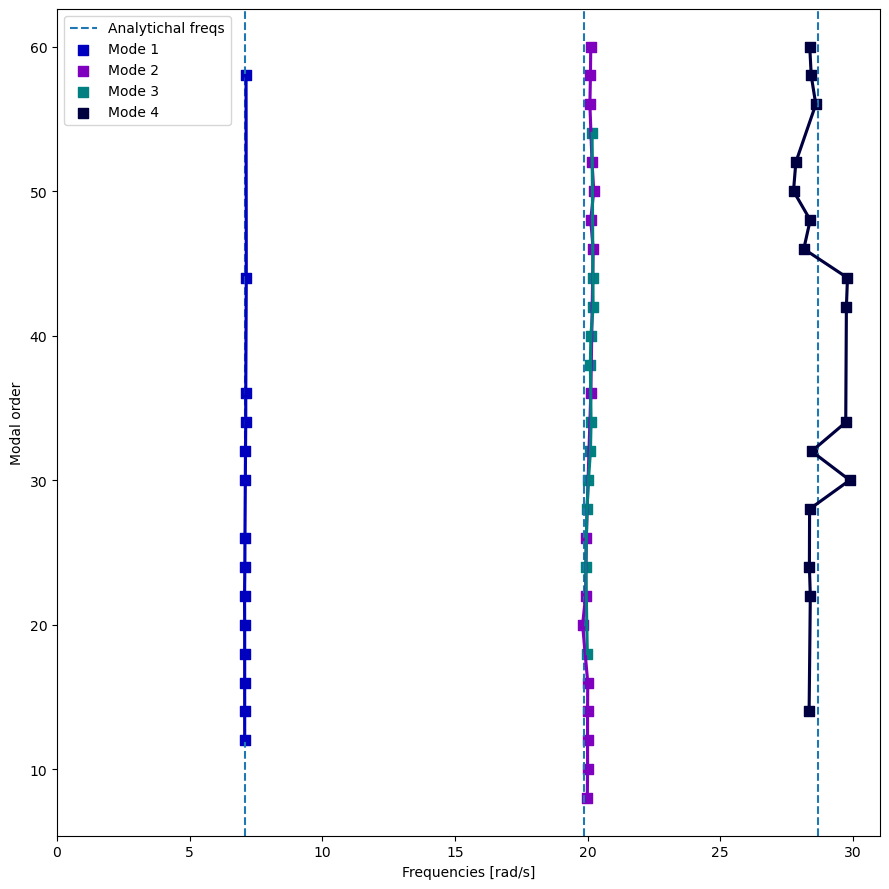

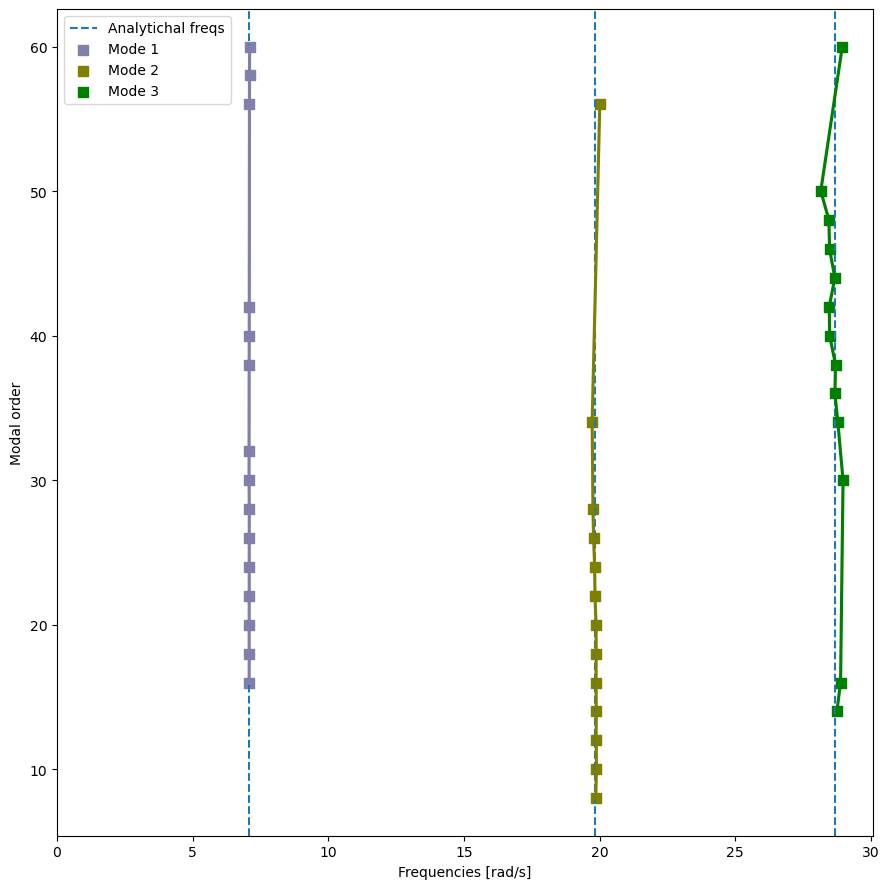

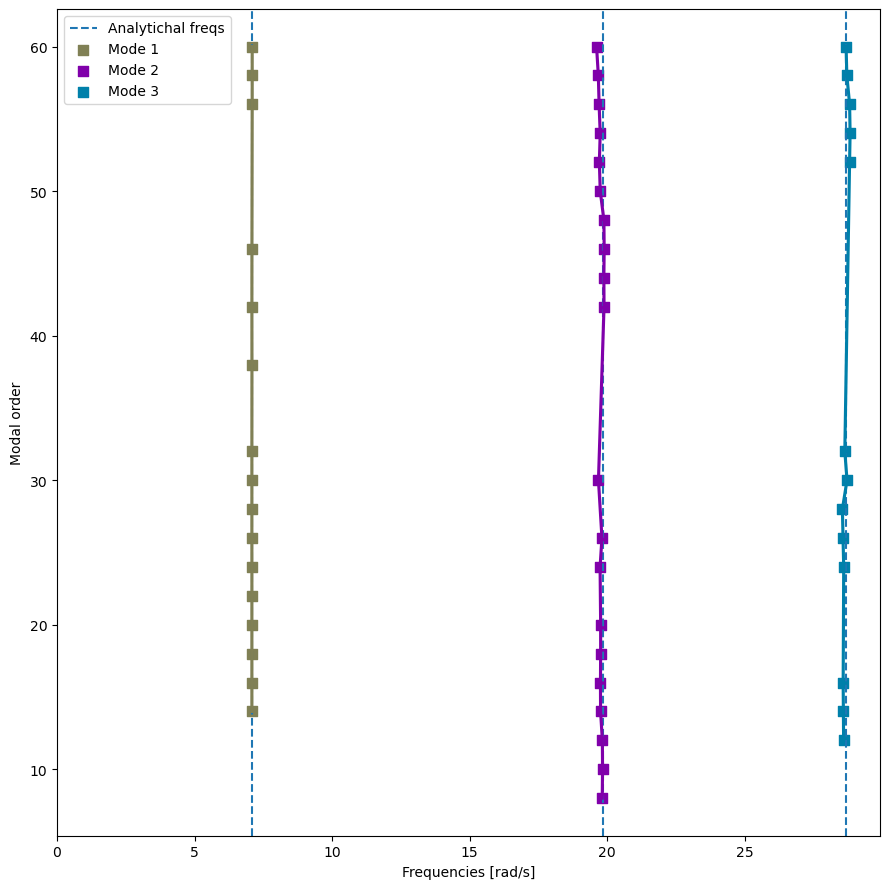

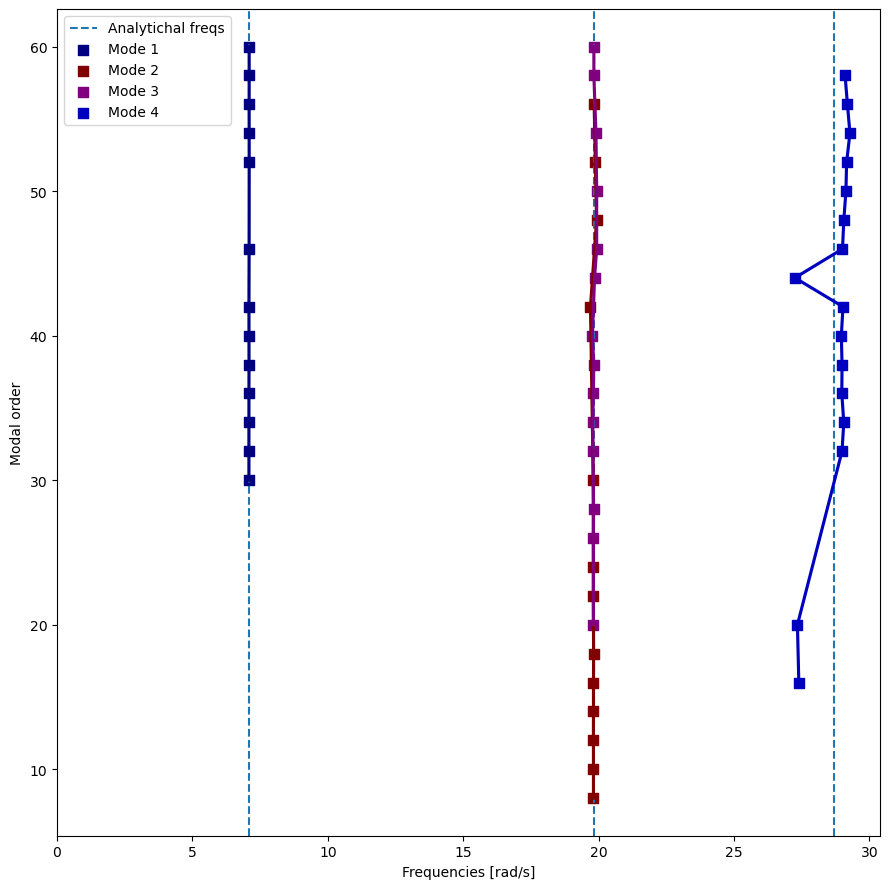

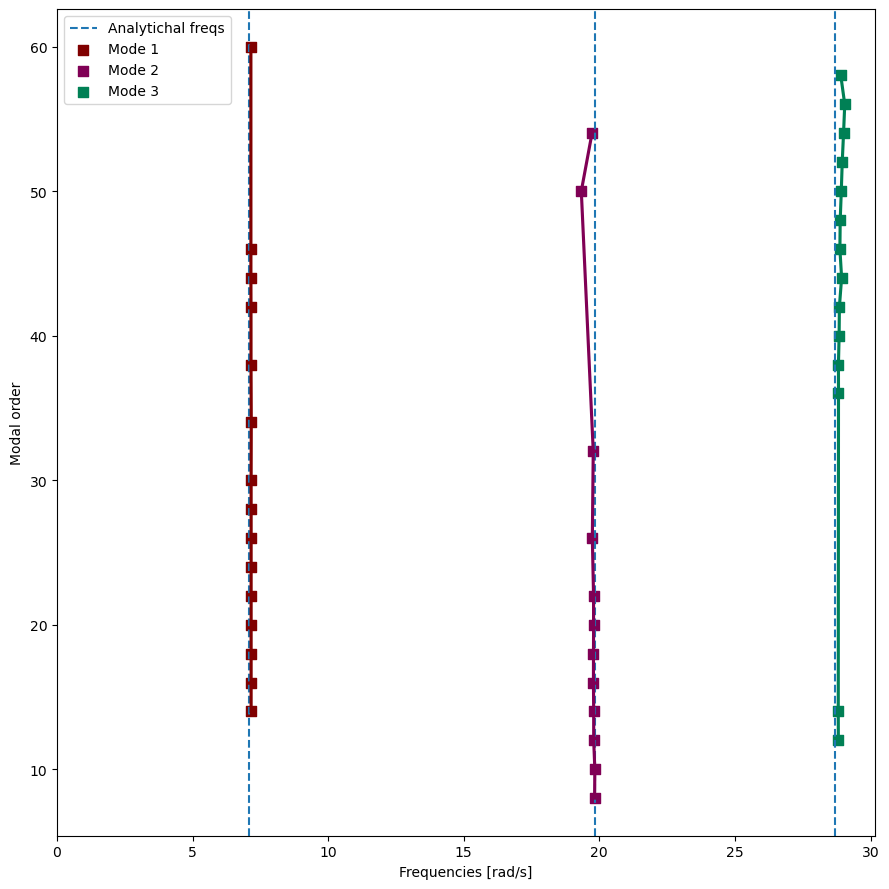

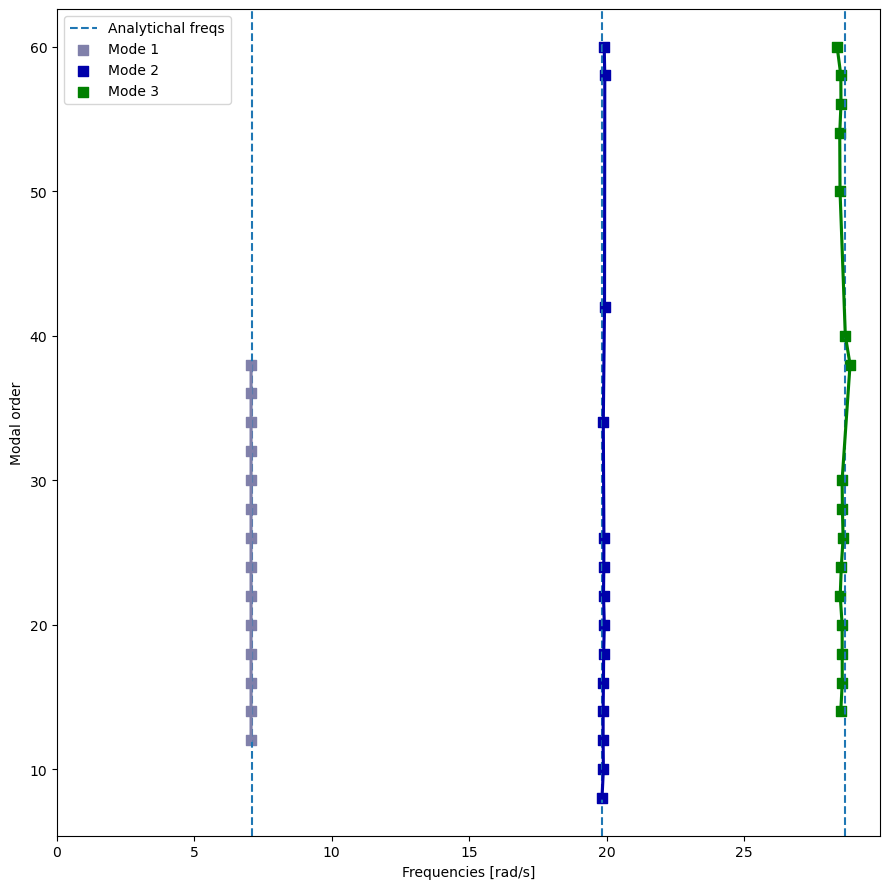

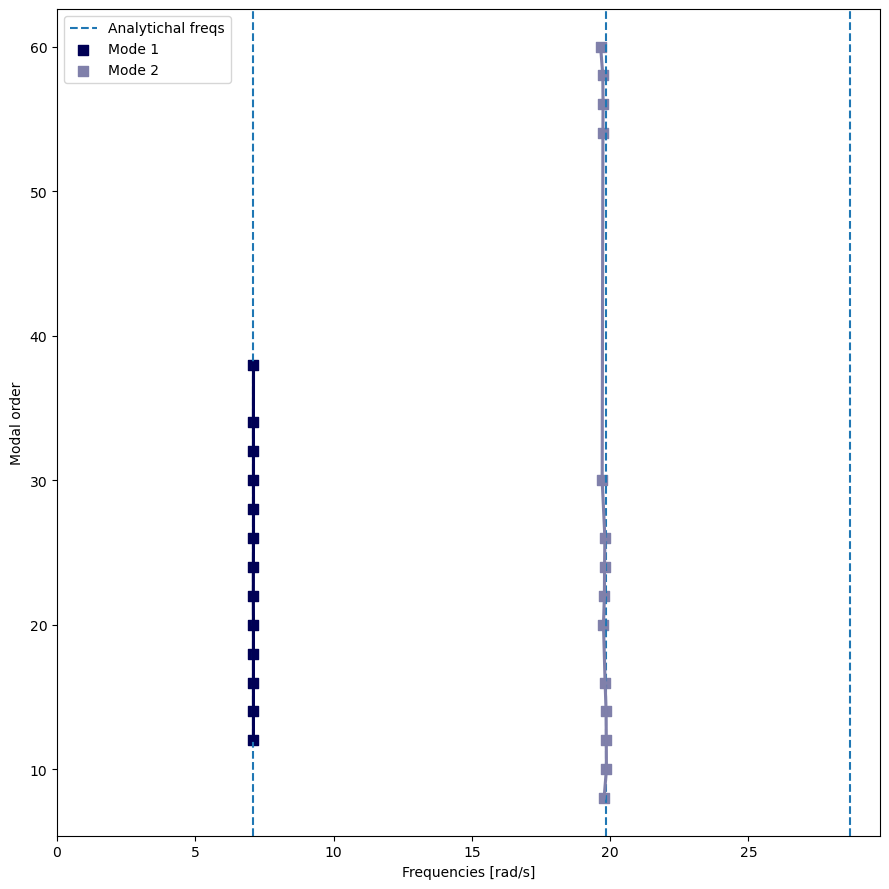

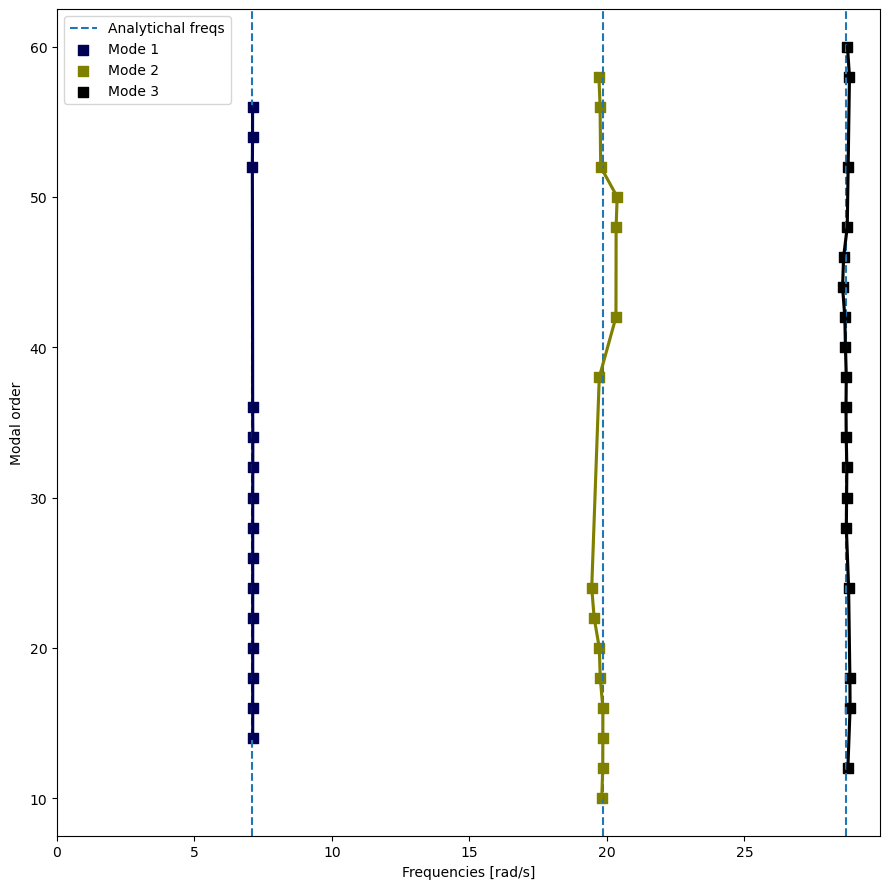

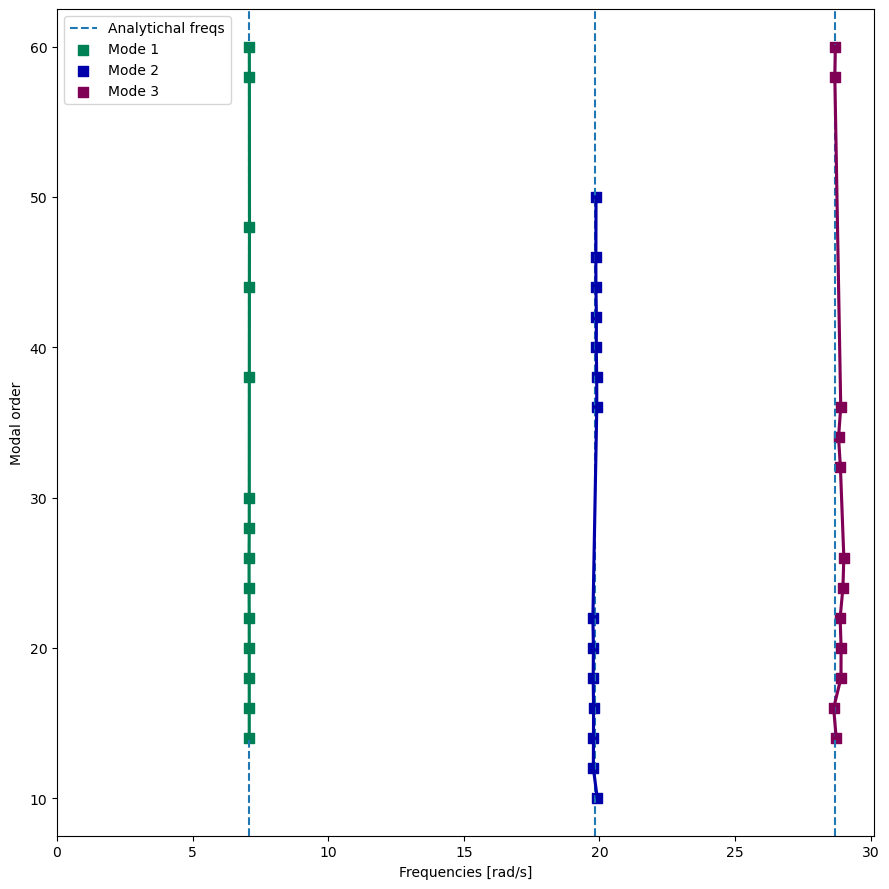

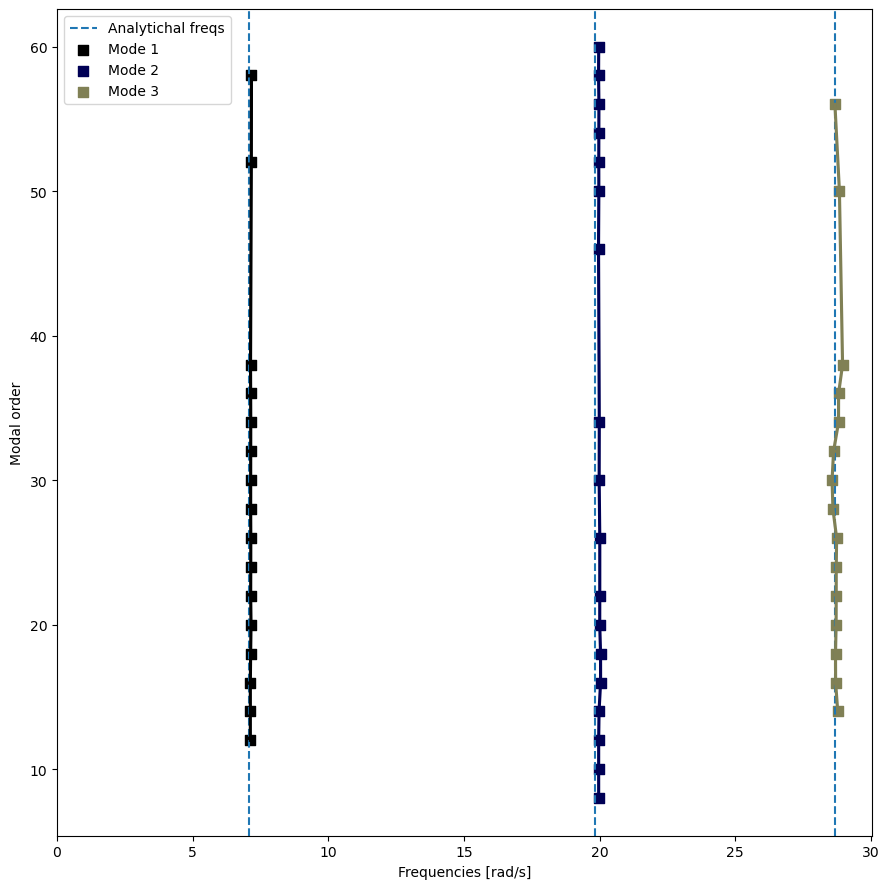

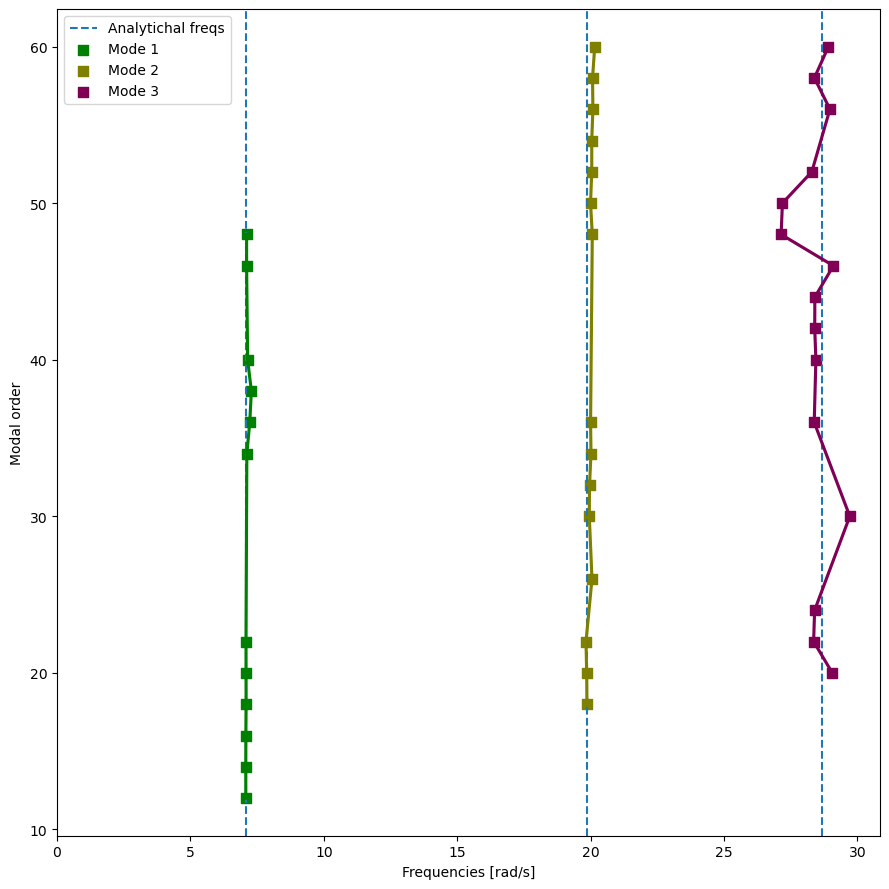

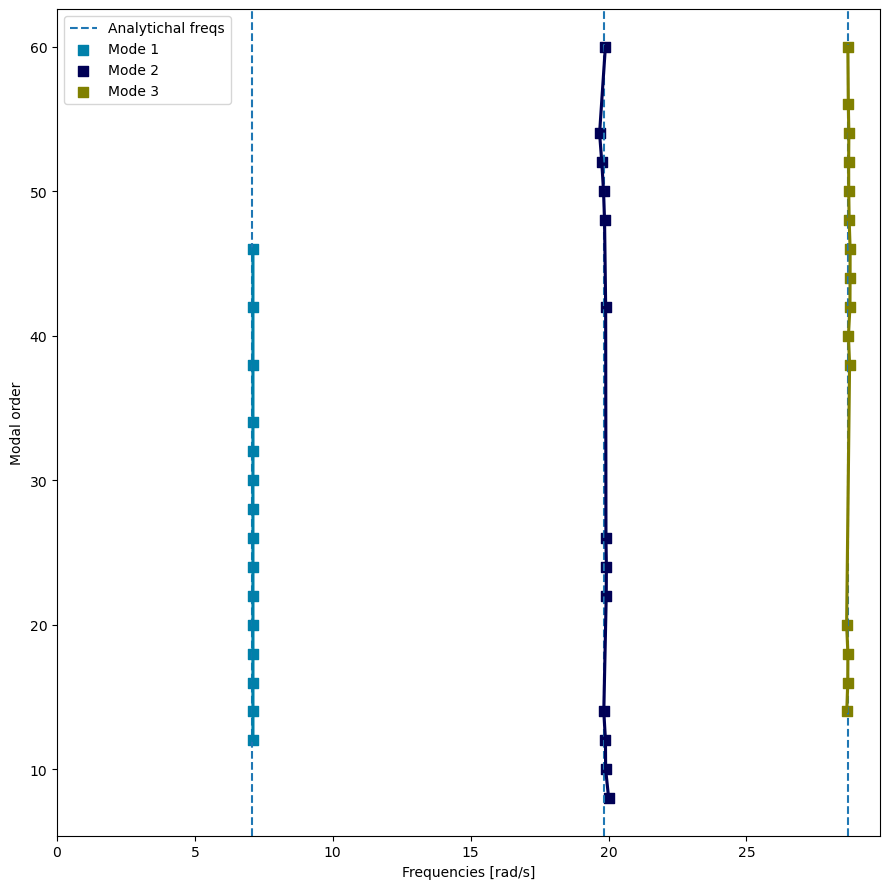

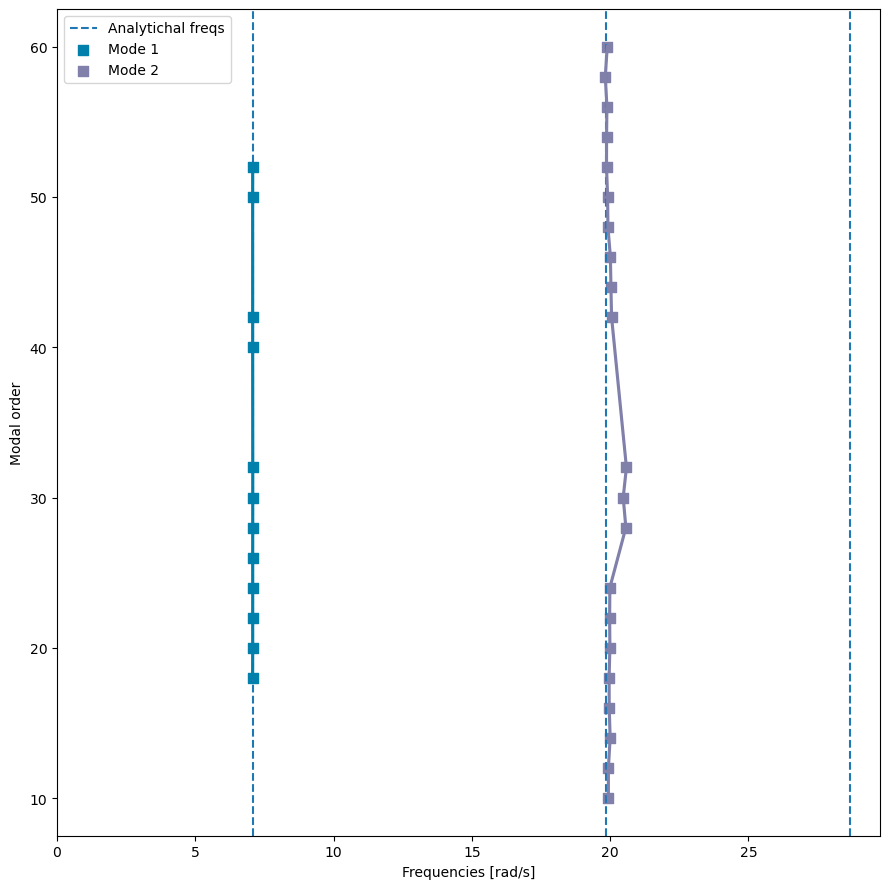

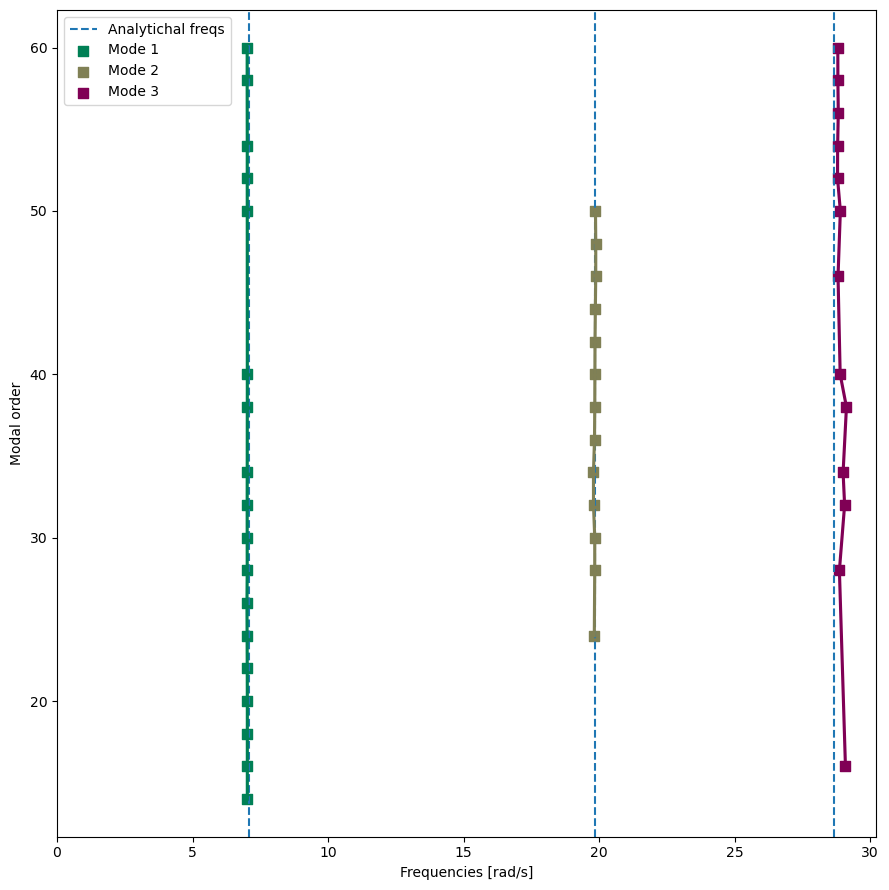

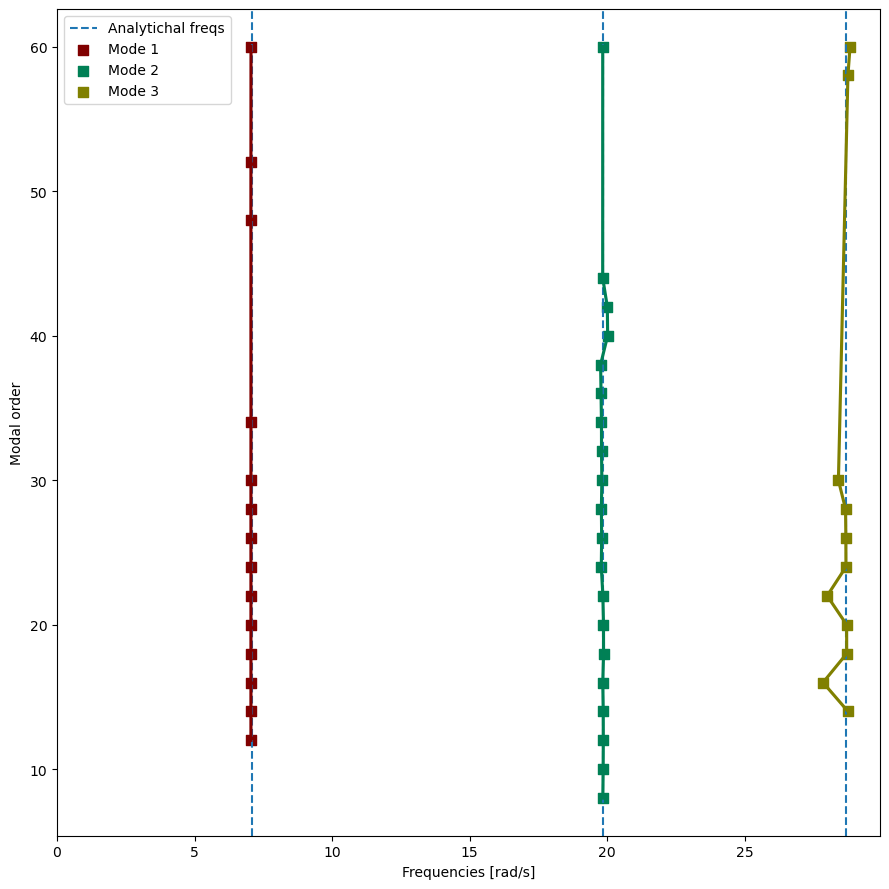

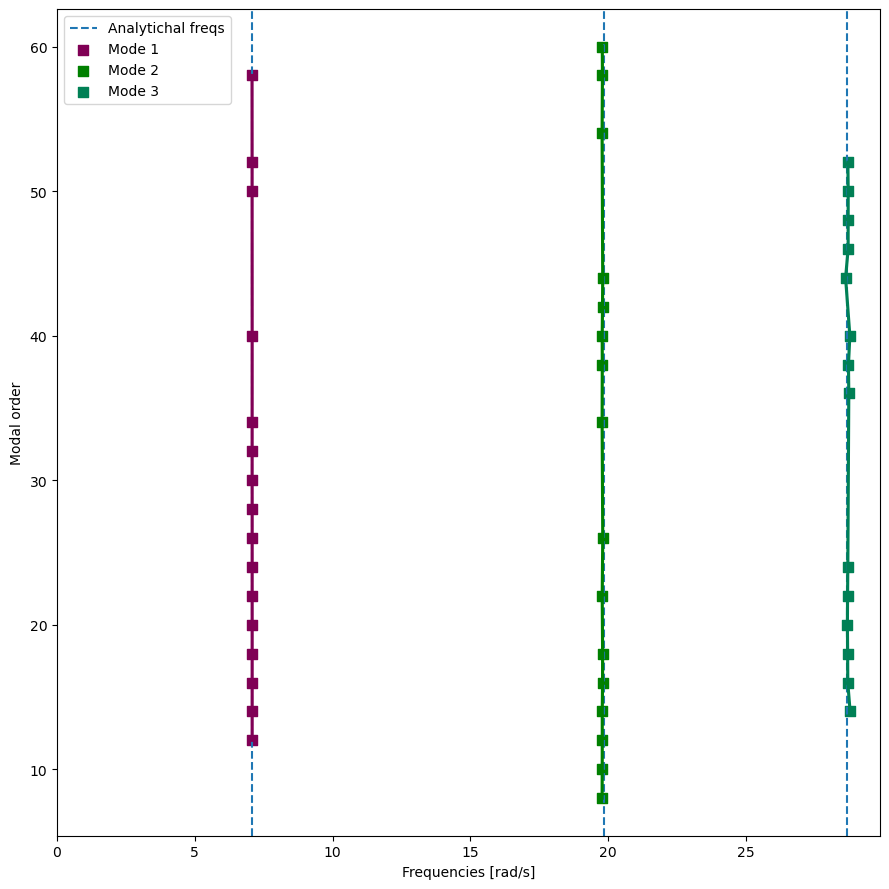

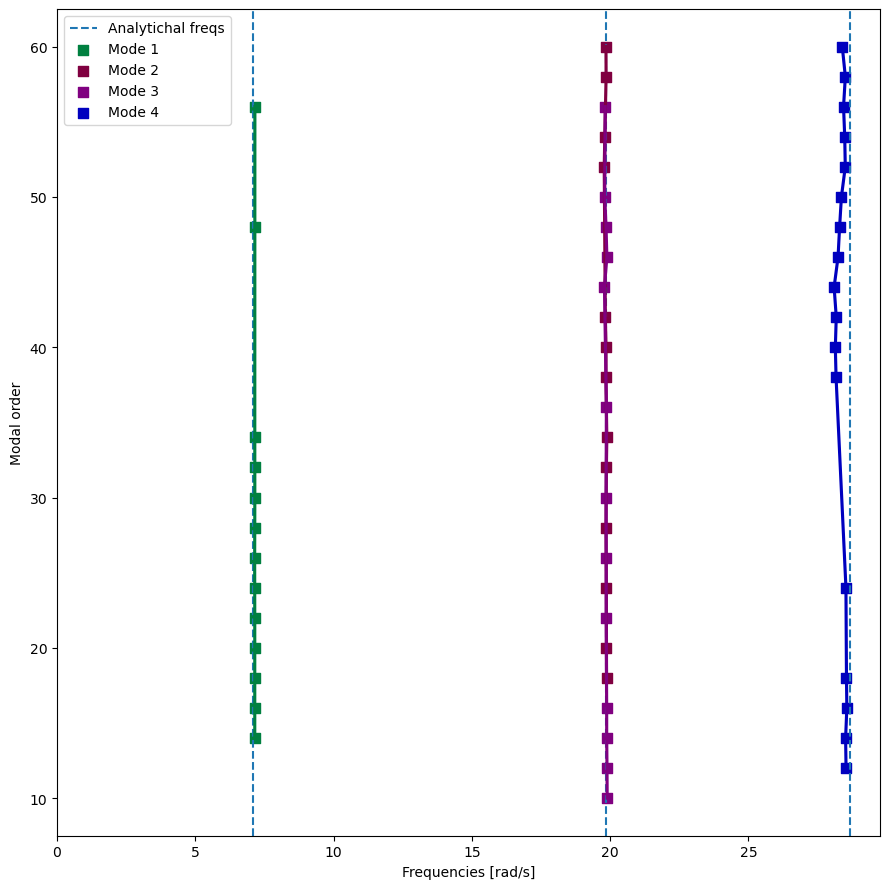

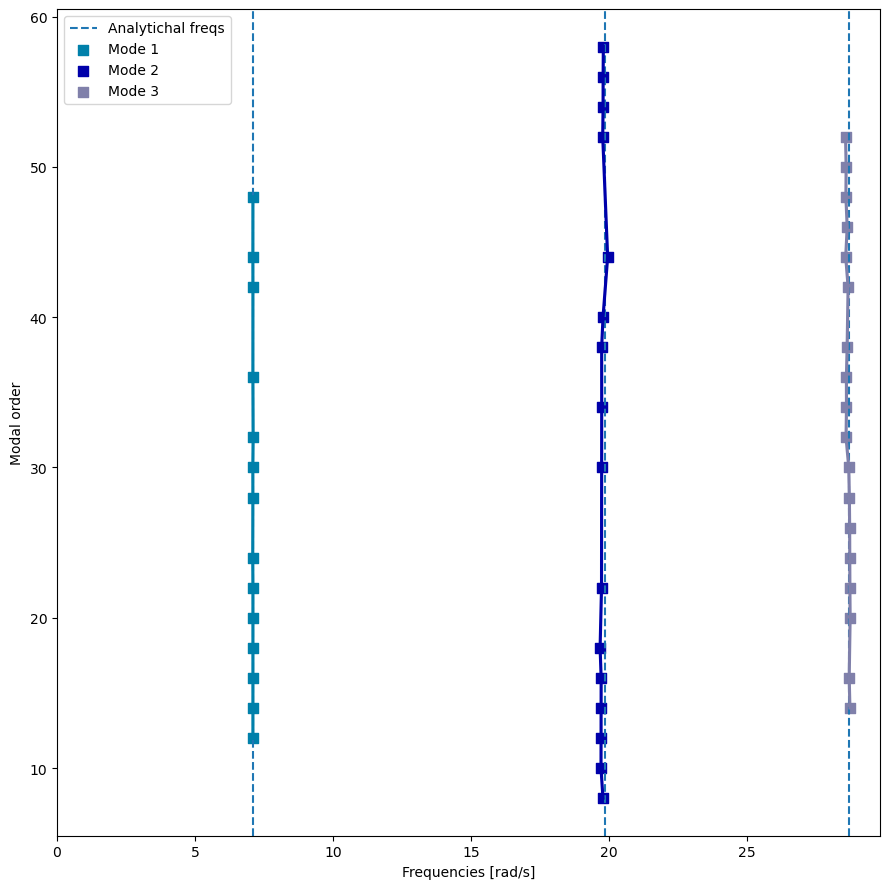

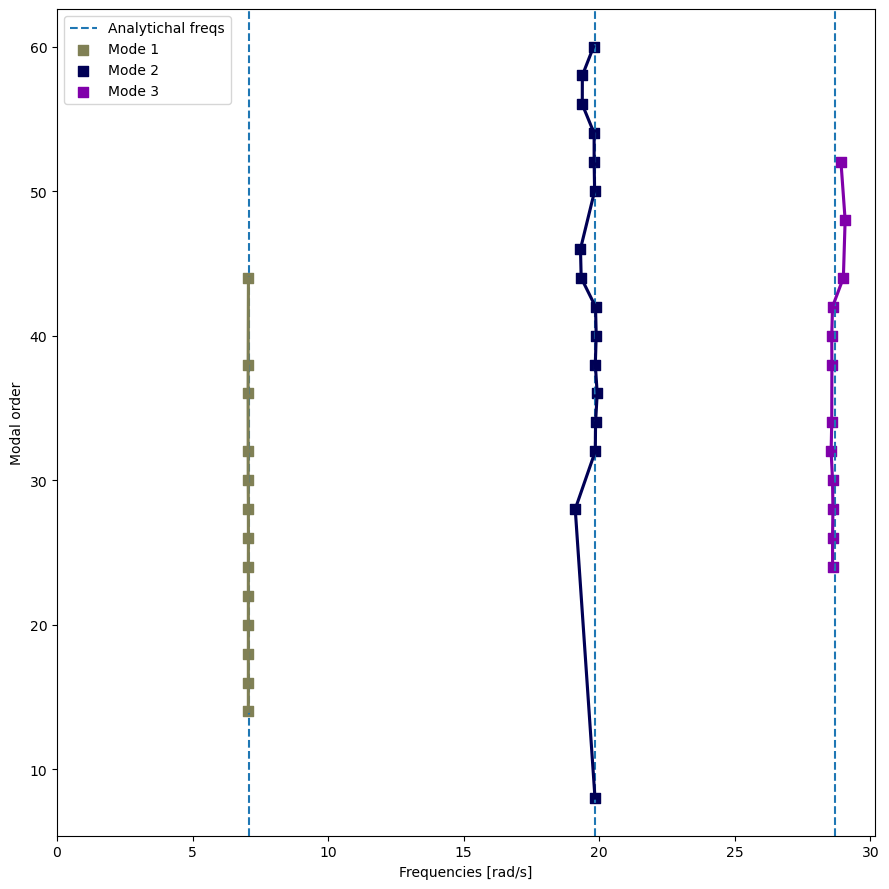

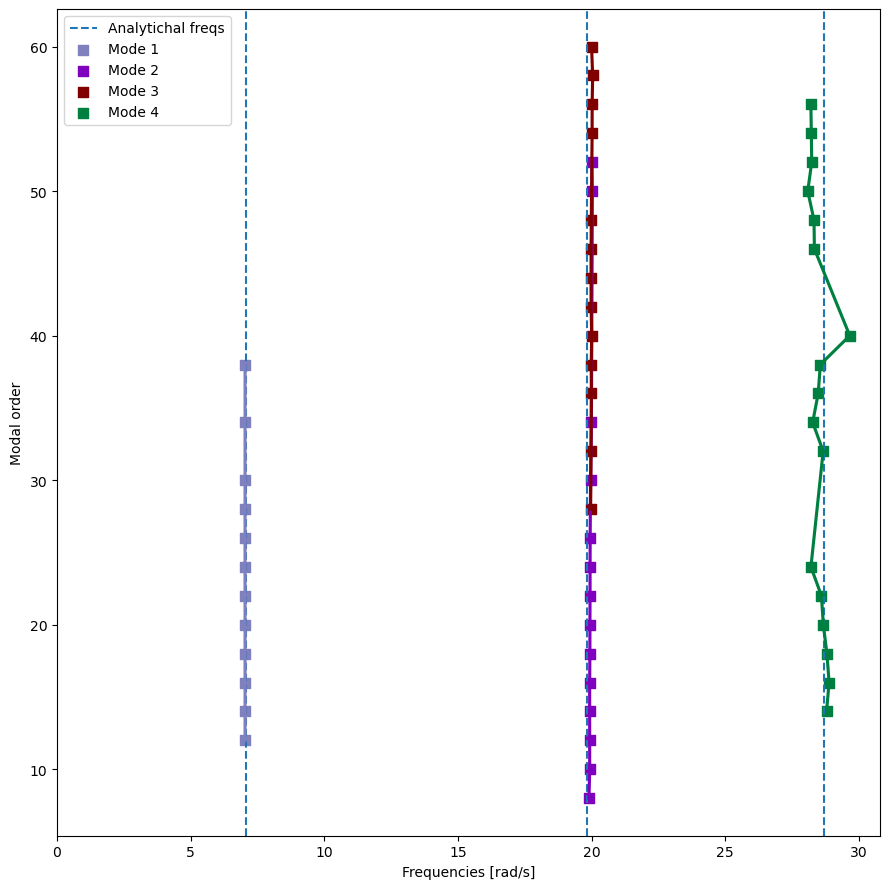

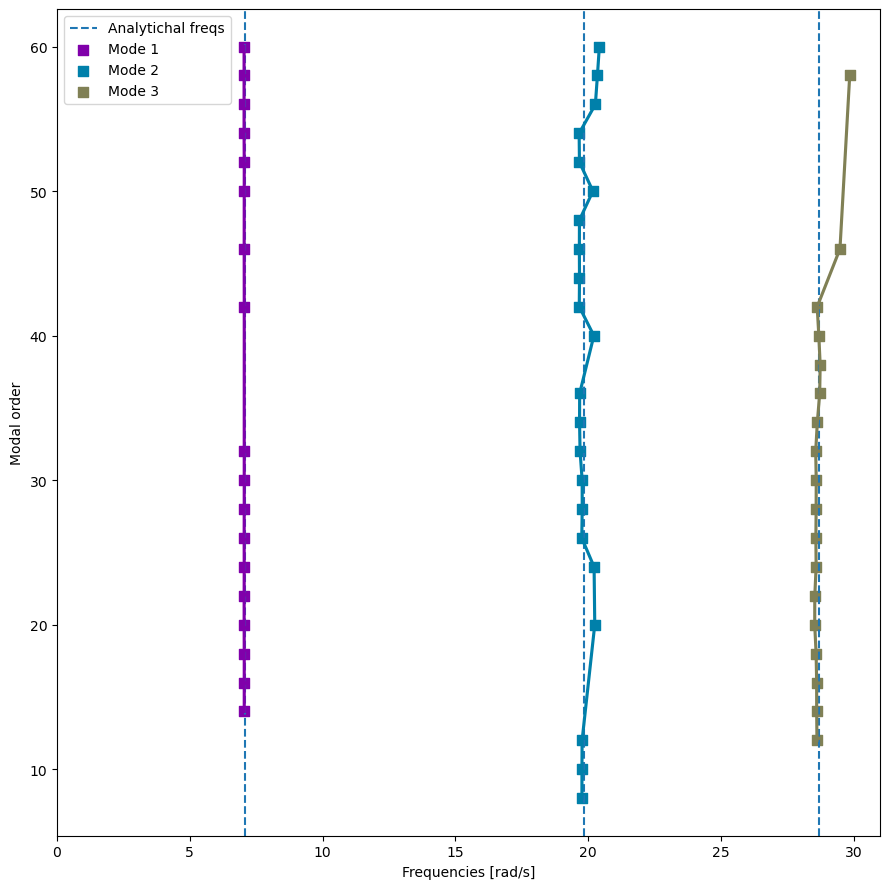

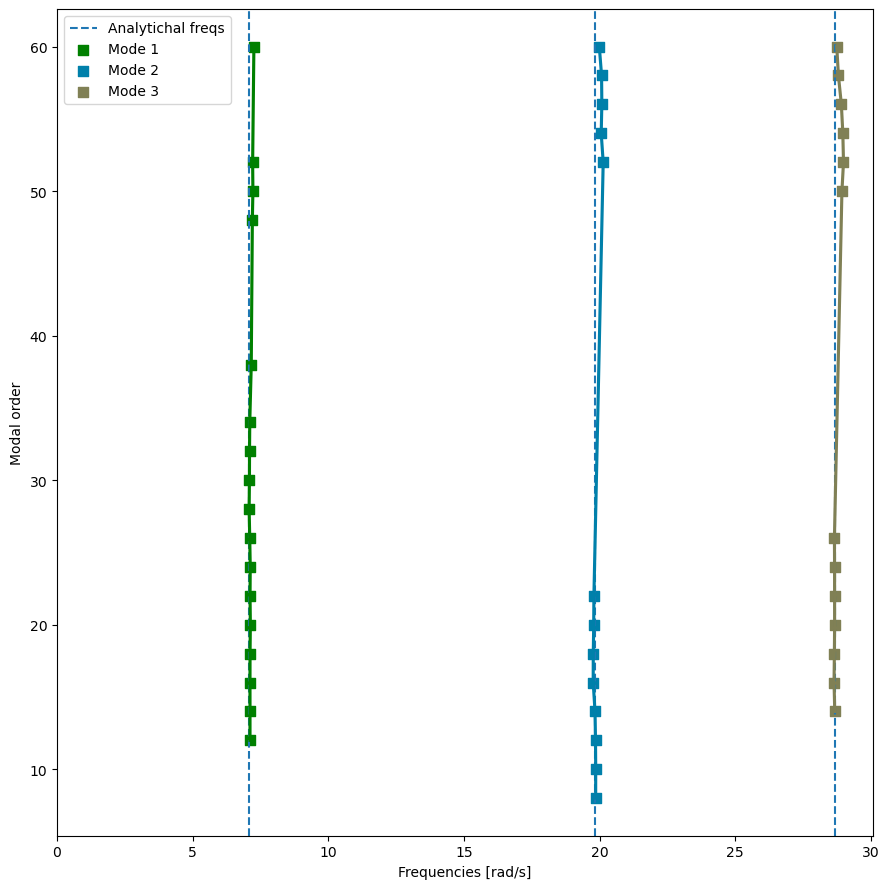

In [31]:
for j in range(number_of_realizations):

    data = np.load(path + str(j) + ".npz")
    y = data["y"].transpose()
    fs = data["fs"].transpose()
    true_f = data["true_frequencies"].transpose()
    true_xi = data["true_damping"].transpose()
    true_modeshapes = data["true_modeshapes"].transpose()

    #Cov-SSI call
    lambd, phi = koma.oma.covssi(y, fs, i, orders, showinfo=False) # find poles by Cov-SSI
    lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd, phi, orders, s, stabcrit=stabcrit, indicator='mac') # Stable poles

    #Welch PSD estimate
    nperseg = 1024
    zp = 4
    nfft = nperseg*zp
    f, Pxx = welch(y[:,0], fs, 'hanning', nperseg=nperseg, nfft=nfft)

    #Pole clustering
    pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0})
    prob_threshold = 0.5   #probability of pole to belong to cluster, based on estimated "probability" density function
    args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

    xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

    fig = plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/np.pi/2, order_auto, true_w=true_f)
    fig.savefig("results/realization_" + str(j) + ".jpg")

    xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
    fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

    xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
    fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi